In [ ]:
from google.colab import drive;
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!mkdir -p coco_dataset/train2017 coco_dataset/annotations

# Download train2017 images (~18GB, but we'll fetch only a subset)
!wget -q --show-progress http://images.cocodataset.org/zips/train2017.zip
!unzip -q train2017.zip -d coco_dataset/

# Download annotations (~250MB)
!wget -q --show-progress http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d coco_dataset/

train2017.zip       100%[===================>]  18.01G  17.0MB/s    in 11m 11s 
annotations_trainva 100%[===================>] 241.19M  55.5MB/s    in 4.8s    


loading annotations into memory...
Done (t=0.91s)
creating index...
index created!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5:   0%|          | 1/308 [00:06<32:59,  6.45s/it]

[Epoch 0/5] [Batch 0/308] [D loss: 0.6291749477386475] [G loss: 0.7313053607940674]


Epoch 1/5:   1%|          | 2/308 [00:11<30:05,  5.90s/it]

[Epoch 0/5] [Batch 1/308] [D loss: 0.4234367609024048] [G loss: 1.8749207258224487]


Epoch 1/5:   1%|          | 3/308 [00:16<27:03,  5.32s/it]

[Epoch 0/5] [Batch 2/308] [D loss: 0.2852151393890381] [G loss: 1.55156409740448]


Epoch 1/5:   1%|▏         | 4/308 [00:22<28:35,  5.64s/it]

[Epoch 0/5] [Batch 3/308] [D loss: 0.2258789837360382] [G loss: 1.6301038265228271]


Epoch 1/5:   2%|▏         | 5/308 [00:29<29:59,  5.94s/it]

[Epoch 0/5] [Batch 4/308] [D loss: 0.18118205666542053] [G loss: 1.8172345161437988]


Epoch 1/5:   2%|▏         | 6/308 [00:37<33:27,  6.65s/it]

[Epoch 0/5] [Batch 5/308] [D loss: 0.16882064938545227] [G loss: 2.0246129035949707]


Epoch 1/5:   2%|▏         | 7/308 [00:43<32:31,  6.48s/it]

[Epoch 0/5] [Batch 6/308] [D loss: 0.16278721392154694] [G loss: 2.113294839859009]


Epoch 1/5:   3%|▎         | 8/308 [00:48<29:50,  5.97s/it]

[Epoch 0/5] [Batch 7/308] [D loss: 0.16102436184883118] [G loss: 1.880408525466919]


Epoch 1/5:   3%|▎         | 9/308 [00:54<29:26,  5.91s/it]

[Epoch 0/5] [Batch 8/308] [D loss: 0.1320098340511322] [G loss: 2.380945920944214]


Epoch 1/5:   3%|▎         | 10/308 [00:58<27:54,  5.62s/it]

[Epoch 0/5] [Batch 9/308] [D loss: 0.14436034858226776] [G loss: 1.9855116605758667]


Epoch 1/5:   4%|▎         | 11/308 [01:07<31:30,  6.36s/it]

[Epoch 0/5] [Batch 10/308] [D loss: 0.11599066853523254] [G loss: 2.6853182315826416]


Epoch 1/5:   4%|▍         | 12/308 [01:11<29:14,  5.93s/it]

[Epoch 0/5] [Batch 11/308] [D loss: 0.13222581148147583] [G loss: 1.9085195064544678]


Epoch 1/5:   4%|▍         | 13/308 [01:22<36:06,  7.34s/it]

[Epoch 0/5] [Batch 12/308] [D loss: 0.0780119076371193] [G loss: 2.7038934230804443]


Epoch 1/5:   5%|▍         | 14/308 [01:36<45:57,  9.38s/it]

[Epoch 0/5] [Batch 13/308] [D loss: 0.08515819907188416] [G loss: 2.6106693744659424]


Epoch 1/5:   5%|▍         | 15/308 [01:42<40:52,  8.37s/it]

[Epoch 0/5] [Batch 14/308] [D loss: 0.08920858055353165] [G loss: 2.5205509662628174]


Epoch 1/5:   5%|▌         | 16/308 [01:49<38:32,  7.92s/it]

[Epoch 0/5] [Batch 15/308] [D loss: 0.11314815282821655] [G loss: 2.1871955394744873]


Epoch 1/5:   6%|▌         | 17/308 [01:54<34:17,  7.07s/it]

[Epoch 0/5] [Batch 16/308] [D loss: 0.05814038962125778] [G loss: 3.035644054412842]


Epoch 1/5:   6%|▌         | 18/308 [02:00<32:35,  6.74s/it]

[Epoch 0/5] [Batch 17/308] [D loss: 0.06376421451568604] [G loss: 2.9145007133483887]


Epoch 1/5:   6%|▌         | 19/308 [02:05<29:56,  6.22s/it]

[Epoch 0/5] [Batch 18/308] [D loss: 0.07718881964683533] [G loss: 2.4309518337249756]


Epoch 1/5:   6%|▋         | 20/308 [02:10<27:50,  5.80s/it]

[Epoch 0/5] [Batch 19/308] [D loss: 0.0623856857419014] [G loss: 3.128941535949707]


Epoch 1/5:   7%|▋         | 21/308 [02:16<28:16,  5.91s/it]

[Epoch 0/5] [Batch 20/308] [D loss: 0.05638433247804642] [G loss: 2.8426990509033203]


Epoch 1/5:   7%|▋         | 22/308 [02:22<28:13,  5.92s/it]

[Epoch 0/5] [Batch 21/308] [D loss: 0.05439816415309906] [G loss: 2.820530414581299]


Epoch 1/5:   7%|▋         | 23/308 [02:29<29:58,  6.31s/it]

[Epoch 0/5] [Batch 22/308] [D loss: 0.054854147136211395] [G loss: 3.1095266342163086]


Epoch 1/5:   8%|▊         | 24/308 [02:35<28:52,  6.10s/it]

[Epoch 0/5] [Batch 23/308] [D loss: 0.04328376427292824] [G loss: 2.900153160095215]


Epoch 1/5:   8%|▊         | 25/308 [02:41<29:20,  6.22s/it]

[Epoch 0/5] [Batch 24/308] [D loss: 0.0342520996928215] [G loss: 3.5782384872436523]


Epoch 1/5:   8%|▊         | 26/308 [02:46<27:20,  5.82s/it]

[Epoch 0/5] [Batch 25/308] [D loss: 0.045468807220458984] [G loss: 3.160938262939453]


Epoch 1/5:   9%|▉         | 27/308 [02:52<27:01,  5.77s/it]

[Epoch 0/5] [Batch 26/308] [D loss: 0.05643025040626526] [G loss: 2.8804056644439697]


Epoch 1/5:   9%|▉         | 28/308 [02:58<26:46,  5.74s/it]

[Epoch 0/5] [Batch 27/308] [D loss: 0.03778104484081268] [G loss: 3.5397844314575195]


Epoch 1/5:   9%|▉         | 29/308 [03:04<27:18,  5.87s/it]

[Epoch 0/5] [Batch 28/308] [D loss: 0.035186123102903366] [G loss: 3.345953941345215]


Epoch 1/5:  10%|▉         | 30/308 [03:12<30:05,  6.49s/it]

[Epoch 0/5] [Batch 29/308] [D loss: 0.039121419191360474] [G loss: 3.3448734283447266]


Epoch 1/5:  10%|█         | 31/308 [03:16<27:10,  5.88s/it]

[Epoch 0/5] [Batch 30/308] [D loss: 0.03717153146862984] [G loss: 3.2225770950317383]


Epoch 1/5:  10%|█         | 32/308 [03:22<27:01,  5.87s/it]

[Epoch 0/5] [Batch 31/308] [D loss: 0.024909256026148796] [G loss: 3.5367939472198486]


Epoch 1/5:  11%|█         | 33/308 [03:27<25:15,  5.51s/it]

[Epoch 0/5] [Batch 32/308] [D loss: 0.029466360807418823] [G loss: 3.5700576305389404]


Epoch 1/5:  11%|█         | 34/308 [03:34<26:55,  5.90s/it]

[Epoch 0/5] [Batch 33/308] [D loss: 0.033763766288757324] [G loss: 3.4545068740844727]


Epoch 1/5:  11%|█▏        | 35/308 [03:38<25:26,  5.59s/it]

[Epoch 0/5] [Batch 34/308] [D loss: 0.03394584357738495] [G loss: 3.592198133468628]


Epoch 1/5:  12%|█▏        | 36/308 [03:43<24:10,  5.33s/it]

[Epoch 0/5] [Batch 35/308] [D loss: 0.03133730590343475] [G loss: 3.351907968521118]


Epoch 1/5:  12%|█▏        | 37/308 [03:50<25:37,  5.67s/it]

[Epoch 0/5] [Batch 36/308] [D loss: 0.035822320729494095] [G loss: 3.59419322013855]


Epoch 1/5:  12%|█▏        | 38/308 [03:54<24:17,  5.40s/it]

[Epoch 0/5] [Batch 37/308] [D loss: 0.030537521466612816] [G loss: 3.6828718185424805]


Epoch 1/5:  13%|█▎        | 39/308 [04:01<25:27,  5.68s/it]

[Epoch 0/5] [Batch 38/308] [D loss: 0.024788660928606987] [G loss: 3.4273414611816406]


Epoch 1/5:  13%|█▎        | 40/308 [04:06<25:32,  5.72s/it]

[Epoch 0/5] [Batch 39/308] [D loss: 0.019587477669119835] [G loss: 3.8131589889526367]


Epoch 1/5:  13%|█▎        | 41/308 [04:12<25:39,  5.76s/it]

[Epoch 0/5] [Batch 40/308] [D loss: 0.022940946742892265] [G loss: 3.9167535305023193]


Epoch 1/5:  14%|█▎        | 42/308 [04:18<25:41,  5.80s/it]

[Epoch 0/5] [Batch 41/308] [D loss: 0.023642372339963913] [G loss: 3.6311917304992676]


Epoch 1/5:  14%|█▍        | 43/308 [04:23<24:29,  5.54s/it]

[Epoch 0/5] [Batch 42/308] [D loss: 0.027642931789159775] [G loss: 3.7648887634277344]


Epoch 1/5:  14%|█▍        | 44/308 [04:29<25:01,  5.69s/it]

[Epoch 0/5] [Batch 43/308] [D loss: 0.023046676069498062] [G loss: 3.8510937690734863]


Epoch 1/5:  15%|█▍        | 45/308 [04:34<24:08,  5.51s/it]

[Epoch 0/5] [Batch 44/308] [D loss: 0.02858009748160839] [G loss: 3.6169240474700928]


Epoch 1/5:  15%|█▍        | 46/308 [04:41<24:59,  5.72s/it]

[Epoch 0/5] [Batch 45/308] [D loss: 0.02583104744553566] [G loss: 3.6498031616210938]


Epoch 1/5:  15%|█▌        | 47/308 [04:46<24:54,  5.73s/it]

[Epoch 0/5] [Batch 46/308] [D loss: 0.01942620612680912] [G loss: 3.92228102684021]


Epoch 1/5:  16%|█▌        | 48/308 [04:54<27:41,  6.39s/it]

[Epoch 0/5] [Batch 47/308] [D loss: 0.02303529530763626] [G loss: 4.182146072387695]


Epoch 1/5:  16%|█▌        | 49/308 [04:59<25:21,  5.87s/it]

[Epoch 0/5] [Batch 48/308] [D loss: 0.021893274039030075] [G loss: 3.6822314262390137]


Epoch 1/5:  16%|█▌        | 50/308 [05:04<24:39,  5.73s/it]

[Epoch 0/5] [Batch 49/308] [D loss: 0.021506913006305695] [G loss: 3.710587501525879]


Epoch 1/5:  17%|█▋        | 51/308 [05:10<24:58,  5.83s/it]

[Epoch 0/5] [Batch 50/308] [D loss: 0.016384249553084373] [G loss: 4.247305870056152]


Epoch 1/5:  17%|█▋        | 52/308 [05:16<24:08,  5.66s/it]

[Epoch 0/5] [Batch 51/308] [D loss: 0.022942759096622467] [G loss: 4.0351386070251465]


Epoch 1/5:  17%|█▋        | 53/308 [05:21<24:15,  5.71s/it]

[Epoch 0/5] [Batch 52/308] [D loss: 0.023764099925756454] [G loss: 3.9213340282440186]


Epoch 1/5:  18%|█▊        | 54/308 [05:26<23:13,  5.49s/it]

[Epoch 0/5] [Batch 53/308] [D loss: 0.024287164211273193] [G loss: 3.4745216369628906]


Epoch 1/5:  18%|█▊        | 55/308 [05:32<23:06,  5.48s/it]

[Epoch 0/5] [Batch 54/308] [D loss: 0.017855163663625717] [G loss: 4.285539150238037]


Epoch 1/5:  18%|█▊        | 56/308 [05:37<22:52,  5.45s/it]

[Epoch 0/5] [Batch 55/308] [D loss: 0.010324305854737759] [G loss: 4.612787246704102]


Epoch 1/5:  19%|█▊        | 57/308 [05:42<21:45,  5.20s/it]

[Epoch 0/5] [Batch 56/308] [D loss: 0.017427675426006317] [G loss: 4.001955509185791]


Epoch 1/5:  19%|█▉        | 58/308 [05:48<22:55,  5.50s/it]

[Epoch 0/5] [Batch 57/308] [D loss: 0.01782323233783245] [G loss: 3.7803127765655518]


Epoch 1/5:  19%|█▉        | 59/308 [05:53<22:15,  5.36s/it]

[Epoch 0/5] [Batch 58/308] [D loss: 0.031993262469768524] [G loss: 4.299441337585449]


Epoch 1/5:  19%|█▉        | 60/308 [05:58<21:57,  5.31s/it]

[Epoch 0/5] [Batch 59/308] [D loss: 0.027274711057543755] [G loss: 3.1822168827056885]


Epoch 1/5:  20%|█▉        | 61/308 [06:05<23:13,  5.64s/it]

[Epoch 0/5] [Batch 60/308] [D loss: 0.02043040841817856] [G loss: 4.9436259269714355]


Epoch 1/5:  20%|██        | 62/308 [06:12<24:37,  6.00s/it]

[Epoch 0/5] [Batch 61/308] [D loss: 0.012225114740431309] [G loss: 4.497977256774902]


Epoch 1/5:  20%|██        | 63/308 [06:18<24:51,  6.09s/it]

[Epoch 0/5] [Batch 62/308] [D loss: 0.016600728034973145] [G loss: 3.678391933441162]


Epoch 1/5:  21%|██        | 64/308 [06:22<22:31,  5.54s/it]

[Epoch 0/5] [Batch 63/308] [D loss: 0.00978459045290947] [G loss: 4.823947906494141]


Epoch 1/5:  21%|██        | 65/308 [06:28<22:58,  5.67s/it]

[Epoch 0/5] [Batch 64/308] [D loss: 0.016287218779325485] [G loss: 4.329058647155762]


Epoch 1/5:  21%|██▏       | 66/308 [06:33<21:59,  5.45s/it]

[Epoch 0/5] [Batch 65/308] [D loss: 0.021601391956210136] [G loss: 3.8013246059417725]


Epoch 1/5:  22%|██▏       | 67/308 [06:38<20:54,  5.21s/it]

[Epoch 0/5] [Batch 66/308] [D loss: 0.016040265560150146] [G loss: 4.051914691925049]


Epoch 1/5:  22%|██▏       | 68/308 [06:44<21:54,  5.48s/it]

[Epoch 0/5] [Batch 67/308] [D loss: 0.017444942146539688] [G loss: 4.2570719718933105]


Epoch 1/5:  22%|██▏       | 69/308 [06:49<21:30,  5.40s/it]

[Epoch 0/5] [Batch 68/308] [D loss: 0.019838973879814148] [G loss: 3.994480609893799]


Epoch 1/5:  23%|██▎       | 70/308 [06:56<23:13,  5.86s/it]

[Epoch 0/5] [Batch 69/308] [D loss: 0.01775440387427807] [G loss: 3.9726357460021973]


Epoch 1/5:  23%|██▎       | 71/308 [07:01<22:48,  5.77s/it]

[Epoch 0/5] [Batch 70/308] [D loss: 0.01635127328336239] [G loss: 4.173295974731445]


Epoch 1/5:  23%|██▎       | 72/308 [07:10<25:25,  6.46s/it]

[Epoch 0/5] [Batch 71/308] [D loss: 0.02026953548192978] [G loss: 4.222866058349609]


Epoch 1/5:  24%|██▎       | 73/308 [07:16<25:33,  6.53s/it]

[Epoch 0/5] [Batch 72/308] [D loss: 0.019589930772781372] [G loss: 3.5202364921569824]


Epoch 1/5:  24%|██▍       | 74/308 [07:22<24:58,  6.41s/it]

[Epoch 0/5] [Batch 73/308] [D loss: 0.016801390796899796] [G loss: 4.977419853210449]


Epoch 1/5:  24%|██▍       | 75/308 [07:28<23:54,  6.16s/it]

[Epoch 0/5] [Batch 74/308] [D loss: 0.013053460977971554] [G loss: 4.395650386810303]


Epoch 1/5:  25%|██▍       | 76/308 [07:35<24:24,  6.31s/it]

[Epoch 0/5] [Batch 75/308] [D loss: 0.018113471567630768] [G loss: 3.849961280822754]


Epoch 1/5:  25%|██▌       | 77/308 [07:39<22:10,  5.76s/it]

[Epoch 0/5] [Batch 76/308] [D loss: 0.011599566787481308] [G loss: 4.333529472351074]


Epoch 1/5:  25%|██▌       | 78/308 [07:45<22:08,  5.77s/it]

[Epoch 0/5] [Batch 77/308] [D loss: 0.024077527225017548] [G loss: 4.45593786239624]


Epoch 1/5:  26%|██▌       | 79/308 [07:51<22:10,  5.81s/it]

[Epoch 0/5] [Batch 78/308] [D loss: 0.03449111431837082] [G loss: 2.9053683280944824]


Epoch 1/5:  26%|██▌       | 80/308 [07:56<21:10,  5.57s/it]

[Epoch 0/5] [Batch 79/308] [D loss: 0.021232042461633682] [G loss: 6.449320316314697]


Epoch 1/5:  26%|██▋       | 81/308 [08:02<22:04,  5.83s/it]

[Epoch 0/5] [Batch 80/308] [D loss: 0.00974179431796074] [G loss: 5.468628406524658]


Epoch 1/5:  27%|██▋       | 82/308 [08:09<22:53,  6.08s/it]

[Epoch 0/5] [Batch 81/308] [D loss: 0.016851527616381645] [G loss: 3.9095892906188965]


Epoch 1/5:  27%|██▋       | 83/308 [08:16<23:58,  6.39s/it]

[Epoch 0/5] [Batch 82/308] [D loss: 0.01636425405740738] [G loss: 3.6279563903808594]


Epoch 1/5:  27%|██▋       | 84/308 [08:21<22:44,  6.09s/it]

[Epoch 0/5] [Batch 83/308] [D loss: 0.012937955558300018] [G loss: 5.154078483581543]


Epoch 1/5:  28%|██▊       | 85/308 [08:28<22:48,  6.14s/it]

[Epoch 0/5] [Batch 84/308] [D loss: 0.00799065362662077] [G loss: 4.5125532150268555]


Epoch 1/5:  28%|██▊       | 86/308 [08:32<21:17,  5.75s/it]

[Epoch 0/5] [Batch 85/308] [D loss: 0.010647115297615528] [G loss: 4.28590202331543]


Epoch 1/5:  28%|██▊       | 87/308 [08:37<20:11,  5.48s/it]

[Epoch 0/5] [Batch 86/308] [D loss: 0.013565401546657085] [G loss: 4.429250717163086]


Epoch 1/5:  29%|██▊       | 88/308 [08:44<21:47,  5.94s/it]

[Epoch 0/5] [Batch 87/308] [D loss: 0.017815418541431427] [G loss: 4.0975542068481445]


Epoch 1/5:  29%|██▉       | 89/308 [08:49<20:44,  5.68s/it]

[Epoch 0/5] [Batch 88/308] [D loss: 0.014494518749415874] [G loss: 3.8907175064086914]


Epoch 1/5:  29%|██▉       | 90/308 [08:56<21:40,  5.97s/it]

[Epoch 0/5] [Batch 89/308] [D loss: 0.013784937560558319] [G loss: 4.819985389709473]


Epoch 1/5:  30%|██▉       | 91/308 [09:02<21:06,  5.83s/it]

[Epoch 0/5] [Batch 90/308] [D loss: 0.021575650200247765] [G loss: 4.177255630493164]


Epoch 1/5:  30%|██▉       | 92/308 [09:08<21:56,  6.10s/it]

[Epoch 0/5] [Batch 91/308] [D loss: 0.020815402269363403] [G loss: 3.490452527999878]


Epoch 1/5:  30%|███       | 93/308 [09:13<20:41,  5.78s/it]

[Epoch 0/5] [Batch 92/308] [D loss: 0.010690927505493164] [G loss: 5.395829200744629]


Epoch 1/5:  31%|███       | 94/308 [09:20<21:17,  5.97s/it]

[Epoch 0/5] [Batch 93/308] [D loss: 0.010000262409448624] [G loss: 5.067332744598389]


Epoch 1/5:  31%|███       | 95/308 [09:25<20:46,  5.85s/it]

[Epoch 0/5] [Batch 94/308] [D loss: 0.01696847938001156] [G loss: 4.092931270599365]


Epoch 1/5:  31%|███       | 96/308 [09:30<19:52,  5.63s/it]

[Epoch 0/5] [Batch 95/308] [D loss: 0.015301618725061417] [G loss: 3.933941602706909]


Epoch 1/5:  31%|███▏      | 97/308 [09:37<20:53,  5.94s/it]

[Epoch 0/5] [Batch 96/308] [D loss: 0.011503380723297596] [G loss: 4.814227104187012]


Epoch 1/5:  32%|███▏      | 98/308 [09:41<19:02,  5.44s/it]

[Epoch 0/5] [Batch 97/308] [D loss: 0.008497264236211777] [G loss: 4.667210578918457]


Epoch 1/5:  32%|███▏      | 99/308 [09:48<20:18,  5.83s/it]

[Epoch 0/5] [Batch 98/308] [D loss: 0.013201087713241577] [G loss: 4.174877166748047]


Epoch 1/5:  32%|███▏      | 100/308 [09:53<19:24,  5.60s/it]

[Epoch 0/5] [Batch 99/308] [D loss: 0.013154279440641403] [G loss: 4.5308122634887695]


Epoch 1/5:  33%|███▎      | 101/308 [09:59<19:32,  5.66s/it]

[Epoch 0/5] [Batch 100/308] [D loss: 0.009680064395070076] [G loss: 4.259116172790527]


Epoch 1/5:  33%|███▎      | 102/308 [10:05<19:24,  5.65s/it]

[Epoch 0/5] [Batch 101/308] [D loss: 0.014701524749398232] [G loss: 4.823348045349121]


Epoch 1/5:  33%|███▎      | 103/308 [10:10<19:25,  5.69s/it]

[Epoch 0/5] [Batch 102/308] [D loss: 0.011848950758576393] [G loss: 3.8457484245300293]


Epoch 1/5:  34%|███▍      | 104/308 [10:16<19:25,  5.71s/it]

[Epoch 0/5] [Batch 103/308] [D loss: 0.014870379120111465] [G loss: 5.406603813171387]


Epoch 1/5:  34%|███▍      | 105/308 [10:21<18:32,  5.48s/it]

[Epoch 0/5] [Batch 104/308] [D loss: 0.010069329291582108] [G loss: 4.43635892868042]


Epoch 1/5:  34%|███▍      | 106/308 [10:27<19:03,  5.66s/it]

[Epoch 0/5] [Batch 105/308] [D loss: 0.010622704401612282] [G loss: 4.388696670532227]


Epoch 1/5:  35%|███▍      | 107/308 [10:32<18:05,  5.40s/it]

[Epoch 0/5] [Batch 106/308] [D loss: 0.010204538702964783] [G loss: 4.640307426452637]


Epoch 1/5:  35%|███▌      | 108/308 [10:37<17:12,  5.16s/it]

[Epoch 0/5] [Batch 107/308] [D loss: 0.009785366244614124] [G loss: 4.3274946212768555]


Epoch 1/5:  35%|███▌      | 109/308 [10:43<18:08,  5.47s/it]

[Epoch 0/5] [Batch 108/308] [D loss: 0.012080475687980652] [G loss: 4.802495956420898]


Epoch 1/5:  36%|███▌      | 110/308 [10:47<16:55,  5.13s/it]

[Epoch 0/5] [Batch 109/308] [D loss: 0.009606045670807362] [G loss: 4.162491798400879]


Epoch 1/5:  36%|███▌      | 111/308 [10:53<18:01,  5.49s/it]

[Epoch 0/5] [Batch 110/308] [D loss: 0.006321747787296772] [G loss: 4.901232719421387]


Epoch 1/5:  36%|███▋      | 112/308 [10:58<17:02,  5.22s/it]

[Epoch 0/5] [Batch 111/308] [D loss: 0.01037859357893467] [G loss: 5.321422576904297]


Epoch 1/5:  37%|███▋      | 113/308 [11:03<16:37,  5.11s/it]

[Epoch 0/5] [Batch 112/308] [D loss: 0.011326197534799576] [G loss: 4.1632843017578125]


Epoch 1/5:  37%|███▋      | 114/308 [11:08<16:57,  5.24s/it]

[Epoch 0/5] [Batch 113/308] [D loss: 0.005977315828204155] [G loss: 4.791661262512207]


Epoch 1/5:  37%|███▋      | 115/308 [11:13<16:37,  5.17s/it]

[Epoch 0/5] [Batch 114/308] [D loss: 0.05180049315094948] [G loss: 5.119369983673096]


Epoch 1/5:  38%|███▊      | 116/308 [11:20<17:27,  5.45s/it]

[Epoch 0/5] [Batch 115/308] [D loss: 0.33822792768478394] [G loss: 0.714036226272583]


Epoch 1/5:  38%|███▊      | 117/308 [11:25<17:04,  5.36s/it]

[Epoch 0/5] [Batch 116/308] [D loss: 1.5989943742752075] [G loss: 18.697803497314453]


Epoch 1/5:  38%|███▊      | 118/308 [11:30<16:32,  5.23s/it]

[Epoch 0/5] [Batch 117/308] [D loss: 0.10862820595502853] [G loss: 15.195898056030273]


Epoch 1/5:  39%|███▊      | 119/308 [11:35<16:58,  5.39s/it]

[Epoch 0/5] [Batch 118/308] [D loss: 0.006836944259703159] [G loss: 12.011401176452637]


Epoch 1/5:  39%|███▉      | 120/308 [11:40<16:08,  5.15s/it]

[Epoch 0/5] [Batch 119/308] [D loss: 0.004190157167613506] [G loss: 9.911486625671387]


Epoch 1/5:  39%|███▉      | 121/308 [11:45<15:34,  5.00s/it]

[Epoch 0/5] [Batch 120/308] [D loss: 0.0014798297779634595] [G loss: 8.35888957977295]


Epoch 1/5:  40%|███▉      | 122/308 [11:50<15:49,  5.10s/it]

[Epoch 0/5] [Batch 121/308] [D loss: 0.002599702449515462] [G loss: 7.098707675933838]


Epoch 1/5:  40%|███▉      | 123/308 [11:55<15:39,  5.08s/it]

[Epoch 0/5] [Batch 122/308] [D loss: 0.0021346660796552896] [G loss: 6.00267219543457]


Epoch 1/5:  40%|████      | 124/308 [12:01<16:35,  5.41s/it]

[Epoch 0/5] [Batch 123/308] [D loss: 0.004582133609801531] [G loss: 4.998212814331055]


Epoch 1/5:  41%|████      | 125/308 [12:06<15:35,  5.11s/it]

[Epoch 0/5] [Batch 124/308] [D loss: 0.008998849429190159] [G loss: 4.143537998199463]


Epoch 1/5:  41%|████      | 126/308 [12:10<15:18,  5.05s/it]

[Epoch 0/5] [Batch 125/308] [D loss: 0.013186869211494923] [G loss: 3.683680772781372]


Epoch 1/5:  41%|████      | 127/308 [12:17<16:36,  5.51s/it]

[Epoch 0/5] [Batch 126/308] [D loss: 0.014846717938780785] [G loss: 3.617635726928711]


Epoch 1/5:  42%|████▏     | 128/308 [12:22<16:00,  5.34s/it]

[Epoch 0/5] [Batch 127/308] [D loss: 0.014206349849700928] [G loss: 3.748204231262207]


Epoch 1/5:  42%|████▏     | 129/308 [12:28<16:27,  5.52s/it]

[Epoch 0/5] [Batch 128/308] [D loss: 0.013962713070213795] [G loss: 3.8780345916748047]


Epoch 1/5:  42%|████▏     | 130/308 [12:33<15:50,  5.34s/it]

[Epoch 0/5] [Batch 129/308] [D loss: 0.013713347725570202] [G loss: 3.828556776046753]


Epoch 1/5:  43%|████▎     | 131/308 [12:38<15:54,  5.39s/it]

[Epoch 0/5] [Batch 130/308] [D loss: 0.013112399727106094] [G loss: 3.7943010330200195]


Epoch 1/5:  43%|████▎     | 132/308 [12:45<16:32,  5.64s/it]

[Epoch 0/5] [Batch 131/308] [D loss: 0.014588574878871441] [G loss: 3.842395782470703]


Epoch 1/5:  43%|████▎     | 133/308 [12:49<15:27,  5.30s/it]

[Epoch 0/5] [Batch 132/308] [D loss: 0.019880324602127075] [G loss: 3.7347452640533447]


Epoch 1/5:  44%|████▎     | 134/308 [12:55<16:01,  5.52s/it]

[Epoch 0/5] [Batch 133/308] [D loss: 0.019158584997057915] [G loss: 3.6071555614471436]


Epoch 1/5:  44%|████▍     | 135/308 [13:00<15:21,  5.33s/it]

[Epoch 0/5] [Batch 134/308] [D loss: 0.020033035427331924] [G loss: 3.6001577377319336]


Epoch 1/5:  44%|████▍     | 136/308 [13:07<16:31,  5.76s/it]

[Epoch 0/5] [Batch 135/308] [D loss: 0.028837328776717186] [G loss: 3.70399808883667]


Epoch 1/5:  44%|████▍     | 137/308 [13:12<15:58,  5.61s/it]

[Epoch 0/5] [Batch 136/308] [D loss: 0.05932126194238663] [G loss: 3.3785929679870605]


Epoch 1/5:  45%|████▍     | 138/308 [13:17<15:06,  5.33s/it]

[Epoch 0/5] [Batch 137/308] [D loss: 0.03869613632559776] [G loss: 3.038773775100708]


Epoch 1/5:  45%|████▌     | 139/308 [13:23<15:57,  5.67s/it]

[Epoch 0/5] [Batch 138/308] [D loss: 0.021766602993011475] [G loss: 3.534963369369507]


Epoch 1/5:  45%|████▌     | 140/308 [13:28<15:12,  5.43s/it]

[Epoch 0/5] [Batch 139/308] [D loss: 0.01906842365860939] [G loss: 3.9632821083068848]


Epoch 1/5:  46%|████▌     | 141/308 [13:35<16:12,  5.82s/it]

[Epoch 0/5] [Batch 140/308] [D loss: 0.02796849049627781] [G loss: 4.022556781768799]


Epoch 1/5:  46%|████▌     | 142/308 [13:40<16:01,  5.79s/it]

[Epoch 0/5] [Batch 141/308] [D loss: 0.03573311120271683] [G loss: 3.657947540283203]


Epoch 1/5:  46%|████▋     | 143/308 [13:48<17:19,  6.30s/it]

[Epoch 0/5] [Batch 142/308] [D loss: 0.08145515620708466] [G loss: 3.2925779819488525]


Epoch 1/5:  47%|████▋     | 144/308 [13:53<15:51,  5.80s/it]

[Epoch 0/5] [Batch 143/308] [D loss: 0.052133411169052124] [G loss: 2.5579850673675537]


Epoch 1/5:  47%|████▋     | 145/308 [13:58<15:33,  5.73s/it]

[Epoch 0/5] [Batch 144/308] [D loss: 0.0263492614030838] [G loss: 4.1276960372924805]


Epoch 1/5:  47%|████▋     | 146/308 [14:03<14:54,  5.52s/it]

[Epoch 0/5] [Batch 145/308] [D loss: 0.022794416174292564] [G loss: 4.424300193786621]


Epoch 1/5:  48%|████▊     | 147/308 [14:08<14:04,  5.24s/it]

[Epoch 0/5] [Batch 146/308] [D loss: 0.028654180467128754] [G loss: 3.922994375228882]


Epoch 1/5:  48%|████▊     | 148/308 [14:13<14:17,  5.36s/it]

[Epoch 0/5] [Batch 147/308] [D loss: 0.044859521090984344] [G loss: 3.312126636505127]


Epoch 1/5:  48%|████▊     | 149/308 [14:19<14:23,  5.43s/it]

[Epoch 0/5] [Batch 148/308] [D loss: 0.031064610928297043] [G loss: 3.0776658058166504]


Epoch 1/5:  49%|████▊     | 150/308 [14:23<13:25,  5.10s/it]

[Epoch 0/5] [Batch 149/308] [D loss: 0.03368307650089264] [G loss: 3.996255397796631]


Epoch 1/5:  49%|████▉     | 151/308 [14:30<14:48,  5.66s/it]

[Epoch 0/5] [Batch 150/308] [D loss: 0.024488862603902817] [G loss: 3.8979742527008057]


Epoch 1/5:  49%|████▉     | 152/308 [14:35<14:14,  5.48s/it]

[Epoch 0/5] [Batch 151/308] [D loss: 0.04500020295381546] [G loss: 3.5916504859924316]


Epoch 1/5:  50%|████▉     | 153/308 [14:41<14:15,  5.52s/it]

[Epoch 0/5] [Batch 152/308] [D loss: 0.048802223056554794] [G loss: 3.1612563133239746]


Epoch 1/5:  50%|█████     | 154/308 [14:46<13:41,  5.34s/it]

[Epoch 0/5] [Batch 153/308] [D loss: 0.058919720351696014] [G loss: 3.380140542984009]


Epoch 1/5:  50%|█████     | 155/308 [14:53<15:11,  5.96s/it]

[Epoch 0/5] [Batch 154/308] [D loss: 0.029090922325849533] [G loss: 3.1039888858795166]


Epoch 1/5:  51%|█████     | 156/308 [14:58<14:01,  5.53s/it]

[Epoch 0/5] [Batch 155/308] [D loss: 0.015687407925724983] [G loss: 4.221978664398193]


Epoch 1/5:  51%|█████     | 157/308 [15:04<14:26,  5.74s/it]

[Epoch 0/5] [Batch 156/308] [D loss: 0.022224579006433487] [G loss: 4.439212799072266]


Epoch 1/5:  51%|█████▏    | 158/308 [15:09<13:59,  5.59s/it]

[Epoch 0/5] [Batch 157/308] [D loss: 0.04386945068836212] [G loss: 3.836561679840088]


Epoch 1/5:  52%|█████▏    | 159/308 [15:14<13:32,  5.45s/it]

[Epoch 0/5] [Batch 158/308] [D loss: 0.03275005519390106] [G loss: 2.9967639446258545]


Epoch 1/5:  52%|█████▏    | 160/308 [15:21<14:29,  5.87s/it]

[Epoch 0/5] [Batch 159/308] [D loss: 0.04547743499279022] [G loss: 3.9674549102783203]


Epoch 1/5:  52%|█████▏    | 161/308 [15:28<14:52,  6.07s/it]

[Epoch 0/5] [Batch 160/308] [D loss: 0.026129743084311485] [G loss: 3.527616024017334]


Epoch 1/5:  53%|█████▎    | 162/308 [15:35<15:13,  6.26s/it]

[Epoch 0/5] [Batch 161/308] [D loss: 0.01977989450097084] [G loss: 3.547186851501465]


Epoch 1/5:  53%|█████▎    | 163/308 [15:39<13:59,  5.79s/it]

[Epoch 0/5] [Batch 162/308] [D loss: 0.03949330747127533] [G loss: 4.184810638427734]


Epoch 1/5:  53%|█████▎    | 164/308 [15:46<14:43,  6.13s/it]

[Epoch 0/5] [Batch 163/308] [D loss: 0.022092893719673157] [G loss: 3.675147771835327]


Epoch 1/5:  54%|█████▎    | 165/308 [15:51<13:48,  5.79s/it]

[Epoch 0/5] [Batch 164/308] [D loss: 0.030672825872898102] [G loss: 3.8130950927734375]


Epoch 1/5:  54%|█████▍    | 166/308 [15:56<12:56,  5.47s/it]

[Epoch 0/5] [Batch 165/308] [D loss: 0.025526385754346848] [G loss: 3.4896240234375]


Epoch 1/5:  54%|█████▍    | 167/308 [16:02<13:24,  5.70s/it]

[Epoch 0/5] [Batch 166/308] [D loss: 0.02659289725124836] [G loss: 3.967123508453369]


Epoch 1/5:  55%|█████▍    | 168/308 [16:07<12:55,  5.54s/it]

[Epoch 0/5] [Batch 167/308] [D loss: 0.027035266160964966] [G loss: 3.811239719390869]


Epoch 1/5:  55%|█████▍    | 169/308 [16:13<12:46,  5.52s/it]

[Epoch 0/5] [Batch 168/308] [D loss: 0.023014385253190994] [G loss: 3.6165642738342285]


Epoch 1/5:  55%|█████▌    | 170/308 [16:18<12:22,  5.38s/it]

[Epoch 0/5] [Batch 169/308] [D loss: 0.011706164106726646] [G loss: 4.076637268066406]


Epoch 1/5:  56%|█████▌    | 171/308 [16:26<13:57,  6.12s/it]

[Epoch 0/5] [Batch 170/308] [D loss: 0.02350630797445774] [G loss: 4.405281066894531]


Epoch 1/5:  56%|█████▌    | 172/308 [16:30<12:42,  5.61s/it]

[Epoch 0/5] [Batch 171/308] [D loss: 0.02016977220773697] [G loss: 3.884565830230713]


Epoch 1/5:  56%|█████▌    | 173/308 [16:38<13:56,  6.19s/it]

[Epoch 0/5] [Batch 172/308] [D loss: 0.018708201125264168] [G loss: 3.7212178707122803]


Epoch 1/5:  56%|█████▋    | 174/308 [16:44<14:10,  6.35s/it]

[Epoch 0/5] [Batch 173/308] [D loss: 0.029221942648291588] [G loss: 4.032494068145752]


Epoch 1/5:  57%|█████▋    | 175/308 [16:49<13:06,  5.91s/it]

[Epoch 0/5] [Batch 174/308] [D loss: 0.023356329649686813] [G loss: 3.4778406620025635]


Epoch 1/5:  57%|█████▋    | 176/308 [16:56<13:38,  6.20s/it]

[Epoch 0/5] [Batch 175/308] [D loss: 0.02825404331088066] [G loss: 4.044131278991699]


Epoch 1/5:  57%|█████▋    | 177/308 [17:01<12:31,  5.74s/it]

[Epoch 0/5] [Batch 176/308] [D loss: 0.025233842432498932] [G loss: 3.7267253398895264]


Epoch 1/5:  58%|█████▊    | 178/308 [17:09<13:58,  6.45s/it]

[Epoch 0/5] [Batch 177/308] [D loss: 0.014070773497223854] [G loss: 3.8752927780151367]


Epoch 1/5:  58%|█████▊    | 179/308 [17:14<12:52,  5.99s/it]

[Epoch 0/5] [Batch 178/308] [D loss: 0.017611496150493622] [G loss: 4.489967346191406]


Epoch 1/5:  58%|█████▊    | 180/308 [17:20<12:54,  6.05s/it]

[Epoch 0/5] [Batch 179/308] [D loss: 0.015118779614567757] [G loss: 4.2422356605529785]


Epoch 1/5:  59%|█████▉    | 181/308 [17:25<11:55,  5.64s/it]

[Epoch 0/5] [Batch 180/308] [D loss: 0.013823229819536209] [G loss: 3.8877804279327393]


Epoch 1/5:  59%|█████▉    | 182/308 [17:31<12:33,  5.98s/it]

[Epoch 0/5] [Batch 181/308] [D loss: 0.015282818116247654] [G loss: 4.102191925048828]


Epoch 1/5:  59%|█████▉    | 183/308 [17:37<11:59,  5.76s/it]

[Epoch 0/5] [Batch 182/308] [D loss: 0.020249251276254654] [G loss: 4.238720417022705]


Epoch 1/5:  60%|█████▉    | 184/308 [17:42<11:27,  5.55s/it]

[Epoch 0/5] [Batch 183/308] [D loss: 0.021053632721304893] [G loss: 3.636791706085205]


Epoch 1/5:  60%|██████    | 185/308 [17:48<11:39,  5.69s/it]

[Epoch 0/5] [Batch 184/308] [D loss: 0.019290458410978317] [G loss: 3.9457380771636963]


Epoch 1/5:  60%|██████    | 186/308 [17:53<11:06,  5.46s/it]

[Epoch 0/5] [Batch 185/308] [D loss: 0.012502375990152359] [G loss: 4.063810348510742]


Epoch 1/5:  61%|██████    | 187/308 [18:00<12:02,  5.97s/it]

[Epoch 0/5] [Batch 186/308] [D loss: 0.01824110373854637] [G loss: 4.227903366088867]


Epoch 1/5:  61%|██████    | 188/308 [18:04<10:55,  5.47s/it]

[Epoch 0/5] [Batch 187/308] [D loss: 0.02733210287988186] [G loss: 3.9229373931884766]


Epoch 1/5:  61%|██████▏   | 189/308 [18:09<10:42,  5.40s/it]

[Epoch 0/5] [Batch 188/308] [D loss: 0.02305760234594345] [G loss: 3.3737447261810303]


Epoch 1/5:  62%|██████▏   | 190/308 [18:16<11:17,  5.74s/it]

[Epoch 0/5] [Batch 189/308] [D loss: 0.015194941312074661] [G loss: 4.242557525634766]


Epoch 1/5:  62%|██████▏   | 191/308 [18:22<11:15,  5.77s/it]

[Epoch 0/5] [Batch 190/308] [D loss: 0.01981356553733349] [G loss: 4.371763229370117]


Epoch 1/5:  62%|██████▏   | 192/308 [18:28<11:16,  5.83s/it]

[Epoch 0/5] [Batch 191/308] [D loss: 0.02664097212255001] [G loss: 3.893233060836792]


Epoch 1/5:  63%|██████▎   | 193/308 [18:32<10:27,  5.46s/it]

[Epoch 0/5] [Batch 192/308] [D loss: 0.028556648641824722] [G loss: 3.5132737159729004]


Epoch 1/5:  63%|██████▎   | 194/308 [18:37<10:07,  5.33s/it]

[Epoch 0/5] [Batch 193/308] [D loss: 0.016481490805745125] [G loss: 4.030767440795898]


Epoch 1/5:  63%|██████▎   | 195/308 [18:43<10:15,  5.45s/it]

[Epoch 0/5] [Batch 194/308] [D loss: 0.011303756386041641] [G loss: 4.349323749542236]


Epoch 1/5:  64%|██████▎   | 196/308 [18:48<09:53,  5.30s/it]

[Epoch 0/5] [Batch 195/308] [D loss: 0.010944789275527] [G loss: 4.448976516723633]


Epoch 1/5:  64%|██████▍   | 197/308 [18:55<10:37,  5.74s/it]

[Epoch 0/5] [Batch 196/308] [D loss: 0.010222403332591057] [G loss: 4.357264518737793]


Epoch 1/5:  64%|██████▍   | 198/308 [18:59<09:58,  5.44s/it]

[Epoch 0/5] [Batch 197/308] [D loss: 0.01117347739636898] [G loss: 4.293025970458984]


Epoch 1/5:  65%|██████▍   | 199/308 [19:06<10:39,  5.87s/it]

[Epoch 0/5] [Batch 198/308] [D loss: 0.012517963536083698] [G loss: 4.187032699584961]


Epoch 1/5:  65%|██████▍   | 200/308 [19:11<09:54,  5.50s/it]

[Epoch 0/5] [Batch 199/308] [D loss: 0.017865899950265884] [G loss: 4.218955039978027]


Epoch 1/5:  65%|██████▌   | 201/308 [19:16<09:29,  5.32s/it]

[Epoch 0/5] [Batch 200/308] [D loss: 0.01340252161026001] [G loss: 4.0461578369140625]


Epoch 1/5:  66%|██████▌   | 202/308 [19:23<10:11,  5.77s/it]

[Epoch 0/5] [Batch 201/308] [D loss: 0.01854366436600685] [G loss: 4.14609956741333]


Epoch 1/5:  66%|██████▌   | 203/308 [19:27<09:26,  5.39s/it]

[Epoch 0/5] [Batch 202/308] [D loss: 0.020013414323329926] [G loss: 4.139781951904297]


Epoch 1/5:  66%|██████▌   | 204/308 [19:33<09:47,  5.65s/it]

[Epoch 0/5] [Batch 203/308] [D loss: 0.016583088785409927] [G loss: 4.041716575622559]


Epoch 1/5:  67%|██████▋   | 205/308 [19:38<08:54,  5.19s/it]

[Epoch 0/5] [Batch 204/308] [D loss: 0.013831241987645626] [G loss: 4.153536319732666]


Epoch 1/5:  67%|██████▋   | 206/308 [19:42<08:37,  5.07s/it]

[Epoch 0/5] [Batch 205/308] [D loss: 0.012842925265431404] [G loss: 4.210472106933594]


Epoch 1/5:  67%|██████▋   | 207/308 [19:48<08:51,  5.27s/it]

[Epoch 0/5] [Batch 206/308] [D loss: 0.016178278252482414] [G loss: 4.35037899017334]


Epoch 1/5:  68%|██████▊   | 208/308 [19:53<08:31,  5.12s/it]

[Epoch 0/5] [Batch 207/308] [D loss: 0.018173452466726303] [G loss: 4.304011821746826]


Epoch 1/5:  68%|██████▊   | 209/308 [19:59<08:48,  5.33s/it]

[Epoch 0/5] [Batch 208/308] [D loss: 0.023432031273841858] [G loss: 4.174415111541748]


Epoch 1/5:  68%|██████▊   | 210/308 [20:03<08:25,  5.16s/it]

[Epoch 0/5] [Batch 209/308] [D loss: 0.015191387385129929] [G loss: 4.033665180206299]


Epoch 1/5:  69%|██████▊   | 211/308 [20:10<08:50,  5.46s/it]

[Epoch 0/5] [Batch 210/308] [D loss: 0.01282435655593872] [G loss: 4.254782199859619]


Epoch 1/5:  69%|██████▉   | 212/308 [20:15<08:48,  5.51s/it]

[Epoch 0/5] [Batch 211/308] [D loss: 0.010443059727549553] [G loss: 4.43370246887207]


Epoch 1/5:  69%|██████▉   | 213/308 [20:20<08:11,  5.17s/it]

[Epoch 0/5] [Batch 212/308] [D loss: 0.014672249555587769] [G loss: 4.46299409866333]


Epoch 1/5:  69%|██████▉   | 214/308 [20:28<09:22,  5.98s/it]

[Epoch 0/5] [Batch 213/308] [D loss: 0.047632694244384766] [G loss: 4.219563961029053]


Epoch 1/5:  70%|██████▉   | 215/308 [20:32<08:30,  5.48s/it]

[Epoch 0/5] [Batch 214/308] [D loss: 0.01646861620247364] [G loss: 3.660247564315796]


Epoch 1/5:  70%|███████   | 216/308 [20:39<09:13,  6.02s/it]

[Epoch 0/5] [Batch 215/308] [D loss: 0.039028674364089966] [G loss: 4.186440944671631]


Epoch 1/5:  70%|███████   | 217/308 [20:45<08:51,  5.84s/it]

[Epoch 0/5] [Batch 216/308] [D loss: 0.015862243250012398] [G loss: 3.939739227294922]


Epoch 1/5:  71%|███████   | 218/308 [20:51<08:50,  5.90s/it]

[Epoch 0/5] [Batch 217/308] [D loss: 0.014537777751684189] [G loss: 4.282419681549072]


Epoch 1/5:  71%|███████   | 219/308 [20:56<08:22,  5.64s/it]

[Epoch 0/5] [Batch 218/308] [D loss: 0.0101136714220047] [G loss: 4.479991436004639]


Epoch 1/5:  71%|███████▏  | 220/308 [21:00<07:47,  5.31s/it]

[Epoch 0/5] [Batch 219/308] [D loss: 0.016869734972715378] [G loss: 4.466781139373779]


Epoch 1/5:  72%|███████▏  | 221/308 [21:07<08:10,  5.63s/it]

[Epoch 0/5] [Batch 220/308] [D loss: 0.0176701620221138] [G loss: 4.247398376464844]


Epoch 1/5:  72%|███████▏  | 222/308 [21:11<07:42,  5.38s/it]

[Epoch 0/5] [Batch 221/308] [D loss: 0.014752373099327087] [G loss: 3.964353322982788]


Epoch 1/5:  72%|███████▏  | 223/308 [21:18<08:13,  5.80s/it]

[Epoch 0/5] [Batch 222/308] [D loss: 0.018030991777777672] [G loss: 4.153981685638428]


Epoch 1/5:  73%|███████▎  | 224/308 [21:24<07:57,  5.68s/it]

[Epoch 0/5] [Batch 223/308] [D loss: 0.013936255127191544] [G loss: 4.220437049865723]


Epoch 1/5:  73%|███████▎  | 225/308 [21:28<07:20,  5.30s/it]

[Epoch 0/5] [Batch 224/308] [D loss: 0.0158615130931139] [G loss: 4.318140029907227]


Epoch 1/5:  73%|███████▎  | 226/308 [21:34<07:41,  5.62s/it]

[Epoch 0/5] [Batch 225/308] [D loss: 0.022931251674890518] [G loss: 4.136604309082031]


Epoch 1/5:  74%|███████▎  | 227/308 [21:40<07:34,  5.61s/it]

[Epoch 0/5] [Batch 226/308] [D loss: 0.019957736134529114] [G loss: 3.7306437492370605]


Epoch 1/5:  74%|███████▍  | 228/308 [21:46<07:38,  5.74s/it]

[Epoch 0/5] [Batch 227/308] [D loss: 0.020993538200855255] [G loss: 4.122073173522949]


Epoch 1/5:  74%|███████▍  | 229/308 [21:51<07:10,  5.45s/it]

[Epoch 0/5] [Batch 228/308] [D loss: 0.013108750805258751] [G loss: 4.113121032714844]


Epoch 1/5:  75%|███████▍  | 230/308 [21:55<06:39,  5.12s/it]

[Epoch 0/5] [Batch 229/308] [D loss: 0.02974463813006878] [G loss: 4.265065670013428]


Epoch 1/5:  75%|███████▌  | 231/308 [22:01<06:59,  5.45s/it]

[Epoch 0/5] [Batch 230/308] [D loss: 0.01995101384818554] [G loss: 3.580396890640259]


Epoch 1/5:  75%|███████▌  | 232/308 [22:08<07:26,  5.87s/it]

[Epoch 0/5] [Batch 231/308] [D loss: 0.026209278032183647] [G loss: 4.293203830718994]


Epoch 1/5:  76%|███████▌  | 233/308 [22:14<07:12,  5.77s/it]

[Epoch 0/5] [Batch 232/308] [D loss: 0.011093279346823692] [G loss: 4.413938522338867]


Epoch 1/5:  76%|███████▌  | 234/308 [22:19<07:06,  5.76s/it]

[Epoch 0/5] [Batch 233/308] [D loss: 0.02608839049935341] [G loss: 4.097311019897461]


Epoch 1/5:  76%|███████▋  | 235/308 [22:26<07:23,  6.07s/it]

[Epoch 0/5] [Batch 234/308] [D loss: 0.026889348402619362] [G loss: 3.688673973083496]


Epoch 1/5:  77%|███████▋  | 236/308 [22:31<06:49,  5.69s/it]

[Epoch 0/5] [Batch 235/308] [D loss: 0.011256522499024868] [G loss: 4.083764553070068]


Epoch 1/5:  77%|███████▋  | 237/308 [22:37<06:43,  5.68s/it]

[Epoch 0/5] [Batch 236/308] [D loss: 0.013252094388008118] [G loss: 4.465832710266113]


Epoch 1/5:  77%|███████▋  | 238/308 [22:42<06:28,  5.55s/it]

[Epoch 0/5] [Batch 237/308] [D loss: 0.01311160996556282] [G loss: 4.4185333251953125]


Epoch 1/5:  78%|███████▊  | 239/308 [22:47<06:12,  5.40s/it]

[Epoch 0/5] [Batch 238/308] [D loss: 0.0213114432990551] [G loss: 4.050009727478027]


Epoch 1/5:  78%|███████▊  | 240/308 [22:53<06:22,  5.62s/it]

[Epoch 0/5] [Batch 239/308] [D loss: 0.04873960465192795] [G loss: 3.7053751945495605]


Epoch 1/5:  78%|███████▊  | 241/308 [22:58<06:02,  5.41s/it]

[Epoch 0/5] [Batch 240/308] [D loss: 0.05351656675338745] [G loss: 3.4468648433685303]


Epoch 1/5:  79%|███████▊  | 242/308 [23:03<05:58,  5.43s/it]

[Epoch 0/5] [Batch 241/308] [D loss: 0.02413143962621689] [G loss: 3.518162488937378]


Epoch 1/5:  79%|███████▉  | 243/308 [23:09<05:45,  5.32s/it]

[Epoch 0/5] [Batch 242/308] [D loss: 0.014071274548768997] [G loss: 4.652824878692627]


Epoch 1/5:  79%|███████▉  | 244/308 [23:13<05:19,  4.99s/it]

[Epoch 0/5] [Batch 243/308] [D loss: 0.014469144865870476] [G loss: 4.559337139129639]


Epoch 1/5:  80%|███████▉  | 245/308 [23:19<05:38,  5.37s/it]

[Epoch 0/5] [Batch 244/308] [D loss: 0.014211724512279034] [G loss: 4.039991855621338]


Epoch 1/5:  80%|███████▉  | 246/308 [23:23<05:12,  5.04s/it]

[Epoch 0/5] [Batch 245/308] [D loss: 0.01932249590754509] [G loss: 4.103381156921387]


Epoch 1/5:  80%|████████  | 247/308 [23:28<05:10,  5.08s/it]

[Epoch 0/5] [Batch 246/308] [D loss: 0.02975575625896454] [G loss: 4.066075325012207]


Epoch 1/5:  81%|████████  | 248/308 [23:34<05:16,  5.28s/it]

[Epoch 0/5] [Batch 247/308] [D loss: 0.01414867676794529] [G loss: 3.8645966053009033]


Epoch 1/5:  81%|████████  | 249/308 [23:39<05:06,  5.19s/it]

[Epoch 0/5] [Batch 248/308] [D loss: 0.032387226819992065] [G loss: 4.350948333740234]


Epoch 1/5:  81%|████████  | 250/308 [23:44<04:59,  5.17s/it]

[Epoch 0/5] [Batch 249/308] [D loss: 0.0178016796708107] [G loss: 3.9475784301757812]


Epoch 1/5:  81%|████████▏ | 251/308 [23:49<04:50,  5.10s/it]

[Epoch 0/5] [Batch 250/308] [D loss: 0.012612336315214634] [G loss: 4.161015510559082]


Epoch 1/5:  82%|████████▏ | 252/308 [23:54<04:39,  4.99s/it]

[Epoch 0/5] [Batch 251/308] [D loss: 0.03207339346408844] [G loss: 4.614561080932617]


Epoch 1/5:  82%|████████▏ | 253/308 [24:00<04:52,  5.32s/it]

[Epoch 0/5] [Batch 252/308] [D loss: 0.015111912973225117] [G loss: 4.293338775634766]


Epoch 1/5:  82%|████████▏ | 254/308 [24:05<04:48,  5.33s/it]

[Epoch 0/5] [Batch 253/308] [D loss: 0.01177218183875084] [G loss: 4.122402191162109]


Epoch 1/5:  83%|████████▎ | 255/308 [24:11<04:52,  5.52s/it]

[Epoch 0/5] [Batch 254/308] [D loss: 0.02169150859117508] [G loss: 4.276771545410156]


Epoch 1/5:  83%|████████▎ | 256/308 [24:16<04:38,  5.35s/it]

[Epoch 0/5] [Batch 255/308] [D loss: 0.016315961256623268] [G loss: 4.119450569152832]


Epoch 1/5:  83%|████████▎ | 257/308 [24:25<05:17,  6.22s/it]

[Epoch 0/5] [Batch 256/308] [D loss: 0.01533840224146843] [G loss: 4.347329616546631]


Epoch 1/5:  84%|████████▍ | 258/308 [24:29<04:44,  5.69s/it]

[Epoch 0/5] [Batch 257/308] [D loss: 0.009483268484473228] [G loss: 4.319284439086914]


Epoch 1/5:  84%|████████▍ | 259/308 [24:34<04:33,  5.57s/it]

[Epoch 0/5] [Batch 258/308] [D loss: 0.008295656181871891] [G loss: 4.5834197998046875]


Epoch 1/5:  84%|████████▍ | 260/308 [24:40<04:32,  5.67s/it]

[Epoch 0/5] [Batch 259/308] [D loss: 0.02480449341237545] [G loss: 4.660468101501465]


Epoch 1/5:  85%|████████▍ | 261/308 [24:45<04:12,  5.37s/it]

[Epoch 0/5] [Batch 260/308] [D loss: 0.011850409209728241] [G loss: 4.160478115081787]


Epoch 1/5:  85%|████████▌ | 262/308 [24:51<04:21,  5.69s/it]

[Epoch 0/5] [Batch 261/308] [D loss: 0.011686795391142368] [G loss: 4.3426513671875]


Epoch 1/5:  85%|████████▌ | 263/308 [24:56<03:57,  5.28s/it]

[Epoch 0/5] [Batch 262/308] [D loss: 0.013572835363447666] [G loss: 4.51175594329834]


Epoch 1/5:  86%|████████▌ | 264/308 [25:00<03:43,  5.09s/it]

[Epoch 0/5] [Batch 263/308] [D loss: 0.009048028849065304] [G loss: 4.486330509185791]


Epoch 1/5:  86%|████████▌ | 265/308 [25:06<03:48,  5.31s/it]

[Epoch 0/5] [Batch 264/308] [D loss: 0.013142071664333344] [G loss: 4.493197441101074]


Epoch 1/5:  86%|████████▋ | 266/308 [25:11<03:34,  5.10s/it]

[Epoch 0/5] [Batch 265/308] [D loss: 0.010434378869831562] [G loss: 4.284986972808838]


Epoch 1/5:  87%|████████▋ | 267/308 [25:16<03:34,  5.22s/it]

[Epoch 0/5] [Batch 266/308] [D loss: 0.045887455344200134] [G loss: 4.435998916625977]


Epoch 1/5:  87%|████████▋ | 268/308 [25:22<03:33,  5.33s/it]

[Epoch 0/5] [Batch 267/308] [D loss: 0.014994761906564236] [G loss: 3.7023465633392334]


Epoch 1/5:  87%|████████▋ | 269/308 [25:27<03:24,  5.24s/it]

[Epoch 0/5] [Batch 268/308] [D loss: 0.013046862557530403] [G loss: 4.572726249694824]


Epoch 1/5:  88%|████████▊ | 270/308 [25:34<03:35,  5.68s/it]

[Epoch 0/5] [Batch 269/308] [D loss: 0.008598477579653263] [G loss: 4.843258857727051]


Epoch 1/5:  88%|████████▊ | 271/308 [25:38<03:21,  5.43s/it]

[Epoch 0/5] [Batch 270/308] [D loss: 0.007863720878958702] [G loss: 4.726073741912842]


Epoch 1/5:  88%|████████▊ | 272/308 [25:44<03:14,  5.41s/it]

[Epoch 0/5] [Batch 271/308] [D loss: 0.011309823021292686] [G loss: 4.609851837158203]


Epoch 1/5:  89%|████████▊ | 273/308 [25:50<03:17,  5.64s/it]

[Epoch 0/5] [Batch 272/308] [D loss: 0.007914342917501926] [G loss: 4.5565314292907715]


Epoch 1/5:  89%|████████▉ | 274/308 [25:55<03:08,  5.55s/it]

[Epoch 0/5] [Batch 273/308] [D loss: 0.02008410170674324] [G loss: 4.564844131469727]


Epoch 1/5:  89%|████████▉ | 275/308 [26:01<03:04,  5.58s/it]

[Epoch 0/5] [Batch 274/308] [D loss: 0.013002684339880943] [G loss: 4.147088527679443]


Epoch 1/5:  90%|████████▉ | 276/308 [26:06<02:57,  5.53s/it]

[Epoch 0/5] [Batch 275/308] [D loss: 0.011164085008203983] [G loss: 4.462231159210205]


Epoch 1/5:  90%|████████▉ | 277/308 [26:13<03:01,  5.85s/it]

[Epoch 0/5] [Batch 276/308] [D loss: 0.014610739424824715] [G loss: 4.7311320304870605]


Epoch 1/5:  90%|█████████ | 278/308 [26:18<02:46,  5.55s/it]

[Epoch 0/5] [Batch 277/308] [D loss: 0.009845472872257233] [G loss: 4.69318962097168]


Epoch 1/5:  91%|█████████ | 279/308 [26:24<02:49,  5.86s/it]

[Epoch 0/5] [Batch 278/308] [D loss: 0.009178056381642818] [G loss: 4.604873180389404]


Epoch 1/5:  91%|█████████ | 280/308 [26:29<02:37,  5.62s/it]

[Epoch 0/5] [Batch 279/308] [D loss: 0.007867972366511822] [G loss: 4.741549491882324]


Epoch 1/5:  91%|█████████ | 281/308 [26:34<02:23,  5.32s/it]

[Epoch 0/5] [Batch 280/308] [D loss: 0.006385536398738623] [G loss: 4.89290189743042]


Epoch 1/5:  92%|█████████▏| 282/308 [26:40<02:25,  5.58s/it]

[Epoch 0/5] [Batch 281/308] [D loss: 0.009223273023962975] [G loss: 4.989049911499023]


Epoch 1/5:  92%|█████████▏| 283/308 [26:44<02:08,  5.15s/it]

[Epoch 0/5] [Batch 282/308] [D loss: 0.009607762098312378] [G loss: 4.833976745605469]


Epoch 1/5:  92%|█████████▏| 284/308 [26:50<02:08,  5.35s/it]

[Epoch 0/5] [Batch 283/308] [D loss: 0.006819736212491989] [G loss: 4.726264953613281]


Epoch 1/5:  93%|█████████▎| 285/308 [26:55<01:59,  5.20s/it]

[Epoch 0/5] [Batch 284/308] [D loss: 0.007069074083119631] [G loss: 4.7740559577941895]


Epoch 1/5:  93%|█████████▎| 286/308 [27:02<02:04,  5.66s/it]

[Epoch 0/5] [Batch 285/308] [D loss: 0.012698475271463394] [G loss: 4.944638252258301]


Epoch 1/5:  93%|█████████▎| 287/308 [27:08<01:59,  5.67s/it]

[Epoch 0/5] [Batch 286/308] [D loss: 0.008263623341917992] [G loss: 4.687015056610107]


Epoch 1/5:  94%|█████████▎| 288/308 [27:12<01:45,  5.26s/it]

[Epoch 0/5] [Batch 287/308] [D loss: 0.011970305815339088] [G loss: 4.675063133239746]


Epoch 1/5:  94%|█████████▍| 289/308 [27:18<01:46,  5.59s/it]

[Epoch 0/5] [Batch 288/308] [D loss: 0.016565047204494476] [G loss: 4.61620569229126]


Epoch 1/5:  94%|█████████▍| 290/308 [27:22<01:33,  5.17s/it]

[Epoch 0/5] [Batch 289/308] [D loss: 0.011561475694179535] [G loss: 4.33657693862915]


Epoch 1/5:  94%|█████████▍| 291/308 [27:27<01:23,  4.93s/it]

[Epoch 0/5] [Batch 290/308] [D loss: 0.008532791398465633] [G loss: 4.526615142822266]


Epoch 1/5:  95%|█████████▍| 292/308 [27:34<01:31,  5.69s/it]

[Epoch 0/5] [Batch 291/308] [D loss: 0.007275735028088093] [G loss: 4.932354927062988]


Epoch 1/5:  95%|█████████▌| 293/308 [27:39<01:19,  5.32s/it]

[Epoch 0/5] [Batch 292/308] [D loss: 0.014849873259663582] [G loss: 4.971007347106934]


Epoch 1/5:  95%|█████████▌| 294/308 [27:45<01:17,  5.55s/it]

[Epoch 0/5] [Batch 293/308] [D loss: 0.00947677530348301] [G loss: 4.433769226074219]


Epoch 1/5:  96%|█████████▌| 295/308 [27:51<01:14,  5.70s/it]

[Epoch 0/5] [Batch 294/308] [D loss: 0.010105783119797707] [G loss: 4.572909832000732]


Epoch 1/5:  96%|█████████▌| 296/308 [27:56<01:06,  5.51s/it]

[Epoch 0/5] [Batch 295/308] [D loss: 0.011090255342423916] [G loss: 4.641298294067383]


Epoch 1/5:  96%|█████████▋| 297/308 [28:01<00:58,  5.36s/it]

[Epoch 0/5] [Batch 296/308] [D loss: 0.008763996884226799] [G loss: 4.641684532165527]


Epoch 1/5:  97%|█████████▋| 298/308 [28:08<00:59,  5.91s/it]

[Epoch 0/5] [Batch 297/308] [D loss: 0.012995935045182705] [G loss: 4.768002033233643]


Epoch 1/5:  97%|█████████▋| 299/308 [28:14<00:52,  5.82s/it]

[Epoch 0/5] [Batch 298/308] [D loss: 0.008541101589798927] [G loss: 4.39950704574585]


Epoch 1/5:  97%|█████████▋| 300/308 [28:18<00:43,  5.44s/it]

[Epoch 0/5] [Batch 299/308] [D loss: 0.015022246167063713] [G loss: 4.661263942718506]


Epoch 1/5:  98%|█████████▊| 301/308 [28:24<00:38,  5.56s/it]

[Epoch 0/5] [Batch 300/308] [D loss: 0.011104919016361237] [G loss: 4.534249305725098]


Epoch 1/5:  98%|█████████▊| 302/308 [28:28<00:31,  5.22s/it]

[Epoch 0/5] [Batch 301/308] [D loss: 0.019831325858831406] [G loss: 4.488040924072266]


Epoch 1/5:  98%|█████████▊| 303/308 [28:33<00:25,  5.14s/it]

[Epoch 0/5] [Batch 302/308] [D loss: 0.01266014575958252] [G loss: 3.9453043937683105]


Epoch 1/5:  99%|█████████▊| 304/308 [28:40<00:22,  5.53s/it]

[Epoch 0/5] [Batch 303/308] [D loss: 0.013827865943312645] [G loss: 4.653392314910889]


Epoch 1/5:  99%|█████████▉| 305/308 [28:44<00:15,  5.12s/it]

[Epoch 0/5] [Batch 304/308] [D loss: 0.0074918451718986034] [G loss: 4.835805892944336]


Epoch 1/5:  99%|█████████▉| 306/308 [28:49<00:10,  5.09s/it]

[Epoch 0/5] [Batch 305/308] [D loss: 0.010853495448827744] [G loss: 4.791625499725342]


Epoch 1/5: 100%|█████████▉| 307/308 [28:54<00:05,  5.03s/it]

[Epoch 0/5] [Batch 306/308] [D loss: 0.009515388868749142] [G loss: 4.411003112792969]


[Epoch 0/5] [Batch 307/308] [D loss: 0.008445559069514275] [G loss: 4.537200927734375]


Epoch 2/5:   0%|          | 1/308 [00:06<35:01,  6.85s/it]

[Epoch 1/5] [Batch 0/308] [D loss: 0.006967604160308838] [G loss: 4.810801982879639]


Epoch 2/5:   1%|          | 2/308 [00:11<28:32,  5.60s/it]

[Epoch 1/5] [Batch 1/308] [D loss: 0.010267205536365509] [G loss: 4.647867679595947]


Epoch 2/5:   1%|          | 3/308 [00:17<29:05,  5.72s/it]

[Epoch 1/5] [Batch 2/308] [D loss: 0.03447801619768143] [G loss: 4.513330459594727]


Epoch 2/5:   1%|▏         | 4/308 [00:23<29:35,  5.84s/it]

[Epoch 1/5] [Batch 3/308] [D loss: 0.029111139476299286] [G loss: 3.503559112548828]


Epoch 2/5:   2%|▏         | 5/308 [00:28<28:21,  5.62s/it]

[Epoch 1/5] [Batch 4/308] [D loss: 0.023375067859888077] [G loss: 4.252598762512207]


Epoch 2/5:   2%|▏         | 6/308 [00:34<28:52,  5.74s/it]

[Epoch 1/5] [Batch 5/308] [D loss: 0.015072825364768505] [G loss: 3.7633471488952637]


Epoch 2/5:   2%|▏         | 7/308 [00:39<27:13,  5.43s/it]

[Epoch 1/5] [Batch 6/308] [D loss: 0.013625167310237885] [G loss: 4.964254856109619]


Epoch 2/5:   3%|▎         | 8/308 [00:46<29:48,  5.96s/it]

[Epoch 1/5] [Batch 7/308] [D loss: 0.016046764329075813] [G loss: 4.968710899353027]


Epoch 2/5:   3%|▎         | 9/308 [00:51<27:58,  5.61s/it]

[Epoch 1/5] [Batch 8/308] [D loss: 0.009570969268679619] [G loss: 4.160275936126709]


Epoch 2/5:   3%|▎         | 10/308 [00:57<28:28,  5.73s/it]

[Epoch 1/5] [Batch 9/308] [D loss: 0.010063603520393372] [G loss: 4.684684753417969]


Epoch 2/5:   4%|▎         | 11/308 [01:02<27:40,  5.59s/it]

[Epoch 1/5] [Batch 10/308] [D loss: 0.014680498279631138] [G loss: 4.612604141235352]


Epoch 2/5:   4%|▍         | 12/308 [01:07<26:18,  5.33s/it]

[Epoch 1/5] [Batch 11/308] [D loss: 0.016301628202199936] [G loss: 4.237061500549316]


Epoch 2/5:   4%|▍         | 13/308 [01:13<28:00,  5.70s/it]

[Epoch 1/5] [Batch 12/308] [D loss: 0.008646170608699322] [G loss: 4.280017852783203]


Epoch 2/5:   5%|▍         | 14/308 [01:18<26:49,  5.48s/it]

[Epoch 1/5] [Batch 13/308] [D loss: 0.007371884770691395] [G loss: 4.787480354309082]


Epoch 2/5:   5%|▍         | 15/308 [01:26<29:48,  6.10s/it]

[Epoch 1/5] [Batch 14/308] [D loss: 0.007290767505764961] [G loss: 5.068880081176758]


Epoch 2/5:   5%|▌         | 16/308 [01:31<27:38,  5.68s/it]

[Epoch 1/5] [Batch 15/308] [D loss: 0.01617736741900444] [G loss: 4.760432720184326]


Epoch 2/5:   6%|▌         | 17/308 [01:39<31:56,  6.59s/it]

[Epoch 1/5] [Batch 16/308] [D loss: 0.012230848893523216] [G loss: 4.292701721191406]


Epoch 2/5:   6%|▌         | 18/308 [01:44<28:33,  5.91s/it]

[Epoch 1/5] [Batch 17/308] [D loss: 0.008473878726363182] [G loss: 4.256541728973389]


Epoch 2/5:   6%|▌         | 19/308 [01:49<28:01,  5.82s/it]

[Epoch 1/5] [Batch 18/308] [D loss: 0.009054325520992279] [G loss: 4.893496990203857]


Epoch 2/5:   6%|▋         | 20/308 [01:55<28:25,  5.92s/it]

[Epoch 1/5] [Batch 19/308] [D loss: 0.007743506226688623] [G loss: 4.747890949249268]


Epoch 2/5:   7%|▋         | 21/308 [02:01<27:22,  5.72s/it]

[Epoch 1/5] [Batch 20/308] [D loss: 0.01021821703761816] [G loss: 4.640762805938721]


Epoch 2/5:   7%|▋         | 22/308 [02:07<27:28,  5.76s/it]

[Epoch 1/5] [Batch 21/308] [D loss: 0.013110372237861156] [G loss: 4.473871231079102]


Epoch 2/5:   7%|▋         | 23/308 [02:12<26:34,  5.59s/it]

[Epoch 1/5] [Batch 22/308] [D loss: 0.018019789829850197] [G loss: 4.345918655395508]


Epoch 2/5:   8%|▊         | 24/308 [02:18<26:45,  5.65s/it]

[Epoch 1/5] [Batch 23/308] [D loss: 0.011896500363945961] [G loss: 3.9907665252685547]


Epoch 2/5:   8%|▊         | 25/308 [02:22<25:02,  5.31s/it]

[Epoch 1/5] [Batch 24/308] [D loss: 0.0092172147706151] [G loss: 4.790937423706055]


Epoch 2/5:   8%|▊         | 26/308 [02:27<24:26,  5.20s/it]

[Epoch 1/5] [Batch 25/308] [D loss: 0.050514936447143555] [G loss: 4.871232032775879]


Epoch 2/5:   9%|▉         | 27/308 [02:33<25:01,  5.34s/it]

[Epoch 1/5] [Batch 26/308] [D loss: 0.02774401381611824] [G loss: 3.104081392288208]


Epoch 2/5:   9%|▉         | 28/308 [02:37<24:02,  5.15s/it]

[Epoch 1/5] [Batch 27/308] [D loss: 0.007394109852612019] [G loss: 5.458653450012207]


Epoch 2/5:   9%|▉         | 29/308 [02:43<23:53,  5.14s/it]

[Epoch 1/5] [Batch 28/308] [D loss: 0.02216068096458912] [G loss: 5.940407752990723]


Epoch 2/5:  10%|▉         | 30/308 [02:48<24:28,  5.28s/it]

[Epoch 1/5] [Batch 29/308] [D loss: 0.009062735363841057] [G loss: 4.824057102203369]


Epoch 2/5:  10%|█         | 31/308 [02:53<23:31,  5.10s/it]

[Epoch 1/5] [Batch 30/308] [D loss: 0.013041581958532333] [G loss: 4.0888872146606445]


Epoch 2/5:  10%|█         | 32/308 [02:59<24:52,  5.41s/it]

[Epoch 1/5] [Batch 31/308] [D loss: 0.011270950548350811] [G loss: 4.074559688568115]


Epoch 2/5:  11%|█         | 33/308 [03:03<23:22,  5.10s/it]

[Epoch 1/5] [Batch 32/308] [D loss: 0.015875041484832764] [G loss: 4.548386096954346]


Epoch 2/5:  11%|█         | 34/308 [03:08<22:31,  4.93s/it]

[Epoch 1/5] [Batch 33/308] [D loss: 0.00993829220533371] [G loss: 4.208617687225342]


Epoch 2/5:  11%|█▏        | 35/308 [03:14<24:12,  5.32s/it]

[Epoch 1/5] [Batch 34/308] [D loss: 0.012342464178800583] [G loss: 4.382519721984863]


Epoch 2/5:  12%|█▏        | 36/308 [03:18<22:52,  5.05s/it]

[Epoch 1/5] [Batch 35/308] [D loss: 0.01072873454540968] [G loss: 4.284454345703125]


Epoch 2/5:  12%|█▏        | 37/308 [03:26<25:35,  5.67s/it]

[Epoch 1/5] [Batch 36/308] [D loss: 0.02632034756243229] [G loss: 4.480554103851318]


Epoch 2/5:  12%|█▏        | 38/308 [03:30<23:59,  5.33s/it]

[Epoch 1/5] [Batch 37/308] [D loss: 0.02401518076658249] [G loss: 3.6162993907928467]


Epoch 2/5:  13%|█▎        | 39/308 [03:35<23:03,  5.14s/it]

[Epoch 1/5] [Batch 38/308] [D loss: 0.01578197255730629] [G loss: 4.101134777069092]


Epoch 2/5:  13%|█▎        | 40/308 [03:41<23:47,  5.33s/it]

[Epoch 1/5] [Batch 39/308] [D loss: 0.011386903002858162] [G loss: 4.4477128982543945]


Epoch 2/5:  13%|█▎        | 41/308 [03:47<25:17,  5.68s/it]

[Epoch 1/5] [Batch 40/308] [D loss: 0.009511701762676239] [G loss: 4.622940540313721]


Epoch 2/5:  14%|█▎        | 42/308 [03:54<27:22,  6.18s/it]

[Epoch 1/5] [Batch 41/308] [D loss: 0.03660982847213745] [G loss: 4.31460428237915]


Epoch 2/5:  14%|█▍        | 43/308 [03:59<24:56,  5.65s/it]

[Epoch 1/5] [Batch 42/308] [D loss: 0.04869059473276138] [G loss: 3.4745912551879883]


Epoch 2/5:  14%|█▍        | 44/308 [04:05<24:56,  5.67s/it]

[Epoch 1/5] [Batch 43/308] [D loss: 0.020000752061605453] [G loss: 4.1044440269470215]


Epoch 2/5:  15%|█▍        | 45/308 [04:09<23:43,  5.41s/it]

[Epoch 1/5] [Batch 44/308] [D loss: 0.007146961987018585] [G loss: 4.4743757247924805]


Epoch 2/5:  15%|█▍        | 46/308 [04:14<22:57,  5.26s/it]

[Epoch 1/5] [Batch 45/308] [D loss: 0.013267802074551582] [G loss: 4.880019187927246]


Epoch 2/5:  15%|█▌        | 47/308 [04:20<23:39,  5.44s/it]

[Epoch 1/5] [Batch 46/308] [D loss: 0.007616270333528519] [G loss: 4.573663234710693]


Epoch 2/5:  16%|█▌        | 48/308 [04:25<22:39,  5.23s/it]

[Epoch 1/5] [Batch 47/308] [D loss: 0.011443085968494415] [G loss: 4.5094733238220215]


Epoch 2/5:  16%|█▌        | 49/308 [04:30<22:55,  5.31s/it]

[Epoch 1/5] [Batch 48/308] [D loss: 0.011892124079167843] [G loss: 4.467391014099121]


Epoch 2/5:  16%|█▌        | 50/308 [04:35<22:20,  5.20s/it]

[Epoch 1/5] [Batch 49/308] [D loss: 0.010599583387374878] [G loss: 4.331045627593994]


Epoch 2/5:  17%|█▋        | 51/308 [04:40<22:07,  5.16s/it]

[Epoch 1/5] [Batch 50/308] [D loss: 0.009751947596669197] [G loss: 4.519988536834717]


Epoch 2/5:  17%|█▋        | 52/308 [04:47<23:58,  5.62s/it]

[Epoch 1/5] [Batch 51/308] [D loss: 0.021577375009655952] [G loss: 4.695077419281006]


Epoch 2/5:  17%|█▋        | 53/308 [04:54<25:19,  5.96s/it]

[Epoch 1/5] [Batch 52/308] [D loss: 0.016437940299510956] [G loss: 4.318418502807617]


Epoch 2/5:  18%|█▊        | 54/308 [05:00<24:57,  5.90s/it]

[Epoch 1/5] [Batch 53/308] [D loss: 0.0123539874330163] [G loss: 3.9593119621276855]


Epoch 2/5:  18%|█▊        | 55/308 [05:04<23:05,  5.48s/it]

[Epoch 1/5] [Batch 54/308] [D loss: 0.01378302089869976] [G loss: 5.033073902130127]


Epoch 2/5:  18%|█▊        | 56/308 [05:09<22:27,  5.35s/it]

[Epoch 1/5] [Batch 55/308] [D loss: 0.009269362315535545] [G loss: 4.427137851715088]


Epoch 2/5:  19%|█▊        | 57/308 [05:14<21:51,  5.23s/it]

[Epoch 1/5] [Batch 56/308] [D loss: 0.013352449052035809] [G loss: 4.577605724334717]


Epoch 2/5:  19%|█▉        | 58/308 [05:18<20:33,  4.94s/it]

[Epoch 1/5] [Batch 57/308] [D loss: 0.011247937567532063] [G loss: 4.547086238861084]


Epoch 2/5:  19%|█▉        | 59/308 [05:24<21:31,  5.19s/it]

[Epoch 1/5] [Batch 58/308] [D loss: 0.007991790771484375] [G loss: 4.749560356140137]


Epoch 2/5:  19%|█▉        | 60/308 [05:28<20:26,  4.95s/it]

[Epoch 1/5] [Batch 59/308] [D loss: 0.007178058847784996] [G loss: 4.775504112243652]


Epoch 2/5:  20%|█▉        | 61/308 [05:33<19:39,  4.78s/it]

[Epoch 1/5] [Batch 60/308] [D loss: 0.015790313482284546] [G loss: 4.822713375091553]


Epoch 2/5:  20%|██        | 62/308 [05:39<20:48,  5.07s/it]

[Epoch 1/5] [Batch 61/308] [D loss: 0.01143879909068346] [G loss: 4.309767723083496]


Epoch 2/5:  20%|██        | 63/308 [05:43<20:12,  4.95s/it]

[Epoch 1/5] [Batch 62/308] [D loss: 0.020112168043851852] [G loss: 4.475274562835693]


Epoch 2/5:  21%|██        | 64/308 [05:49<20:54,  5.14s/it]

[Epoch 1/5] [Batch 63/308] [D loss: 0.013862775638699532] [G loss: 4.007506847381592]


Epoch 2/5:  21%|██        | 65/308 [05:55<21:25,  5.29s/it]

[Epoch 1/5] [Batch 64/308] [D loss: 0.006792046129703522] [G loss: 4.791238784790039]


Epoch 2/5:  21%|██▏       | 66/308 [05:59<20:04,  4.98s/it]

[Epoch 1/5] [Batch 65/308] [D loss: 0.008505885489284992] [G loss: 5.048050403594971]


Epoch 2/5:  22%|██▏       | 67/308 [06:05<21:26,  5.34s/it]

[Epoch 1/5] [Batch 66/308] [D loss: 0.014565727673470974] [G loss: 4.659633636474609]


Epoch 2/5:  22%|██▏       | 68/308 [06:10<20:40,  5.17s/it]

[Epoch 1/5] [Batch 67/308] [D loss: 0.01272850576788187] [G loss: 4.0076165199279785]


Epoch 2/5:  22%|██▏       | 69/308 [06:15<20:14,  5.08s/it]

[Epoch 1/5] [Batch 68/308] [D loss: 0.00874093733727932] [G loss: 4.542305946350098]


Epoch 2/5:  23%|██▎       | 70/308 [06:20<20:50,  5.26s/it]

[Epoch 1/5] [Batch 69/308] [D loss: 0.0257590152323246] [G loss: 5.017937183380127]


Epoch 2/5:  23%|██▎       | 71/308 [06:25<20:13,  5.12s/it]

[Epoch 1/5] [Batch 70/308] [D loss: 0.02030831389129162] [G loss: 3.4937665462493896]


Epoch 2/5:  23%|██▎       | 72/308 [06:32<22:03,  5.61s/it]

[Epoch 1/5] [Batch 71/308] [D loss: 0.024488696828484535] [G loss: 5.2299604415893555]


Epoch 2/5:  24%|██▎       | 73/308 [06:36<20:50,  5.32s/it]

[Epoch 1/5] [Batch 72/308] [D loss: 0.018123887479305267] [G loss: 4.186600208282471]


Epoch 2/5:  24%|██▍       | 74/308 [06:42<20:34,  5.27s/it]

[Epoch 1/5] [Batch 73/308] [D loss: 0.015717417001724243] [G loss: 3.739095449447632]


Epoch 2/5:  24%|██▍       | 75/308 [06:48<22:18,  5.75s/it]

[Epoch 1/5] [Batch 74/308] [D loss: 0.011121349409222603] [G loss: 5.346019268035889]


Epoch 2/5:  25%|██▍       | 76/308 [06:54<21:44,  5.62s/it]

[Epoch 1/5] [Batch 75/308] [D loss: 0.014517577365040779] [G loss: 4.911554336547852]


Epoch 2/5:  25%|██▌       | 77/308 [07:00<22:46,  5.92s/it]

[Epoch 1/5] [Batch 76/308] [D loss: 0.013587108813226223] [G loss: 3.960071563720703]


Epoch 2/5:  25%|██▌       | 78/308 [07:05<21:13,  5.54s/it]

[Epoch 1/5] [Batch 77/308] [D loss: 0.01021111011505127] [G loss: 4.714521884918213]


Epoch 2/5:  26%|██▌       | 79/308 [07:11<21:11,  5.55s/it]

[Epoch 1/5] [Batch 78/308] [D loss: 0.017108971253037453] [G loss: 4.777061939239502]


Epoch 2/5:  26%|██▌       | 80/308 [07:17<21:31,  5.67s/it]

[Epoch 1/5] [Batch 79/308] [D loss: 0.014609228819608688] [G loss: 4.211552143096924]


Epoch 2/5:  26%|██▋       | 81/308 [07:24<23:13,  6.14s/it]

[Epoch 1/5] [Batch 80/308] [D loss: 0.01005940604954958] [G loss: 4.332958221435547]


Epoch 2/5:  27%|██▋       | 82/308 [07:29<22:26,  5.96s/it]

[Epoch 1/5] [Batch 81/308] [D loss: 0.007934660650789738] [G loss: 4.983096599578857]


Epoch 2/5:  27%|██▋       | 83/308 [07:35<21:49,  5.82s/it]

[Epoch 1/5] [Batch 82/308] [D loss: 0.01289554126560688] [G loss: 4.875516414642334]


Epoch 2/5:  27%|██▋       | 84/308 [07:40<21:19,  5.71s/it]

[Epoch 1/5] [Batch 83/308] [D loss: 0.01214617770165205] [G loss: 4.213814735412598]


Epoch 2/5:  28%|██▊       | 85/308 [07:45<19:39,  5.29s/it]

[Epoch 1/5] [Batch 84/308] [D loss: 0.009230773895978928] [G loss: 4.590208053588867]


Epoch 2/5:  28%|██▊       | 86/308 [07:51<21:02,  5.69s/it]

[Epoch 1/5] [Batch 85/308] [D loss: 0.01488808449357748] [G loss: 4.7740278244018555]


Epoch 2/5:  28%|██▊       | 87/308 [07:56<20:27,  5.56s/it]

[Epoch 1/5] [Batch 86/308] [D loss: 0.010679736733436584] [G loss: 3.974496841430664]


Epoch 2/5:  29%|██▊       | 88/308 [08:02<20:13,  5.51s/it]

[Epoch 1/5] [Batch 87/308] [D loss: 0.013329088687896729] [G loss: 5.213048934936523]


Epoch 2/5:  29%|██▉       | 89/308 [08:07<19:42,  5.40s/it]

[Epoch 1/5] [Batch 88/308] [D loss: 0.010415120050311089] [G loss: 4.647799491882324]


Epoch 2/5:  29%|██▉       | 90/308 [08:13<19:51,  5.47s/it]

[Epoch 1/5] [Batch 89/308] [D loss: 0.014149597845971584] [G loss: 4.401577949523926]


Epoch 2/5:  30%|██▉       | 91/308 [08:18<20:03,  5.55s/it]

[Epoch 1/5] [Batch 90/308] [D loss: 0.024515295401215553] [G loss: 4.26235294342041]


Epoch 2/5:  30%|██▉       | 92/308 [08:24<19:34,  5.44s/it]

[Epoch 1/5] [Batch 91/308] [D loss: 0.024914981797337532] [G loss: 3.2648611068725586]


Epoch 2/5:  30%|███       | 93/308 [08:29<19:58,  5.57s/it]

[Epoch 1/5] [Batch 92/308] [D loss: 0.03280621021986008] [G loss: 6.7165303230285645]


Epoch 2/5:  31%|███       | 94/308 [08:35<19:26,  5.45s/it]

[Epoch 1/5] [Batch 93/308] [D loss: 0.009862683713436127] [G loss: 5.174842834472656]


Epoch 2/5:  31%|███       | 95/308 [08:39<18:43,  5.27s/it]

[Epoch 1/5] [Batch 94/308] [D loss: 0.015237479470670223] [G loss: 3.777631998062134]


Epoch 2/5:  31%|███       | 96/308 [08:45<19:16,  5.46s/it]

[Epoch 1/5] [Batch 95/308] [D loss: 0.007146268151700497] [G loss: 4.813149452209473]


Epoch 2/5:  31%|███▏      | 97/308 [08:50<18:38,  5.30s/it]

[Epoch 1/5] [Batch 96/308] [D loss: 0.014933384954929352] [G loss: 5.266860008239746]


Epoch 2/5:  32%|███▏      | 98/308 [08:57<19:50,  5.67s/it]

[Epoch 1/5] [Batch 97/308] [D loss: 0.012945453636348248] [G loss: 4.099454879760742]


Epoch 2/5:  32%|███▏      | 99/308 [09:03<20:30,  5.89s/it]

[Epoch 1/5] [Batch 98/308] [D loss: 0.011033779941499233] [G loss: 4.359684944152832]


Epoch 2/5:  32%|███▏      | 100/308 [09:09<20:28,  5.90s/it]

[Epoch 1/5] [Batch 99/308] [D loss: 0.006627969443798065] [G loss: 4.925804138183594]


Epoch 2/5:  33%|███▎      | 101/308 [09:14<18:49,  5.45s/it]

[Epoch 1/5] [Batch 100/308] [D loss: 0.009760305285453796] [G loss: 5.114886283874512]


Epoch 2/5:  33%|███▎      | 102/308 [09:19<18:42,  5.45s/it]

[Epoch 1/5] [Batch 101/308] [D loss: 0.010812286287546158] [G loss: 4.2574357986450195]


Epoch 2/5:  33%|███▎      | 103/308 [09:25<19:32,  5.72s/it]

[Epoch 1/5] [Batch 102/308] [D loss: 0.017393656075000763] [G loss: 4.461548805236816]


Epoch 2/5:  34%|███▍      | 104/308 [09:32<20:33,  6.05s/it]

[Epoch 1/5] [Batch 103/308] [D loss: 0.03221409022808075] [G loss: 4.357751846313477]


Epoch 2/5:  34%|███▍      | 105/308 [09:39<20:46,  6.14s/it]

[Epoch 1/5] [Batch 104/308] [D loss: 0.047801148146390915] [G loss: 2.445518970489502]


Epoch 2/5:  34%|███▍      | 106/308 [09:43<18:52,  5.61s/it]

[Epoch 1/5] [Batch 105/308] [D loss: 0.06783607602119446] [G loss: 10.292984008789062]


Epoch 2/5:  35%|███▍      | 107/308 [09:50<19:59,  5.97s/it]

[Epoch 1/5] [Batch 106/308] [D loss: 0.01684664934873581] [G loss: 9.000157356262207]


Epoch 2/5:  35%|███▌      | 108/308 [09:55<18:59,  5.70s/it]

[Epoch 1/5] [Batch 107/308] [D loss: 0.005918513052165508] [G loss: 6.788299560546875]


Epoch 2/5:  35%|███▌      | 109/308 [10:00<18:00,  5.43s/it]

[Epoch 1/5] [Batch 108/308] [D loss: 0.003938991576433182] [G loss: 5.307838439941406]


Epoch 2/5:  36%|███▌      | 110/308 [10:05<17:39,  5.35s/it]

[Epoch 1/5] [Batch 109/308] [D loss: 0.006430638022720814] [G loss: 4.615204334259033]


Epoch 2/5:  36%|███▌      | 111/308 [10:09<16:25,  5.00s/it]

[Epoch 1/5] [Batch 110/308] [D loss: 0.004962951876223087] [G loss: 4.683415412902832]


Epoch 2/5:  36%|███▋      | 112/308 [10:15<17:00,  5.21s/it]

[Epoch 1/5] [Batch 111/308] [D loss: 0.004088695161044598] [G loss: 5.090961933135986]


Epoch 2/5:  37%|███▋      | 113/308 [10:20<17:08,  5.27s/it]

[Epoch 1/5] [Batch 112/308] [D loss: 0.004008416552096605] [G loss: 5.289603233337402]


Epoch 2/5:  37%|███▋      | 114/308 [10:24<15:57,  4.93s/it]

[Epoch 1/5] [Batch 113/308] [D loss: 0.004508700221776962] [G loss: 5.326961517333984]


Epoch 2/5:  37%|███▋      | 115/308 [10:31<18:02,  5.61s/it]

[Epoch 1/5] [Batch 114/308] [D loss: 0.006149363238364458] [G loss: 4.916047096252441]


Epoch 2/5:  38%|███▊      | 116/308 [10:36<17:17,  5.40s/it]

[Epoch 1/5] [Batch 115/308] [D loss: 0.0062427097000181675] [G loss: 4.760266304016113]


Epoch 2/5:  38%|███▊      | 117/308 [10:41<16:57,  5.33s/it]

[Epoch 1/5] [Batch 116/308] [D loss: 0.006341963075101376] [G loss: 4.793797016143799]


Epoch 2/5:  38%|███▊      | 118/308 [10:46<16:03,  5.07s/it]

[Epoch 1/5] [Batch 117/308] [D loss: 0.0073754675686359406] [G loss: 4.748393535614014]


Epoch 2/5:  39%|███▊      | 119/308 [10:51<15:32,  4.94s/it]

[Epoch 1/5] [Batch 118/308] [D loss: 0.007646112237125635] [G loss: 4.649786949157715]


Epoch 2/5:  39%|███▉      | 120/308 [10:57<16:30,  5.27s/it]

[Epoch 1/5] [Batch 119/308] [D loss: 0.018543586134910583] [G loss: 4.608909606933594]


Epoch 2/5:  39%|███▉      | 121/308 [11:01<15:19,  4.92s/it]

[Epoch 1/5] [Batch 120/308] [D loss: 0.01985512673854828] [G loss: 3.912290096282959]


Epoch 2/5:  40%|███▉      | 122/308 [11:06<15:21,  4.95s/it]

[Epoch 1/5] [Batch 121/308] [D loss: 0.010474681854248047] [G loss: 4.1344451904296875]


Epoch 2/5:  40%|███▉      | 123/308 [11:12<16:05,  5.22s/it]

[Epoch 1/5] [Batch 122/308] [D loss: 0.007323776837438345] [G loss: 5.083619594573975]


Epoch 2/5:  40%|████      | 124/308 [11:16<15:22,  5.01s/it]

[Epoch 1/5] [Batch 123/308] [D loss: 0.004890996031463146] [G loss: 5.1681389808654785]


Epoch 2/5:  41%|████      | 125/308 [11:22<16:16,  5.33s/it]

[Epoch 1/5] [Batch 124/308] [D loss: 0.008312328718602657] [G loss: 5.030803680419922]


Epoch 2/5:  41%|████      | 126/308 [11:26<15:12,  5.01s/it]

[Epoch 1/5] [Batch 125/308] [D loss: 0.00862172245979309] [G loss: 4.573332786560059]


Epoch 2/5:  41%|████      | 127/308 [11:32<15:52,  5.26s/it]

[Epoch 1/5] [Batch 126/308] [D loss: 0.0064650848507881165] [G loss: 4.630577564239502]


Epoch 2/5:  42%|████▏     | 128/308 [11:38<16:14,  5.41s/it]

[Epoch 1/5] [Batch 127/308] [D loss: 0.01757540926337242] [G loss: 5.007046699523926]


Epoch 2/5:  42%|████▏     | 129/308 [11:42<15:16,  5.12s/it]

[Epoch 1/5] [Batch 128/308] [D loss: 0.010655984282493591] [G loss: 4.186977386474609]


Epoch 2/5:  42%|████▏     | 130/308 [11:48<15:39,  5.28s/it]

[Epoch 1/5] [Batch 129/308] [D loss: 0.010129822418093681] [G loss: 4.546443462371826]


Epoch 2/5:  43%|████▎     | 131/308 [11:53<15:04,  5.11s/it]

[Epoch 1/5] [Batch 130/308] [D loss: 0.01068782713264227] [G loss: 4.954600811004639]


Epoch 2/5:  43%|████▎     | 132/308 [11:58<14:50,  5.06s/it]

[Epoch 1/5] [Batch 131/308] [D loss: 0.017046811059117317] [G loss: 4.843630313873291]


Epoch 2/5:  43%|████▎     | 133/308 [12:04<15:31,  5.32s/it]

[Epoch 1/5] [Batch 132/308] [D loss: 0.01259775459766388] [G loss: 4.059911727905273]


Epoch 2/5:  44%|████▎     | 134/308 [12:09<15:13,  5.25s/it]

[Epoch 1/5] [Batch 133/308] [D loss: 0.007210484240204096] [G loss: 4.7050862312316895]


Epoch 2/5:  44%|████▍     | 135/308 [12:16<16:29,  5.72s/it]

[Epoch 1/5] [Batch 134/308] [D loss: 0.005982683040201664] [G loss: 5.1318864822387695]


Epoch 2/5:  44%|████▍     | 136/308 [12:21<16:09,  5.64s/it]

[Epoch 1/5] [Batch 135/308] [D loss: 0.02446025423705578] [G loss: 5.128306865692139]


Epoch 2/5:  44%|████▍     | 137/308 [12:26<15:12,  5.34s/it]

[Epoch 1/5] [Batch 136/308] [D loss: 0.01775500923395157] [G loss: 3.6246347427368164]


Epoch 2/5:  45%|████▍     | 138/308 [12:31<15:09,  5.35s/it]

[Epoch 1/5] [Batch 137/308] [D loss: 0.007236957550048828] [G loss: 4.8834452629089355]


Epoch 2/5:  45%|████▌     | 139/308 [12:36<14:27,  5.13s/it]

[Epoch 1/5] [Batch 138/308] [D loss: 0.003789511974900961] [G loss: 5.374921798706055]


Epoch 2/5:  45%|████▌     | 140/308 [12:43<16:10,  5.78s/it]

[Epoch 1/5] [Batch 139/308] [D loss: 0.006357860751450062] [G loss: 5.3355607986450195]


Epoch 2/5:  46%|████▌     | 141/308 [12:49<16:13,  5.83s/it]

[Epoch 1/5] [Batch 140/308] [D loss: 0.012191135436296463] [G loss: 4.808691024780273]


Epoch 2/5:  46%|████▌     | 142/308 [12:55<16:02,  5.80s/it]

[Epoch 1/5] [Batch 141/308] [D loss: 0.013903293758630753] [G loss: 4.012751579284668]


Epoch 2/5:  46%|████▋     | 143/308 [12:59<14:46,  5.37s/it]

[Epoch 1/5] [Batch 142/308] [D loss: 0.006857524160295725] [G loss: 4.551719665527344]


Epoch 2/5:  47%|████▋     | 144/308 [13:03<13:47,  5.05s/it]

[Epoch 1/5] [Batch 143/308] [D loss: 0.010964257642626762] [G loss: 5.26409912109375]


Epoch 2/5:  47%|████▋     | 145/308 [13:09<14:06,  5.19s/it]

[Epoch 1/5] [Batch 144/308] [D loss: 0.008586938492953777] [G loss: 4.826037406921387]


Epoch 2/5:  47%|████▋     | 146/308 [13:14<13:46,  5.10s/it]

[Epoch 1/5] [Batch 145/308] [D loss: 0.008493016473948956] [G loss: 4.468050479888916]


Epoch 2/5:  48%|████▊     | 147/308 [13:19<13:38,  5.08s/it]

[Epoch 1/5] [Batch 146/308] [D loss: 0.00698939710855484] [G loss: 4.564983367919922]


Epoch 2/5:  48%|████▊     | 148/308 [13:25<14:26,  5.42s/it]

[Epoch 1/5] [Batch 147/308] [D loss: 0.006176674738526344] [G loss: 4.940301895141602]


Epoch 2/5:  48%|████▊     | 149/308 [13:29<13:32,  5.11s/it]

[Epoch 1/5] [Batch 148/308] [D loss: 0.010946780443191528] [G loss: 4.945281028747559]


Epoch 2/5:  49%|████▊     | 150/308 [13:36<14:48,  5.62s/it]

[Epoch 1/5] [Batch 149/308] [D loss: 0.009378712624311447] [G loss: 4.507661819458008]


Epoch 2/5:  49%|████▉     | 151/308 [13:41<13:47,  5.27s/it]

[Epoch 1/5] [Batch 150/308] [D loss: 0.010192139074206352] [G loss: 4.352683067321777]


Epoch 2/5:  49%|████▉     | 152/308 [13:47<14:09,  5.44s/it]

[Epoch 1/5] [Batch 151/308] [D loss: 0.00878528505563736] [G loss: 4.730409145355225]


Epoch 2/5:  50%|████▉     | 153/308 [13:51<13:32,  5.24s/it]

[Epoch 1/5] [Batch 152/308] [D loss: 0.006282462738454342] [G loss: 4.826519966125488]


Epoch 2/5:  50%|█████     | 154/308 [13:57<13:37,  5.31s/it]

[Epoch 1/5] [Batch 153/308] [D loss: 0.010735761374235153] [G loss: 4.833680152893066]


Epoch 2/5:  50%|█████     | 155/308 [14:05<15:44,  6.17s/it]

[Epoch 1/5] [Batch 154/308] [D loss: 0.00842481479048729] [G loss: 4.317310333251953]


Epoch 2/5:  51%|█████     | 156/308 [14:11<15:50,  6.26s/it]

[Epoch 1/5] [Batch 155/308] [D loss: 0.025503210723400116] [G loss: 4.698546409606934]


Epoch 2/5:  51%|█████     | 157/308 [14:17<15:21,  6.11s/it]

[Epoch 1/5] [Batch 156/308] [D loss: 0.008432745933532715] [G loss: 4.264177322387695]


Epoch 2/5:  51%|█████▏    | 158/308 [14:22<14:04,  5.63s/it]

[Epoch 1/5] [Batch 157/308] [D loss: 0.0065309517085552216] [G loss: 4.954525470733643]


Epoch 2/5:  52%|█████▏    | 159/308 [14:28<14:33,  5.87s/it]

[Epoch 1/5] [Batch 158/308] [D loss: 0.008549882099032402] [G loss: 4.975717067718506]


Epoch 2/5:  52%|█████▏    | 160/308 [14:33<13:31,  5.48s/it]

[Epoch 1/5] [Batch 159/308] [D loss: 0.02194920927286148] [G loss: 4.605698585510254]


Epoch 2/5:  52%|█████▏    | 161/308 [14:37<12:41,  5.18s/it]

[Epoch 1/5] [Batch 160/308] [D loss: 0.018195459619164467] [G loss: 3.497225522994995]


Epoch 2/5:  53%|█████▎    | 162/308 [14:43<13:19,  5.47s/it]

[Epoch 1/5] [Batch 161/308] [D loss: 0.01894013211131096] [G loss: 5.849081516265869]


Epoch 2/5:  53%|█████▎    | 163/308 [14:49<13:07,  5.43s/it]

[Epoch 1/5] [Batch 162/308] [D loss: 0.005770591553300619] [G loss: 4.958248138427734]


Epoch 2/5:  53%|█████▎    | 164/308 [14:55<13:29,  5.62s/it]

[Epoch 1/5] [Batch 163/308] [D loss: 0.009206211194396019] [G loss: 4.537755489349365]


Epoch 2/5:  54%|█████▎    | 165/308 [14:59<12:33,  5.27s/it]

[Epoch 1/5] [Batch 164/308] [D loss: 0.019160106778144836] [G loss: 4.585728168487549]


Epoch 2/5:  54%|█████▍    | 166/308 [15:04<11:51,  5.01s/it]

[Epoch 1/5] [Batch 165/308] [D loss: 0.00896589457988739] [G loss: 4.1903977394104]


Epoch 2/5:  54%|█████▍    | 167/308 [15:10<12:46,  5.44s/it]

[Epoch 1/5] [Batch 166/308] [D loss: 0.004558918531984091] [G loss: 5.255200386047363]


Epoch 2/5:  55%|█████▍    | 168/308 [15:14<11:54,  5.10s/it]

[Epoch 1/5] [Batch 167/308] [D loss: 0.003693382255733013] [G loss: 5.58040714263916]


Epoch 2/5:  55%|█████▍    | 169/308 [15:21<12:53,  5.57s/it]

[Epoch 1/5] [Batch 168/308] [D loss: 0.005516850855201483] [G loss: 5.211280345916748]


Epoch 2/5:  55%|█████▌    | 170/308 [15:26<12:20,  5.36s/it]

[Epoch 1/5] [Batch 169/308] [D loss: 0.009781005792319775] [G loss: 4.7633795738220215]


Epoch 2/5:  56%|█████▌    | 171/308 [15:30<11:35,  5.07s/it]

[Epoch 1/5] [Batch 170/308] [D loss: 0.007814696058630943] [G loss: 4.511862754821777]


Epoch 2/5:  56%|█████▌    | 172/308 [15:36<12:06,  5.34s/it]

[Epoch 1/5] [Batch 171/308] [D loss: 0.015427971258759499] [G loss: 4.954075336456299]


Epoch 2/5:  56%|█████▌    | 173/308 [15:41<11:29,  5.11s/it]

[Epoch 1/5] [Batch 172/308] [D loss: 0.010364840738475323] [G loss: 3.947547674179077]


Epoch 2/5:  56%|█████▋    | 174/308 [15:47<12:06,  5.42s/it]

[Epoch 1/5] [Batch 173/308] [D loss: 0.005544370971620083] [G loss: 5.533021926879883]


Epoch 2/5:  57%|█████▋    | 175/308 [15:51<11:16,  5.09s/it]

[Epoch 1/5] [Batch 174/308] [D loss: 0.00883578509092331] [G loss: 5.842366695404053]


Epoch 2/5:  57%|█████▋    | 176/308 [15:57<11:31,  5.24s/it]

[Epoch 1/5] [Batch 175/308] [D loss: 0.00318520818836987] [G loss: 5.393708229064941]


Epoch 2/5:  57%|█████▋    | 177/308 [16:03<12:09,  5.57s/it]

[Epoch 1/5] [Batch 176/308] [D loss: 0.0035978746600449085] [G loss: 5.194350242614746]


Epoch 2/5:  58%|█████▊    | 178/308 [16:08<11:16,  5.20s/it]

[Epoch 1/5] [Batch 177/308] [D loss: 0.011737221851944923] [G loss: 5.223452568054199]


Epoch 2/5:  58%|█████▊    | 179/308 [16:13<11:40,  5.43s/it]

[Epoch 1/5] [Batch 178/308] [D loss: 0.009076000191271305] [G loss: 4.301697731018066]


Epoch 2/5:  58%|█████▊    | 180/308 [16:18<10:47,  5.06s/it]

[Epoch 1/5] [Batch 179/308] [D loss: 0.004226640332490206] [G loss: 5.137339115142822]


Epoch 2/5:  59%|█████▉    | 181/308 [16:22<10:32,  4.98s/it]

[Epoch 1/5] [Batch 180/308] [D loss: 0.0035249737557023764] [G loss: 5.704490661621094]


Epoch 2/5:  59%|█████▉    | 182/308 [16:30<12:10,  5.79s/it]

[Epoch 1/5] [Batch 181/308] [D loss: 0.007414630614221096] [G loss: 5.637875556945801]


Epoch 2/5:  59%|█████▉    | 183/308 [16:35<11:10,  5.36s/it]

[Epoch 1/5] [Batch 182/308] [D loss: 0.00689065083861351] [G loss: 4.9979119300842285]


Epoch 2/5:  60%|█████▉    | 184/308 [16:41<11:36,  5.61s/it]

[Epoch 1/5] [Batch 183/308] [D loss: 0.005824457388371229] [G loss: 4.755795001983643]


Epoch 2/5:  60%|██████    | 185/308 [16:45<10:45,  5.25s/it]

[Epoch 1/5] [Batch 184/308] [D loss: 0.0051603764295578] [G loss: 5.162533283233643]


Epoch 2/5:  60%|██████    | 186/308 [16:50<10:24,  5.12s/it]

[Epoch 1/5] [Batch 185/308] [D loss: 0.003962111193686724] [G loss: 5.324638843536377]


Epoch 2/5:  61%|██████    | 187/308 [16:56<10:36,  5.26s/it]

[Epoch 1/5] [Batch 186/308] [D loss: 0.003236707765609026] [G loss: 5.351870536804199]


Epoch 2/5:  61%|██████    | 188/308 [17:00<10:08,  5.07s/it]

[Epoch 1/5] [Batch 187/308] [D loss: 0.008553984574973583] [G loss: 5.381836891174316]


Epoch 2/5:  61%|██████▏   | 189/308 [17:06<10:36,  5.35s/it]

[Epoch 1/5] [Batch 188/308] [D loss: 0.00735265389084816] [G loss: 4.793525695800781]


Epoch 2/5:  62%|██████▏   | 190/308 [17:12<10:32,  5.36s/it]

[Epoch 1/5] [Batch 189/308] [D loss: 0.004790979437530041] [G loss: 4.798365116119385]


Epoch 2/5:  62%|██████▏   | 191/308 [17:18<11:14,  5.77s/it]

[Epoch 1/5] [Batch 190/308] [D loss: 0.0058919405564665794] [G loss: 5.428692817687988]


Epoch 2/5:  62%|██████▏   | 192/308 [17:24<10:57,  5.67s/it]

[Epoch 1/5] [Batch 191/308] [D loss: 0.006918186321854591] [G loss: 5.149729251861572]


Epoch 2/5:  63%|██████▎   | 193/308 [17:29<10:25,  5.43s/it]

[Epoch 1/5] [Batch 192/308] [D loss: 0.006845831871032715] [G loss: 4.84489107131958]


Epoch 2/5:  63%|██████▎   | 194/308 [17:34<10:24,  5.48s/it]

[Epoch 1/5] [Batch 193/308] [D loss: 0.004594085272401571] [G loss: 5.006166458129883]


Epoch 2/5:  63%|██████▎   | 195/308 [17:38<09:38,  5.12s/it]

[Epoch 1/5] [Batch 194/308] [D loss: 0.003908833954483271] [G loss: 5.4273786544799805]


Epoch 2/5:  64%|██████▎   | 196/308 [17:43<09:24,  5.04s/it]

[Epoch 1/5] [Batch 195/308] [D loss: 0.008510945364832878] [G loss: 5.491551876068115]


Epoch 2/5:  64%|██████▍   | 197/308 [17:50<09:58,  5.39s/it]

[Epoch 1/5] [Batch 196/308] [D loss: 0.017148731276392937] [G loss: 4.973495006561279]


Epoch 2/5:  64%|██████▍   | 198/308 [17:55<09:42,  5.30s/it]

[Epoch 1/5] [Batch 197/308] [D loss: 0.010879101231694221] [G loss: 3.946110248565674]


Epoch 2/5:  65%|██████▍   | 199/308 [18:01<09:58,  5.49s/it]

[Epoch 1/5] [Batch 198/308] [D loss: 0.016053002327680588] [G loss: 6.471659183502197]


Epoch 2/5:  65%|██████▍   | 200/308 [18:05<09:33,  5.31s/it]

[Epoch 1/5] [Batch 199/308] [D loss: 0.004824883304536343] [G loss: 6.060489177703857]


Epoch 2/5:  65%|██████▌   | 201/308 [18:10<09:09,  5.14s/it]

[Epoch 1/5] [Batch 200/308] [D loss: 0.013021066784858704] [G loss: 5.484678745269775]


Epoch 2/5:  66%|██████▌   | 202/308 [18:16<09:23,  5.31s/it]

[Epoch 1/5] [Batch 201/308] [D loss: 0.011537138372659683] [G loss: 3.806131362915039]


Epoch 2/5:  66%|██████▌   | 203/308 [18:21<08:56,  5.11s/it]

[Epoch 1/5] [Batch 202/308] [D loss: 0.002002045512199402] [G loss: 6.4811320304870605]


Epoch 2/5:  66%|██████▌   | 204/308 [18:28<09:56,  5.73s/it]

[Epoch 1/5] [Batch 203/308] [D loss: 0.006245631258934736] [G loss: 7.321557998657227]


Epoch 2/5:  67%|██████▋   | 205/308 [18:32<09:14,  5.39s/it]

[Epoch 1/5] [Batch 204/308] [D loss: 0.0017838460626080632] [G loss: 6.492576599121094]


Epoch 2/5:  67%|██████▋   | 206/308 [18:38<09:18,  5.48s/it]

[Epoch 1/5] [Batch 205/308] [D loss: 0.0042810868471860886] [G loss: 5.7447028160095215]


Epoch 2/5:  67%|██████▋   | 207/308 [18:43<09:01,  5.36s/it]

[Epoch 1/5] [Batch 206/308] [D loss: 0.003897550515830517] [G loss: 5.045596122741699]


Epoch 2/5:  68%|██████▊   | 208/308 [18:47<08:25,  5.06s/it]

[Epoch 1/5] [Batch 207/308] [D loss: 0.0036710307467728853] [G loss: 5.14558744430542]


Epoch 2/5:  68%|██████▊   | 209/308 [18:54<09:16,  5.62s/it]

[Epoch 1/5] [Batch 208/308] [D loss: 0.003850317560136318] [G loss: 5.518630504608154]


Epoch 2/5:  68%|██████▊   | 210/308 [18:59<08:37,  5.28s/it]

[Epoch 1/5] [Batch 209/308] [D loss: 0.005780658684670925] [G loss: 5.600164413452148]


Epoch 2/5:  69%|██████▊   | 211/308 [19:06<09:22,  5.80s/it]

[Epoch 1/5] [Batch 210/308] [D loss: 0.004104388877749443] [G loss: 5.193268775939941]


Epoch 2/5:  69%|██████▉   | 212/308 [19:10<08:38,  5.40s/it]

[Epoch 1/5] [Batch 211/308] [D loss: 0.0036930376663804054] [G loss: 5.205511093139648]


Epoch 2/5:  69%|██████▉   | 213/308 [19:15<08:19,  5.25s/it]

[Epoch 1/5] [Batch 212/308] [D loss: 0.003567127510905266] [G loss: 5.404775142669678]


Epoch 2/5:  69%|██████▉   | 214/308 [19:21<08:42,  5.55s/it]

[Epoch 1/5] [Batch 213/308] [D loss: 0.003333927132189274] [G loss: 5.5129241943359375]


Epoch 2/5:  70%|██████▉   | 215/308 [19:27<08:27,  5.45s/it]

[Epoch 1/5] [Batch 214/308] [D loss: 0.0060685970820486546] [G loss: 5.521400451660156]


Epoch 2/5:  70%|███████   | 216/308 [19:33<08:39,  5.65s/it]

[Epoch 1/5] [Batch 215/308] [D loss: 0.00551066268235445] [G loss: 5.136024475097656]


Epoch 2/5:  70%|███████   | 217/308 [19:37<07:55,  5.23s/it]

[Epoch 1/5] [Batch 216/308] [D loss: 0.004256400279700756] [G loss: 5.013068199157715]


Epoch 2/5:  71%|███████   | 218/308 [19:42<07:34,  5.05s/it]

[Epoch 1/5] [Batch 217/308] [D loss: 0.006465439219027758] [G loss: 5.3029632568359375]


Epoch 2/5:  71%|███████   | 219/308 [19:49<08:26,  5.69s/it]

[Epoch 1/5] [Batch 218/308] [D loss: 0.003688662778586149] [G loss: 5.175474166870117]


Epoch 2/5:  71%|███████▏  | 220/308 [19:54<07:54,  5.39s/it]

[Epoch 1/5] [Batch 219/308] [D loss: 0.00644121877849102] [G loss: 5.364423751831055]


Epoch 2/5:  72%|███████▏  | 221/308 [20:00<08:11,  5.65s/it]

[Epoch 1/5] [Batch 220/308] [D loss: 0.00326141738332808] [G loss: 5.196842193603516]


Epoch 2/5:  72%|███████▏  | 222/308 [20:04<07:41,  5.36s/it]

[Epoch 1/5] [Batch 221/308] [D loss: 0.003830875037238002] [G loss: 5.353140354156494]


Epoch 2/5:  72%|███████▏  | 223/308 [20:09<07:02,  4.97s/it]

[Epoch 1/5] [Batch 222/308] [D loss: 0.00459069199860096] [G loss: 5.51683235168457]


Epoch 2/5:  73%|███████▎  | 224/308 [20:14<07:15,  5.18s/it]

[Epoch 1/5] [Batch 223/308] [D loss: 0.005191212985664606] [G loss: 5.206185817718506]


Epoch 2/5:  73%|███████▎  | 225/308 [20:19<07:00,  5.07s/it]

[Epoch 1/5] [Batch 224/308] [D loss: 0.004606545902788639] [G loss: 5.068184852600098]


Epoch 2/5:  73%|███████▎  | 226/308 [20:27<08:10,  5.98s/it]

[Epoch 1/5] [Batch 225/308] [D loss: 0.009419817477464676] [G loss: 5.21015739440918]


Epoch 2/5:  74%|███████▎  | 227/308 [20:32<07:37,  5.64s/it]

[Epoch 1/5] [Batch 226/308] [D loss: 0.005076311528682709] [G loss: 4.955984115600586]


Epoch 2/5:  74%|███████▍  | 228/308 [20:39<08:08,  6.11s/it]

[Epoch 1/5] [Batch 227/308] [D loss: 0.008770754560828209] [G loss: 5.14781379699707]


Epoch 2/5:  74%|███████▍  | 229/308 [20:44<07:37,  5.80s/it]

[Epoch 1/5] [Batch 228/308] [D loss: 0.012044334784150124] [G loss: 4.868819236755371]


Epoch 2/5:  75%|███████▍  | 230/308 [20:50<07:22,  5.67s/it]

[Epoch 1/5] [Batch 229/308] [D loss: 0.005587874446064234] [G loss: 4.580799102783203]


Epoch 2/5:  75%|███████▌  | 231/308 [20:55<07:16,  5.67s/it]

[Epoch 1/5] [Batch 230/308] [D loss: 0.005374418571591377] [G loss: 5.38787317276001]


Epoch 2/5:  75%|███████▌  | 232/308 [21:00<06:45,  5.34s/it]

[Epoch 1/5] [Batch 231/308] [D loss: 0.003032142296433449] [G loss: 5.536655426025391]


Epoch 2/5:  76%|███████▌  | 233/308 [21:06<07:01,  5.62s/it]

[Epoch 1/5] [Batch 232/308] [D loss: 0.0037338812835514545] [G loss: 5.595334053039551]


Epoch 2/5:  76%|███████▌  | 234/308 [21:10<06:23,  5.18s/it]

[Epoch 1/5] [Batch 233/308] [D loss: 0.002918920014053583] [G loss: 5.447064399719238]


Epoch 2/5:  76%|███████▋  | 235/308 [21:15<06:06,  5.02s/it]

[Epoch 1/5] [Batch 234/308] [D loss: 0.004709736444056034] [G loss: 5.3328022956848145]


Epoch 2/5:  77%|███████▋  | 236/308 [21:22<06:35,  5.49s/it]

[Epoch 1/5] [Batch 235/308] [D loss: 0.004025365691632032] [G loss: 5.099997043609619]


Epoch 2/5:  77%|███████▋  | 237/308 [21:26<06:09,  5.21s/it]

[Epoch 1/5] [Batch 236/308] [D loss: 0.00441637821495533] [G loss: 5.32851505279541]


Epoch 2/5:  77%|███████▋  | 238/308 [21:32<06:21,  5.45s/it]

[Epoch 1/5] [Batch 237/308] [D loss: 0.004770977888256311] [G loss: 5.344983100891113]


Epoch 2/5:  78%|███████▊  | 239/308 [21:37<06:00,  5.22s/it]

[Epoch 1/5] [Batch 238/308] [D loss: 0.007198648527264595] [G loss: 5.229178428649902]


Epoch 2/5:  78%|███████▊  | 240/308 [21:43<06:20,  5.60s/it]

[Epoch 1/5] [Batch 239/308] [D loss: 0.005128710996359587] [G loss: 5.07435941696167]


Epoch 2/5:  78%|███████▊  | 241/308 [21:48<05:59,  5.37s/it]

[Epoch 1/5] [Batch 240/308] [D loss: 0.01663508266210556] [G loss: 5.232759475708008]


Epoch 2/5:  79%|███████▊  | 242/308 [21:53<05:37,  5.11s/it]

[Epoch 1/5] [Batch 241/308] [D loss: 0.005958079360425472] [G loss: 4.76807975769043]


Epoch 2/5:  79%|███████▉  | 243/308 [21:58<05:46,  5.34s/it]

[Epoch 1/5] [Batch 242/308] [D loss: 0.016920384019613266] [G loss: 5.314386367797852]


Epoch 2/5:  79%|███████▉  | 244/308 [22:03<05:23,  5.06s/it]

[Epoch 1/5] [Batch 243/308] [D loss: 0.008303589187562466] [G loss: 4.224265098571777]


Epoch 2/5:  80%|███████▉  | 245/308 [22:08<05:16,  5.02s/it]

[Epoch 1/5] [Batch 244/308] [D loss: 0.005567502696067095] [G loss: 5.921878814697266]


Epoch 2/5:  80%|███████▉  | 246/308 [22:14<05:29,  5.31s/it]

[Epoch 1/5] [Batch 245/308] [D loss: 0.007731081452220678] [G loss: 5.8514533042907715]


Epoch 2/5:  80%|████████  | 247/308 [22:20<05:41,  5.59s/it]

[Epoch 1/5] [Batch 246/308] [D loss: 0.003483889624476433] [G loss: 5.123898983001709]


Epoch 2/5:  81%|████████  | 248/308 [22:26<05:39,  5.67s/it]

[Epoch 1/5] [Batch 247/308] [D loss: 0.004486213903874159] [G loss: 5.340336322784424]


Epoch 2/5:  81%|████████  | 249/308 [22:31<05:20,  5.44s/it]

[Epoch 1/5] [Batch 248/308] [D loss: 0.004792647901922464] [G loss: 5.409619331359863]


Epoch 2/5:  81%|████████  | 250/308 [22:38<05:42,  5.90s/it]

[Epoch 1/5] [Batch 249/308] [D loss: 0.0033967860508710146] [G loss: 5.3659796714782715]


Epoch 2/5:  81%|████████▏ | 251/308 [22:43<05:19,  5.60s/it]

[Epoch 1/5] [Batch 250/308] [D loss: 0.0031081782653927803] [G loss: 5.492447853088379]


Epoch 2/5:  82%|████████▏ | 252/308 [22:50<05:44,  6.15s/it]

[Epoch 1/5] [Batch 251/308] [D loss: 0.004965468309819698] [G loss: 5.552155494689941]


Epoch 2/5:  82%|████████▏ | 253/308 [22:56<05:28,  5.97s/it]

[Epoch 1/5] [Batch 252/308] [D loss: 0.004089579917490482] [G loss: 5.367984771728516]


Epoch 2/5:  82%|████████▏ | 254/308 [23:01<05:12,  5.79s/it]

[Epoch 1/5] [Batch 253/308] [D loss: 0.0030558565631508827] [G loss: 5.333576202392578]


Epoch 2/5:  83%|████████▎ | 255/308 [23:07<05:08,  5.83s/it]

[Epoch 1/5] [Batch 254/308] [D loss: 0.006825823802500963] [G loss: 5.555736064910889]


Epoch 2/5:  83%|████████▎ | 256/308 [23:12<04:51,  5.60s/it]

[Epoch 1/5] [Batch 255/308] [D loss: 0.004896007478237152] [G loss: 5.019680500030518]


Epoch 2/5:  83%|████████▎ | 257/308 [23:18<04:51,  5.71s/it]

[Epoch 1/5] [Batch 256/308] [D loss: 0.009049547836184502] [G loss: 5.210596084594727]


Epoch 2/5:  84%|████████▍ | 258/308 [23:23<04:29,  5.39s/it]

[Epoch 1/5] [Batch 257/308] [D loss: 0.005575939547270536] [G loss: 4.606567859649658]


Epoch 2/5:  84%|████████▍ | 259/308 [23:28<04:16,  5.24s/it]

[Epoch 1/5] [Batch 258/308] [D loss: 0.0033361962996423244] [G loss: 5.672998428344727]


Epoch 2/5:  84%|████████▍ | 260/308 [23:33<04:17,  5.36s/it]

[Epoch 1/5] [Batch 259/308] [D loss: 0.004405712243169546] [G loss: 6.0453948974609375]


Epoch 2/5:  85%|████████▍ | 261/308 [23:38<04:07,  5.26s/it]

[Epoch 1/5] [Batch 260/308] [D loss: 0.003966893069446087] [G loss: 5.634498596191406]


Epoch 2/5:  85%|████████▌ | 262/308 [23:45<04:19,  5.64s/it]

[Epoch 1/5] [Batch 261/308] [D loss: 0.0035320590250194073] [G loss: 5.345059394836426]


Epoch 2/5:  85%|████████▌ | 263/308 [23:49<03:55,  5.24s/it]

[Epoch 1/5] [Batch 262/308] [D loss: 0.004043838940560818] [G loss: 5.599109649658203]


Epoch 2/5:  86%|████████▌ | 264/308 [23:56<04:17,  5.85s/it]

[Epoch 1/5] [Batch 263/308] [D loss: 0.004618410486727953] [G loss: 5.271945953369141]


Epoch 2/5:  86%|████████▌ | 265/308 [24:02<04:04,  5.69s/it]

[Epoch 1/5] [Batch 264/308] [D loss: 0.007518017664551735] [G loss: 5.387928485870361]


Epoch 2/5:  86%|████████▋ | 266/308 [24:07<03:58,  5.68s/it]

[Epoch 1/5] [Batch 265/308] [D loss: 0.004506129305809736] [G loss: 4.948111057281494]


Epoch 2/5:  87%|████████▋ | 267/308 [24:14<04:04,  5.97s/it]

[Epoch 1/5] [Batch 266/308] [D loss: 0.002909011673182249] [G loss: 5.597050189971924]


Epoch 2/5:  87%|████████▋ | 268/308 [24:19<03:51,  5.80s/it]

[Epoch 1/5] [Batch 267/308] [D loss: 0.012974568642675877] [G loss: 6.027093887329102]


Epoch 2/5:  87%|████████▋ | 269/308 [24:25<03:47,  5.82s/it]

[Epoch 1/5] [Batch 268/308] [D loss: 0.006198565941303968] [G loss: 4.532098770141602]


Epoch 2/5:  88%|████████▊ | 270/308 [24:30<03:28,  5.48s/it]

[Epoch 1/5] [Batch 269/308] [D loss: 0.017738260328769684] [G loss: 6.058006286621094]


Epoch 2/5:  88%|████████▊ | 271/308 [24:35<03:14,  5.25s/it]

[Epoch 1/5] [Batch 270/308] [D loss: 0.015450841747224331] [G loss: 3.7305076122283936]


Epoch 2/5:  88%|████████▊ | 272/308 [24:40<03:05,  5.16s/it]

[Epoch 1/5] [Batch 271/308] [D loss: 0.008410166949033737] [G loss: 6.945804119110107]


Epoch 2/5:  89%|████████▊ | 273/308 [24:44<02:56,  5.04s/it]

[Epoch 1/5] [Batch 272/308] [D loss: 0.002762415912002325] [G loss: 6.254051208496094]


Epoch 2/5:  89%|████████▉ | 274/308 [24:52<03:15,  5.76s/it]

[Epoch 1/5] [Batch 273/308] [D loss: 0.0020163028966635466] [G loss: 5.646708011627197]


Epoch 2/5:  89%|████████▉ | 275/308 [24:57<03:00,  5.48s/it]

[Epoch 1/5] [Batch 274/308] [D loss: 0.002821816597133875] [G loss: 5.627223968505859]


Epoch 2/5:  90%|████████▉ | 276/308 [25:02<02:56,  5.52s/it]

[Epoch 1/5] [Batch 275/308] [D loss: 0.0037151258438825607] [G loss: 5.60445499420166]


Epoch 2/5:  90%|████████▉ | 277/308 [25:07<02:45,  5.35s/it]

[Epoch 1/5] [Batch 276/308] [D loss: 0.002567283809185028] [G loss: 5.5765061378479]


Epoch 2/5:  90%|█████████ | 278/308 [25:12<02:36,  5.21s/it]

[Epoch 1/5] [Batch 277/308] [D loss: 0.0031969104893505573] [G loss: 5.749061107635498]


Epoch 2/5:  91%|█████████ | 279/308 [25:18<02:36,  5.41s/it]

[Epoch 1/5] [Batch 278/308] [D loss: 0.002160178031772375] [G loss: 5.683417320251465]


Epoch 2/5:  91%|█████████ | 280/308 [25:25<02:43,  5.85s/it]

[Epoch 1/5] [Batch 279/308] [D loss: 0.003440746571868658] [G loss: 5.721934795379639]


Epoch 2/5:  91%|█████████ | 281/308 [25:31<02:38,  5.88s/it]

[Epoch 1/5] [Batch 280/308] [D loss: 0.0030200984328985214] [G loss: 5.510560989379883]


Epoch 2/5:  92%|█████████▏| 282/308 [25:38<02:41,  6.21s/it]

[Epoch 1/5] [Batch 281/308] [D loss: 0.003169626696035266] [G loss: 5.393824100494385]


Epoch 2/5:  92%|█████████▏| 283/308 [25:43<02:30,  6.03s/it]

[Epoch 1/5] [Batch 282/308] [D loss: 0.0033405888825654984] [G loss: 5.67778205871582]


Epoch 2/5:  92%|█████████▏| 284/308 [25:48<02:15,  5.63s/it]

[Epoch 1/5] [Batch 283/308] [D loss: 0.0030890675261616707] [G loss: 5.473739147186279]


Epoch 2/5:  93%|█████████▎| 285/308 [25:53<02:02,  5.31s/it]

[Epoch 1/5] [Batch 284/308] [D loss: 0.0037884744815528393] [G loss: 5.527257442474365]


Epoch 2/5:  93%|█████████▎| 286/308 [25:59<02:03,  5.59s/it]

[Epoch 1/5] [Batch 285/308] [D loss: 0.017431767657399178] [G loss: 5.520069122314453]


Epoch 2/5:  93%|█████████▎| 287/308 [26:04<01:52,  5.34s/it]

[Epoch 1/5] [Batch 286/308] [D loss: 0.006556221283972263] [G loss: 4.370570182800293]


Epoch 2/5:  94%|█████████▎| 288/308 [26:10<01:52,  5.62s/it]

[Epoch 1/5] [Batch 287/308] [D loss: 0.005625838413834572] [G loss: 6.094151496887207]


Epoch 2/5:  94%|█████████▍| 289/308 [26:14<01:39,  5.23s/it]

[Epoch 1/5] [Batch 288/308] [D loss: 0.004781431518495083] [G loss: 6.111631870269775]


Epoch 2/5:  94%|█████████▍| 290/308 [26:19<01:32,  5.16s/it]

[Epoch 1/5] [Batch 289/308] [D loss: 0.0029043552931398153] [G loss: 5.364823818206787]


Epoch 2/5:  94%|█████████▍| 291/308 [26:25<01:32,  5.41s/it]

[Epoch 1/5] [Batch 290/308] [D loss: 0.003632169682532549] [G loss: 5.490486145019531]


Epoch 2/5:  95%|█████████▍| 292/308 [26:30<01:23,  5.23s/it]

[Epoch 1/5] [Batch 291/308] [D loss: 0.019087674096226692] [G loss: 5.576498031616211]


Epoch 2/5:  95%|█████████▌| 293/308 [26:36<01:21,  5.41s/it]

[Epoch 1/5] [Batch 292/308] [D loss: 0.01560067106038332] [G loss: 3.5361244678497314]


Epoch 2/5:  95%|█████████▌| 294/308 [26:41<01:14,  5.30s/it]

[Epoch 1/5] [Batch 293/308] [D loss: 0.020267173647880554] [G loss: 8.621397018432617]


Epoch 2/5:  96%|█████████▌| 295/308 [26:45<01:05,  5.01s/it]

[Epoch 1/5] [Batch 294/308] [D loss: 0.003635927801951766] [G loss: 7.513874053955078]


Epoch 2/5:  96%|█████████▌| 296/308 [26:51<01:02,  5.25s/it]

[Epoch 1/5] [Batch 295/308] [D loss: 0.0020282939076423645] [G loss: 6.322874069213867]


Epoch 2/5:  96%|█████████▋| 297/308 [26:56<00:55,  5.03s/it]

[Epoch 1/5] [Batch 296/308] [D loss: 0.002567191142588854] [G loss: 5.41753625869751]


Epoch 2/5:  97%|█████████▋| 298/308 [27:00<00:50,  5.01s/it]

[Epoch 1/5] [Batch 297/308] [D loss: 0.0029867154080420732] [G loss: 5.31057071685791]


Epoch 2/5:  97%|█████████▋| 299/308 [27:07<00:48,  5.36s/it]

[Epoch 1/5] [Batch 298/308] [D loss: 0.0023547112941741943] [G loss: 5.693733215332031]


Epoch 2/5:  97%|█████████▋| 300/308 [27:12<00:41,  5.24s/it]

[Epoch 1/5] [Batch 299/308] [D loss: 0.00554235652089119] [G loss: 5.884864330291748]


Epoch 2/5:  98%|█████████▊| 301/308 [27:17<00:37,  5.39s/it]

[Epoch 1/5] [Batch 300/308] [D loss: 0.005677472800016403] [G loss: 4.710956573486328]


Epoch 2/5:  98%|█████████▊| 302/308 [27:22<00:31,  5.18s/it]

[Epoch 1/5] [Batch 301/308] [D loss: 0.0033541126176714897] [G loss: 5.416348457336426]


Epoch 2/5:  98%|█████████▊| 303/308 [27:28<00:26,  5.27s/it]

[Epoch 1/5] [Batch 302/308] [D loss: 0.0025195120833814144] [G loss: 5.905693531036377]


Epoch 2/5:  99%|█████████▊| 304/308 [27:35<00:23,  5.81s/it]

[Epoch 1/5] [Batch 303/308] [D loss: 0.0024085380136966705] [G loss: 5.951168537139893]


Epoch 2/5:  99%|█████████▉| 305/308 [27:40<00:17,  5.71s/it]

[Epoch 1/5] [Batch 304/308] [D loss: 0.0027807592414319515] [G loss: 5.8085246086120605]


Epoch 2/5:  99%|█████████▉| 306/308 [27:46<00:11,  5.81s/it]

[Epoch 1/5] [Batch 305/308] [D loss: 0.0037086838856339455] [G loss: 5.538649082183838]


Epoch 2/5: 100%|█████████▉| 307/308 [27:51<00:05,  5.52s/it]

[Epoch 1/5] [Batch 306/308] [D loss: 0.0036056460812687874] [G loss: 5.337438583374023]


[Epoch 1/5] [Batch 307/308] [D loss: 0.003858469892293215] [G loss: 5.408026695251465]


Epoch 3/5:   0%|          | 1/308 [00:05<26:50,  5.25s/it]

[Epoch 2/5] [Batch 0/308] [D loss: 0.004036812577396631] [G loss: 5.530604362487793]


Epoch 3/5:   1%|          | 2/308 [00:10<27:19,  5.36s/it]

[Epoch 2/5] [Batch 1/308] [D loss: 0.009002400562167168] [G loss: 5.557497501373291]


Epoch 3/5:   1%|          | 3/308 [00:17<29:57,  5.89s/it]

[Epoch 2/5] [Batch 2/308] [D loss: 0.006615202873945236] [G loss: 4.379199981689453]


Epoch 3/5:   1%|▏         | 4/308 [00:21<27:24,  5.41s/it]

[Epoch 2/5] [Batch 3/308] [D loss: 0.001247623236849904] [G loss: 6.095184803009033]


Epoch 3/5:   2%|▏         | 5/308 [00:29<30:48,  6.10s/it]

[Epoch 2/5] [Batch 4/308] [D loss: 0.0014119782717898488] [G loss: 6.838475704193115]


Epoch 3/5:   2%|▏         | 6/308 [00:33<28:18,  5.62s/it]

[Epoch 2/5] [Batch 5/308] [D loss: 0.0010957546764984727] [G loss: 6.836415767669678]


Epoch 3/5:   2%|▏         | 7/308 [00:39<28:53,  5.76s/it]

[Epoch 2/5] [Batch 6/308] [D loss: 0.0022768659982830286] [G loss: 6.404152870178223]


Epoch 3/5:   3%|▎         | 8/308 [00:44<27:22,  5.47s/it]

[Epoch 2/5] [Batch 7/308] [D loss: 0.015090350061655045] [G loss: 5.728878021240234]


Epoch 3/5:   3%|▎         | 9/308 [00:50<27:17,  5.48s/it]

[Epoch 2/5] [Batch 8/308] [D loss: 0.009693440981209278] [G loss: 4.0237956047058105]


Epoch 3/5:   3%|▎         | 10/308 [00:56<27:58,  5.63s/it]

[Epoch 2/5] [Batch 9/308] [D loss: 0.006011107005178928] [G loss: 6.4254961013793945]


Epoch 3/5:   4%|▎         | 11/308 [01:02<28:49,  5.82s/it]

[Epoch 2/5] [Batch 10/308] [D loss: 0.001130653778091073] [G loss: 6.451380252838135]


Epoch 3/5:   4%|▍         | 12/308 [01:07<27:53,  5.66s/it]

[Epoch 2/5] [Batch 11/308] [D loss: 0.0009475387632846832] [G loss: 6.448156356811523]


Epoch 3/5:   4%|▍         | 13/308 [01:12<26:23,  5.37s/it]

[Epoch 2/5] [Batch 12/308] [D loss: 0.001765463501214981] [G loss: 6.222005844116211]


Epoch 3/5:   5%|▍         | 14/308 [01:18<27:12,  5.55s/it]

[Epoch 2/5] [Batch 13/308] [D loss: 0.003505525877699256] [G loss: 5.855938911437988]


Epoch 3/5:   5%|▍         | 15/308 [01:22<25:28,  5.22s/it]

[Epoch 2/5] [Batch 14/308] [D loss: 0.005003602243959904] [G loss: 5.2751359939575195]


Epoch 3/5:   5%|▌         | 16/308 [01:27<24:11,  4.97s/it]

[Epoch 2/5] [Batch 15/308] [D loss: 0.005527751054614782] [G loss: 5.048739433288574]


Epoch 3/5:   6%|▌         | 17/308 [01:32<24:54,  5.14s/it]

[Epoch 2/5] [Batch 16/308] [D loss: 0.002575766760855913] [G loss: 5.494438171386719]


Epoch 3/5:   6%|▌         | 18/308 [01:37<24:42,  5.11s/it]

[Epoch 2/5] [Batch 17/308] [D loss: 0.0029000446666032076] [G loss: 5.9346184730529785]


Epoch 3/5:   6%|▌         | 19/308 [01:44<26:22,  5.47s/it]

[Epoch 2/5] [Batch 18/308] [D loss: 0.0016272347420454025] [G loss: 5.834342002868652]


Epoch 3/5:   6%|▋         | 20/308 [01:49<25:37,  5.34s/it]

[Epoch 2/5] [Batch 19/308] [D loss: 0.00216499250382185] [G loss: 5.872137546539307]


Epoch 3/5:   7%|▋         | 21/308 [01:54<25:14,  5.28s/it]

[Epoch 2/5] [Batch 20/308] [D loss: 0.004073260352015495] [G loss: 5.784815311431885]


Epoch 3/5:   7%|▋         | 22/308 [02:01<27:23,  5.75s/it]

[Epoch 2/5] [Batch 21/308] [D loss: 0.0036842473782598972] [G loss: 5.3604302406311035]


Epoch 3/5:   7%|▋         | 23/308 [02:06<26:09,  5.51s/it]

[Epoch 2/5] [Batch 22/308] [D loss: 0.003478822996839881] [G loss: 5.523298263549805]


Epoch 3/5:   8%|▊         | 24/308 [02:12<27:44,  5.86s/it]

[Epoch 2/5] [Batch 23/308] [D loss: 0.0025415075942873955] [G loss: 5.640693664550781]


Epoch 3/5:   8%|▊         | 25/308 [02:17<25:30,  5.41s/it]

[Epoch 2/5] [Batch 24/308] [D loss: 0.0023132716305553913] [G loss: 5.862251281738281]


Epoch 3/5:   8%|▊         | 26/308 [02:21<23:47,  5.06s/it]

[Epoch 2/5] [Batch 25/308] [D loss: 0.004545298404991627] [G loss: 5.814626216888428]


Epoch 3/5:   9%|▉         | 27/308 [02:27<25:29,  5.44s/it]

[Epoch 2/5] [Batch 26/308] [D loss: 0.004061064217239618] [G loss: 5.279653072357178]


Epoch 3/5:   9%|▉         | 28/308 [02:34<26:48,  5.74s/it]

[Epoch 2/5] [Batch 27/308] [D loss: 0.006875498220324516] [G loss: 5.185019016265869]


Epoch 3/5:   9%|▉         | 29/308 [02:41<28:15,  6.08s/it]

[Epoch 2/5] [Batch 28/308] [D loss: 0.003243563696742058] [G loss: 5.138463020324707]


Epoch 3/5:  10%|▉         | 30/308 [02:45<26:16,  5.67s/it]

[Epoch 2/5] [Batch 29/308] [D loss: 0.0019397010328248143] [G loss: 5.848621368408203]


Epoch 3/5:  10%|█         | 31/308 [02:52<27:23,  5.93s/it]

[Epoch 2/5] [Batch 30/308] [D loss: 0.001957834232598543] [G loss: 6.1515278816223145]


Epoch 3/5:  10%|█         | 32/308 [02:57<26:08,  5.68s/it]

[Epoch 2/5] [Batch 31/308] [D loss: 0.00203335820697248] [G loss: 6.060177803039551]


Epoch 3/5:  11%|█         | 33/308 [03:01<24:27,  5.33s/it]

[Epoch 2/5] [Batch 32/308] [D loss: 0.0059075430035591125] [G loss: 5.834842681884766]


Epoch 3/5:  11%|█         | 34/308 [03:07<25:13,  5.53s/it]

[Epoch 2/5] [Batch 33/308] [D loss: 0.008393472991883755] [G loss: 5.301362037658691]


Epoch 3/5:  11%|█▏        | 35/308 [03:12<24:17,  5.34s/it]

[Epoch 2/5] [Batch 34/308] [D loss: 0.005851969122886658] [G loss: 4.498526096343994]


Epoch 3/5:  12%|█▏        | 36/308 [03:18<25:00,  5.52s/it]

[Epoch 2/5] [Batch 35/308] [D loss: 0.007044238969683647] [G loss: 6.301852226257324]


Epoch 3/5:  12%|█▏        | 37/308 [03:23<24:01,  5.32s/it]

[Epoch 2/5] [Batch 36/308] [D loss: 0.0022821666207164526] [G loss: 5.536170959472656]


Epoch 3/5:  12%|█▏        | 38/308 [03:28<23:51,  5.30s/it]

[Epoch 2/5] [Batch 37/308] [D loss: 0.002169384155422449] [G loss: 5.653202533721924]


Epoch 3/5:  13%|█▎        | 39/308 [03:35<25:45,  5.75s/it]

[Epoch 2/5] [Batch 38/308] [D loss: 0.0023043311666697264] [G loss: 5.9635114669799805]


Epoch 3/5:  13%|█▎        | 40/308 [03:40<24:06,  5.40s/it]

[Epoch 2/5] [Batch 39/308] [D loss: 0.0017400392098352313] [G loss: 5.94156551361084]


Epoch 3/5:  13%|█▎        | 41/308 [03:46<25:35,  5.75s/it]

[Epoch 2/5] [Batch 40/308] [D loss: 0.0019347850466147065] [G loss: 5.893862247467041]


Epoch 3/5:  14%|█▎        | 42/308 [03:51<23:34,  5.32s/it]

[Epoch 2/5] [Batch 41/308] [D loss: 0.0022805724292993546] [G loss: 5.960510730743408]


Epoch 3/5:  14%|█▍        | 43/308 [03:56<23:50,  5.40s/it]

[Epoch 2/5] [Batch 42/308] [D loss: 0.002547229640185833] [G loss: 5.767836570739746]


Epoch 3/5:  14%|█▍        | 44/308 [04:02<23:56,  5.44s/it]

[Epoch 2/5] [Batch 43/308] [D loss: 0.002278792206197977] [G loss: 5.656581401824951]


Epoch 3/5:  15%|█▍        | 45/308 [04:06<22:19,  5.09s/it]

[Epoch 2/5] [Batch 44/308] [D loss: 0.005060609430074692] [G loss: 5.861612319946289]


Epoch 3/5:  15%|█▍        | 46/308 [04:12<23:32,  5.39s/it]

[Epoch 2/5] [Batch 45/308] [D loss: 0.0030541643500328064] [G loss: 5.361844539642334]


Epoch 3/5:  15%|█▌        | 47/308 [04:17<22:53,  5.26s/it]

[Epoch 2/5] [Batch 46/308] [D loss: 0.010766922496259212] [G loss: 5.588538646697998]


Epoch 3/5:  16%|█▌        | 48/308 [04:23<23:14,  5.36s/it]

[Epoch 2/5] [Batch 47/308] [D loss: 0.0031843436881899834] [G loss: 5.158447742462158]


Epoch 3/5:  16%|█▌        | 49/308 [04:28<22:55,  5.31s/it]

[Epoch 2/5] [Batch 48/308] [D loss: 0.0036752677988260984] [G loss: 6.0683674812316895]


Epoch 3/5:  16%|█▌        | 50/308 [04:32<21:30,  5.00s/it]

[Epoch 2/5] [Batch 49/308] [D loss: 0.0029831971041858196] [G loss: 5.950893878936768]


Epoch 3/5:  17%|█▋        | 51/308 [04:38<22:55,  5.35s/it]

[Epoch 2/5] [Batch 50/308] [D loss: 0.00243337731808424] [G loss: 5.6416802406311035]


Epoch 3/5:  17%|█▋        | 52/308 [04:43<21:58,  5.15s/it]

[Epoch 2/5] [Batch 51/308] [D loss: 0.0018263901583850384] [G loss: 5.810626983642578]


Epoch 3/5:  17%|█▋        | 53/308 [04:47<20:52,  4.91s/it]

[Epoch 2/5] [Batch 52/308] [D loss: 0.0020211616065353155] [G loss: 6.11725378036499]


Epoch 3/5:  18%|█▊        | 54/308 [04:54<22:57,  5.42s/it]

[Epoch 2/5] [Batch 53/308] [D loss: 0.0017246045172214508] [G loss: 6.106100559234619]


Epoch 3/5:  18%|█▊        | 55/308 [04:59<22:46,  5.40s/it]

[Epoch 2/5] [Batch 54/308] [D loss: 0.0015178864123299718] [G loss: 6.0713911056518555]


Epoch 3/5:  18%|█▊        | 56/308 [05:05<22:54,  5.46s/it]

[Epoch 2/5] [Batch 55/308] [D loss: 0.0018729039002209902] [G loss: 6.125026226043701]


Epoch 3/5:  19%|█▊        | 57/308 [05:09<21:23,  5.11s/it]

[Epoch 2/5] [Batch 56/308] [D loss: 0.0018899376736953855] [G loss: 6.024003982543945]


Epoch 3/5:  19%|█▉        | 58/308 [05:15<22:05,  5.30s/it]

[Epoch 2/5] [Batch 57/308] [D loss: 0.004041030537337065] [G loss: 5.952921390533447]


Epoch 3/5:  19%|█▉        | 59/308 [05:20<21:59,  5.30s/it]

[Epoch 2/5] [Batch 58/308] [D loss: 0.006731388159096241] [G loss: 5.462226867675781]


Epoch 3/5:  19%|█▉        | 60/308 [05:26<22:06,  5.35s/it]

[Epoch 2/5] [Batch 59/308] [D loss: 0.003416843479499221] [G loss: 5.109383583068848]


Epoch 3/5:  20%|█▉        | 61/308 [05:31<22:07,  5.37s/it]

[Epoch 2/5] [Batch 60/308] [D loss: 0.001884299679659307] [G loss: 6.322896480560303]


Epoch 3/5:  20%|██        | 62/308 [05:35<20:33,  5.01s/it]

[Epoch 2/5] [Batch 61/308] [D loss: 0.0020893418695777655] [G loss: 6.429109573364258]


Epoch 3/5:  20%|██        | 63/308 [05:40<19:54,  4.88s/it]

[Epoch 2/5] [Batch 62/308] [D loss: 0.0024027221370488405] [G loss: 5.921691417694092]


Epoch 3/5:  21%|██        | 64/308 [05:46<20:58,  5.16s/it]

[Epoch 2/5] [Batch 63/308] [D loss: 0.0025449988897889853] [G loss: 5.579481601715088]


Epoch 3/5:  21%|██        | 65/308 [05:52<21:54,  5.41s/it]

[Epoch 2/5] [Batch 64/308] [D loss: 0.001998648978769779] [G loss: 5.8272833824157715]


Epoch 3/5:  21%|██▏       | 66/308 [05:58<22:21,  5.54s/it]

[Epoch 2/5] [Batch 65/308] [D loss: 0.001489372574724257] [G loss: 6.117636680603027]


Epoch 3/5:  22%|██▏       | 67/308 [06:02<21:07,  5.26s/it]

[Epoch 2/5] [Batch 66/308] [D loss: 0.0026183477602899075] [G loss: 6.338155746459961]


Epoch 3/5:  22%|██▏       | 68/308 [06:07<20:28,  5.12s/it]

[Epoch 2/5] [Batch 67/308] [D loss: 0.006694282870739698] [G loss: 5.877721786499023]


Epoch 3/5:  22%|██▏       | 69/308 [06:15<24:01,  6.03s/it]

[Epoch 2/5] [Batch 68/308] [D loss: 0.006259236019104719] [G loss: 4.757199764251709]


Epoch 3/5:  23%|██▎       | 70/308 [06:20<22:32,  5.68s/it]

[Epoch 2/5] [Batch 69/308] [D loss: 0.0029524981509894133] [G loss: 5.813363075256348]


Epoch 3/5:  23%|██▎       | 71/308 [06:26<22:35,  5.72s/it]

[Epoch 2/5] [Batch 70/308] [D loss: 0.002382196020334959] [G loss: 6.273337364196777]


Epoch 3/5:  23%|██▎       | 72/308 [06:31<21:54,  5.57s/it]

[Epoch 2/5] [Batch 71/308] [D loss: 0.0026612626388669014] [G loss: 6.100740432739258]


Epoch 3/5:  24%|██▎       | 73/308 [06:37<22:01,  5.62s/it]

[Epoch 2/5] [Batch 72/308] [D loss: 0.0017174642998725176] [G loss: 5.7970123291015625]


Epoch 3/5:  24%|██▍       | 74/308 [06:42<21:28,  5.51s/it]

[Epoch 2/5] [Batch 73/308] [D loss: 0.004391780123114586] [G loss: 5.990080833435059]


Epoch 3/5:  24%|██▍       | 75/308 [06:47<20:42,  5.33s/it]

[Epoch 2/5] [Batch 74/308] [D loss: 0.003276965580880642] [G loss: 5.303361415863037]


Epoch 3/5:  25%|██▍       | 76/308 [06:53<21:00,  5.44s/it]

[Epoch 2/5] [Batch 75/308] [D loss: 0.0019018780440092087] [G loss: 5.905712127685547]


Epoch 3/5:  25%|██▌       | 77/308 [06:57<19:53,  5.17s/it]

[Epoch 2/5] [Batch 76/308] [D loss: 0.0019002929329872131] [G loss: 6.444946765899658]


Epoch 3/5:  25%|██▌       | 78/308 [07:03<20:25,  5.33s/it]

[Epoch 2/5] [Batch 77/308] [D loss: 0.0033854548819363117] [G loss: 6.130008220672607]


Epoch 3/5:  26%|██▌       | 79/308 [07:08<19:49,  5.20s/it]

[Epoch 2/5] [Batch 78/308] [D loss: 0.003313650842756033] [G loss: 5.207684516906738]


Epoch 3/5:  26%|██▌       | 80/308 [07:13<19:57,  5.25s/it]

[Epoch 2/5] [Batch 79/308] [D loss: 0.0016330685466527939] [G loss: 5.8207597732543945]


Epoch 3/5:  26%|██▋       | 81/308 [07:19<20:20,  5.38s/it]

[Epoch 2/5] [Batch 80/308] [D loss: 0.001343575189821422] [G loss: 6.463470458984375]


Epoch 3/5:  27%|██▋       | 82/308 [07:23<19:26,  5.16s/it]

[Epoch 2/5] [Batch 81/308] [D loss: 0.003917543217539787] [G loss: 6.562949180603027]


Epoch 3/5:  27%|██▋       | 83/308 [07:29<19:17,  5.15s/it]

[Epoch 2/5] [Batch 82/308] [D loss: 0.00283565535210073] [G loss: 5.384606838226318]


Epoch 3/5:  27%|██▋       | 84/308 [07:34<19:35,  5.25s/it]

[Epoch 2/5] [Batch 83/308] [D loss: 0.003450868185609579] [G loss: 5.661744117736816]


Epoch 3/5:  28%|██▊       | 85/308 [07:39<18:51,  5.07s/it]

[Epoch 2/5] [Batch 84/308] [D loss: 0.004169104620814323] [G loss: 5.712717056274414]


Epoch 3/5:  28%|██▊       | 86/308 [07:45<19:38,  5.31s/it]

[Epoch 2/5] [Batch 85/308] [D loss: 0.00223282678052783] [G loss: 5.590423107147217]


Epoch 3/5:  28%|██▊       | 87/308 [07:52<21:23,  5.81s/it]

[Epoch 2/5] [Batch 86/308] [D loss: 0.0014781749341636896] [G loss: 6.294613838195801]


Epoch 3/5:  29%|██▊       | 88/308 [07:58<21:57,  5.99s/it]

[Epoch 2/5] [Batch 87/308] [D loss: 0.0028671282343566418] [G loss: 6.587926387786865]


Epoch 3/5:  29%|██▉       | 89/308 [08:03<20:29,  5.61s/it]

[Epoch 2/5] [Batch 88/308] [D loss: 0.0024016168899834156] [G loss: 5.485180377960205]


Epoch 3/5:  29%|██▉       | 90/308 [08:08<20:14,  5.57s/it]

[Epoch 2/5] [Batch 89/308] [D loss: 0.002119438024237752] [G loss: 5.814046859741211]


Epoch 3/5:  30%|██▉       | 91/308 [08:14<20:04,  5.55s/it]

[Epoch 2/5] [Batch 90/308] [D loss: 0.001771011040546] [G loss: 6.283945560455322]


Epoch 3/5:  30%|██▉       | 92/308 [08:19<19:48,  5.50s/it]

[Epoch 2/5] [Batch 91/308] [D loss: 0.006215574219822884] [G loss: 6.337564468383789]


Epoch 3/5:  30%|███       | 93/308 [08:25<20:34,  5.74s/it]

[Epoch 2/5] [Batch 92/308] [D loss: 0.0025682938285171986] [G loss: 5.570290565490723]


Epoch 3/5:  31%|███       | 94/308 [08:30<19:37,  5.50s/it]

[Epoch 2/5] [Batch 93/308] [D loss: 0.012720553204417229] [G loss: 6.060434341430664]


Epoch 3/5:  31%|███       | 95/308 [08:37<20:28,  5.77s/it]

[Epoch 2/5] [Batch 94/308] [D loss: 0.011099930852651596] [G loss: 4.506680011749268]


Epoch 3/5:  31%|███       | 96/308 [08:41<18:49,  5.33s/it]

[Epoch 2/5] [Batch 95/308] [D loss: 0.009206305257976055] [G loss: 6.190324783325195]


Epoch 3/5:  31%|███▏      | 97/308 [08:46<18:46,  5.34s/it]

[Epoch 2/5] [Batch 96/308] [D loss: 0.0043546161614358425] [G loss: 5.147368907928467]


Epoch 3/5:  32%|███▏      | 98/308 [08:53<20:24,  5.83s/it]

[Epoch 2/5] [Batch 97/308] [D loss: 0.004633561708033085] [G loss: 5.66757345199585]


Epoch 3/5:  32%|███▏      | 99/308 [08:58<19:15,  5.53s/it]

[Epoch 2/5] [Batch 98/308] [D loss: 0.00942072831094265] [G loss: 5.159402370452881]


Epoch 3/5:  32%|███▏      | 100/308 [09:04<19:57,  5.76s/it]

[Epoch 2/5] [Batch 99/308] [D loss: 0.004321135580539703] [G loss: 4.812978267669678]


Epoch 3/5:  33%|███▎      | 101/308 [09:10<20:02,  5.81s/it]

[Epoch 2/5] [Batch 100/308] [D loss: 0.0011547190370038152] [G loss: 6.765394687652588]


Epoch 3/5:  33%|███▎      | 102/308 [09:16<20:14,  5.90s/it]

[Epoch 2/5] [Batch 101/308] [D loss: 0.0062746312469244] [G loss: 7.187829971313477]


Epoch 3/5:  33%|███▎      | 103/308 [09:23<20:40,  6.05s/it]

[Epoch 2/5] [Batch 102/308] [D loss: 0.0017956818919628859] [G loss: 5.775416374206543]


Epoch 3/5:  34%|███▍      | 104/308 [09:30<22:02,  6.48s/it]

[Epoch 2/5] [Batch 103/308] [D loss: 0.0021089299116283655] [G loss: 5.692495346069336]


Epoch 3/5:  34%|███▍      | 105/308 [09:35<20:30,  6.06s/it]

[Epoch 2/5] [Batch 104/308] [D loss: 0.005892542656511068] [G loss: 6.124427318572998]


Epoch 3/5:  34%|███▍      | 106/308 [09:41<19:37,  5.83s/it]

[Epoch 2/5] [Batch 105/308] [D loss: 0.0064643435180187225] [G loss: 4.372551918029785]


Epoch 3/5:  35%|███▍      | 107/308 [09:47<19:37,  5.86s/it]

[Epoch 2/5] [Batch 106/308] [D loss: 0.002822519512847066] [G loss: 7.189788818359375]


Epoch 3/5:  35%|███▌      | 108/308 [09:51<18:07,  5.44s/it]

[Epoch 2/5] [Batch 107/308] [D loss: 0.0010958767961710691] [G loss: 7.31468391418457]


Epoch 3/5:  35%|███▌      | 109/308 [09:57<18:24,  5.55s/it]

[Epoch 2/5] [Batch 108/308] [D loss: 0.0017817685147747397] [G loss: 6.869194030761719]


Epoch 3/5:  36%|███▌      | 110/308 [10:01<17:10,  5.20s/it]

[Epoch 2/5] [Batch 109/308] [D loss: 0.0017272484255954623] [G loss: 6.021399021148682]


Epoch 3/5:  36%|███▌      | 111/308 [10:06<16:33,  5.04s/it]

[Epoch 2/5] [Batch 110/308] [D loss: 0.0019555874168872833] [G loss: 5.749452590942383]


Epoch 3/5:  36%|███▋      | 112/308 [10:12<17:24,  5.33s/it]

[Epoch 2/5] [Batch 111/308] [D loss: 0.0016511199064552784] [G loss: 6.028709888458252]


Epoch 3/5:  37%|███▋      | 113/308 [10:18<17:51,  5.49s/it]

[Epoch 2/5] [Batch 112/308] [D loss: 0.0012532180408015847] [G loss: 6.236096382141113]


Epoch 3/5:  37%|███▋      | 114/308 [10:24<18:01,  5.58s/it]

[Epoch 2/5] [Batch 113/308] [D loss: 0.0017368284752592444] [G loss: 6.3148393630981445]


Epoch 3/5:  37%|███▋      | 115/308 [10:28<16:42,  5.19s/it]

[Epoch 2/5] [Batch 114/308] [D loss: 0.003331660758703947] [G loss: 6.044287204742432]


Epoch 3/5:  38%|███▊      | 116/308 [10:33<16:27,  5.14s/it]

[Epoch 2/5] [Batch 115/308] [D loss: 0.0033680277410894632] [G loss: 5.0387043952941895]


Epoch 3/5:  38%|███▊      | 117/308 [10:39<17:10,  5.40s/it]

[Epoch 2/5] [Batch 116/308] [D loss: 0.0016467341920360923] [G loss: 6.03309440612793]


Epoch 3/5:  38%|███▊      | 118/308 [10:44<16:18,  5.15s/it]

[Epoch 2/5] [Batch 117/308] [D loss: 0.0018691003788262606] [G loss: 6.634958744049072]


Epoch 3/5:  39%|███▊      | 119/308 [10:49<16:53,  5.36s/it]

[Epoch 2/5] [Batch 118/308] [D loss: 0.0070505291223526] [G loss: 6.444167613983154]


Epoch 3/5:  39%|███▉      | 120/308 [10:55<17:22,  5.54s/it]

[Epoch 2/5] [Batch 119/308] [D loss: 0.0034277522936463356] [G loss: 5.136654853820801]


Epoch 3/5:  39%|███▉      | 121/308 [11:00<16:33,  5.31s/it]

[Epoch 2/5] [Batch 120/308] [D loss: 0.0018976619467139244] [G loss: 5.9614949226379395]


Epoch 3/5:  40%|███▉      | 122/308 [11:06<16:53,  5.45s/it]

[Epoch 2/5] [Batch 121/308] [D loss: 0.0027624890208244324] [G loss: 6.386058330535889]


Epoch 3/5:  40%|███▉      | 123/308 [11:11<16:51,  5.47s/it]

[Epoch 2/5] [Batch 122/308] [D loss: 0.0036318209022283554] [G loss: 5.669117450714111]


Epoch 3/5:  40%|████      | 124/308 [11:17<17:13,  5.62s/it]

[Epoch 2/5] [Batch 123/308] [D loss: 0.0030402906704694033] [G loss: 5.259414196014404]


Epoch 3/5:  41%|████      | 125/308 [11:23<17:01,  5.58s/it]

[Epoch 2/5] [Batch 124/308] [D loss: 0.0024147448129951954] [G loss: 6.362138271331787]


Epoch 3/5:  41%|████      | 126/308 [11:29<17:16,  5.70s/it]

[Epoch 2/5] [Batch 125/308] [D loss: 0.00428171269595623] [G loss: 6.087574005126953]


Epoch 3/5:  41%|████      | 127/308 [11:34<16:18,  5.40s/it]

[Epoch 2/5] [Batch 126/308] [D loss: 0.04078439995646477] [G loss: 5.062340259552002]


Epoch 3/5:  42%|████▏     | 128/308 [11:39<15:52,  5.29s/it]

[Epoch 2/5] [Batch 127/308] [D loss: 0.04029112309217453] [G loss: 2.561596393585205]


Epoch 3/5:  42%|████▏     | 129/308 [11:46<17:33,  5.89s/it]

[Epoch 2/5] [Batch 128/308] [D loss: 0.5852644443511963] [G loss: 20.090442657470703]


Epoch 3/5:  42%|████▏     | 130/308 [11:51<16:27,  5.55s/it]

[Epoch 2/5] [Batch 129/308] [D loss: 0.00456506060436368] [G loss: 6.06680965423584]


Epoch 3/5:  43%|████▎     | 131/308 [11:57<16:43,  5.67s/it]

[Epoch 2/5] [Batch 130/308] [D loss: 0.12103542685508728] [G loss: 1.537873387336731]


Epoch 3/5:  43%|████▎     | 132/308 [12:01<15:25,  5.26s/it]

[Epoch 2/5] [Batch 131/308] [D loss: 0.0025898609310388565] [G loss: 15.597742080688477]


Epoch 3/5:  43%|████▎     | 133/308 [12:06<15:09,  5.20s/it]

[Epoch 2/5] [Batch 132/308] [D loss: 0.05347037687897682] [G loss: 20.411983489990234]


Epoch 3/5:  44%|████▎     | 134/308 [12:12<16:13,  5.60s/it]

[Epoch 2/5] [Batch 133/308] [D loss: 0.08376921713352203] [G loss: 21.500091552734375]


Epoch 3/5:  44%|████▍     | 135/308 [12:18<15:49,  5.49s/it]

[Epoch 2/5] [Batch 134/308] [D loss: 0.015696873888373375] [G loss: 20.216157913208008]


Epoch 3/5:  44%|████▍     | 136/308 [12:25<16:52,  5.89s/it]

[Epoch 2/5] [Batch 135/308] [D loss: 0.03106522560119629] [G loss: 18.76637840270996]


Epoch 3/5:  44%|████▍     | 137/308 [12:29<15:56,  5.60s/it]

[Epoch 2/5] [Batch 136/308] [D loss: 0.0017739383038133383] [G loss: 16.692785263061523]


Epoch 3/5:  45%|████▍     | 138/308 [12:34<15:19,  5.41s/it]

[Epoch 2/5] [Batch 137/308] [D loss: 0.0016501685604453087] [G loss: 15.160882949829102]


Epoch 3/5:  45%|████▌     | 139/308 [12:40<14:59,  5.32s/it]

[Epoch 2/5] [Batch 138/308] [D loss: 0.0004940517246723175] [G loss: 13.69222354888916]


Epoch 3/5:  45%|████▌     | 140/308 [12:44<14:15,  5.09s/it]

[Epoch 2/5] [Batch 139/308] [D loss: 0.0011822470696642995] [G loss: 12.430431365966797]


Epoch 3/5:  46%|████▌     | 141/308 [12:51<15:36,  5.61s/it]

[Epoch 2/5] [Batch 140/308] [D loss: 0.0015361163532361388] [G loss: 11.119041442871094]


Epoch 3/5:  46%|████▌     | 142/308 [12:56<14:57,  5.41s/it]

[Epoch 2/5] [Batch 141/308] [D loss: 0.00010693388321669772] [G loss: 9.859074592590332]


Epoch 3/5:  46%|████▋     | 143/308 [13:02<15:39,  5.69s/it]

[Epoch 2/5] [Batch 142/308] [D loss: 0.0004997201031073928] [G loss: 8.620368003845215]


Epoch 3/5:  47%|████▋     | 144/308 [13:07<15:03,  5.51s/it]

[Epoch 2/5] [Batch 143/308] [D loss: 0.0004379484453238547] [G loss: 7.446601867675781]


Epoch 3/5:  47%|████▋     | 145/308 [13:13<15:19,  5.64s/it]

[Epoch 2/5] [Batch 144/308] [D loss: 0.0019397464348003268] [G loss: 6.233553886413574]


Epoch 3/5:  47%|████▋     | 146/308 [13:19<15:21,  5.69s/it]

[Epoch 2/5] [Batch 145/308] [D loss: 0.0030915443785488605] [G loss: 5.238322734832764]


Epoch 3/5:  48%|████▊     | 147/308 [13:24<15:03,  5.61s/it]

[Epoch 2/5] [Batch 146/308] [D loss: 0.006677694618701935] [G loss: 4.353309154510498]


Epoch 3/5:  48%|████▊     | 148/308 [13:32<16:11,  6.07s/it]

[Epoch 2/5] [Batch 147/308] [D loss: 0.02289280667901039] [G loss: 4.357475757598877]


Epoch 3/5:  48%|████▊     | 149/308 [13:36<14:58,  5.65s/it]

[Epoch 2/5] [Batch 148/308] [D loss: 0.005927686579525471] [G loss: 4.5110063552856445]


Epoch 3/5:  49%|████▊     | 150/308 [13:43<15:51,  6.02s/it]

[Epoch 2/5] [Batch 149/308] [D loss: 0.0059094964526593685] [G loss: 4.771383285522461]


Epoch 3/5:  49%|████▉     | 151/308 [13:47<14:22,  5.49s/it]

[Epoch 2/5] [Batch 150/308] [D loss: 0.00341933686286211] [G loss: 5.058606147766113]


Epoch 3/5:  49%|████▉     | 152/308 [13:52<13:42,  5.27s/it]

[Epoch 2/5] [Batch 151/308] [D loss: 0.005952372215688229] [G loss: 4.895379066467285]


Epoch 3/5:  50%|████▉     | 153/308 [13:58<13:56,  5.40s/it]

[Epoch 2/5] [Batch 152/308] [D loss: 0.02756701596081257] [G loss: 4.919892311096191]


Epoch 3/5:  50%|█████     | 154/308 [14:05<14:52,  5.80s/it]

[Epoch 2/5] [Batch 153/308] [D loss: 0.006737081799656153] [G loss: 4.376432418823242]


Epoch 3/5:  50%|█████     | 155/308 [14:12<15:56,  6.25s/it]

[Epoch 2/5] [Batch 154/308] [D loss: 0.010942216031253338] [G loss: 4.634645938873291]


Epoch 3/5:  51%|█████     | 156/308 [14:16<14:19,  5.65s/it]

[Epoch 2/5] [Batch 155/308] [D loss: 0.0034538188483566046] [G loss: 5.061270713806152]


Epoch 3/5:  51%|█████     | 157/308 [14:22<14:27,  5.75s/it]

[Epoch 2/5] [Batch 156/308] [D loss: 0.005816658027470112] [G loss: 5.001300811767578]


Epoch 3/5:  51%|█████▏    | 158/308 [14:27<13:30,  5.40s/it]

[Epoch 2/5] [Batch 157/308] [D loss: 0.015580750070512295] [G loss: 4.956499099731445]


Epoch 3/5:  52%|█████▏    | 159/308 [14:31<12:49,  5.16s/it]

[Epoch 2/5] [Batch 158/308] [D loss: 0.016571812331676483] [G loss: 4.729872226715088]


Epoch 3/5:  52%|█████▏    | 160/308 [14:37<13:21,  5.42s/it]

[Epoch 2/5] [Batch 159/308] [D loss: 0.006030460353940725] [G loss: 4.493859767913818]


Epoch 3/5:  52%|█████▏    | 161/308 [14:43<13:24,  5.47s/it]

[Epoch 2/5] [Batch 160/308] [D loss: 0.005074873100966215] [G loss: 4.757027626037598]


Epoch 3/5:  53%|█████▎    | 162/308 [14:49<13:46,  5.66s/it]

[Epoch 2/5] [Batch 161/308] [D loss: 0.00451800599694252] [G loss: 5.172388553619385]


Epoch 3/5:  53%|█████▎    | 163/308 [14:54<12:59,  5.38s/it]

[Epoch 2/5] [Batch 162/308] [D loss: 0.004399911500513554] [G loss: 5.306942939758301]


Epoch 3/5:  53%|█████▎    | 164/308 [14:58<12:10,  5.07s/it]

[Epoch 2/5] [Batch 163/308] [D loss: 0.005487845744937658] [G loss: 5.26819372177124]


Epoch 3/5:  54%|█████▎    | 165/308 [15:04<12:29,  5.24s/it]

[Epoch 2/5] [Batch 164/308] [D loss: 0.01177230291068554] [G loss: 5.124335289001465]


Epoch 3/5:  54%|█████▍    | 166/308 [15:09<12:22,  5.23s/it]

[Epoch 2/5] [Batch 165/308] [D loss: 0.005577174015343189] [G loss: 4.747135639190674]


Epoch 3/5:  54%|█████▍    | 167/308 [15:14<12:15,  5.21s/it]

[Epoch 2/5] [Batch 166/308] [D loss: 0.004674442112445831] [G loss: 5.009670734405518]


Epoch 3/5:  55%|█████▍    | 168/308 [15:21<12:59,  5.56s/it]

[Epoch 2/5] [Batch 167/308] [D loss: 0.0032840461935847998] [G loss: 5.174338340759277]


Epoch 3/5:  55%|█████▍    | 169/308 [15:26<13:04,  5.64s/it]

[Epoch 2/5] [Batch 168/308] [D loss: 0.005913654342293739] [G loss: 5.4402594566345215]


Epoch 3/5:  55%|█████▌    | 170/308 [15:33<13:48,  6.00s/it]

[Epoch 2/5] [Batch 169/308] [D loss: 0.0029233801178634167] [G loss: 5.303194522857666]


Epoch 3/5:  56%|█████▌    | 171/308 [15:37<12:30,  5.48s/it]

[Epoch 2/5] [Batch 170/308] [D loss: 0.0025275275111198425] [G loss: 5.450113296508789]


Epoch 3/5:  56%|█████▌    | 172/308 [15:44<12:51,  5.67s/it]

[Epoch 2/5] [Batch 171/308] [D loss: 0.0026040326338261366] [G loss: 5.394175052642822]


Epoch 3/5:  56%|█████▌    | 173/308 [15:49<12:31,  5.57s/it]

[Epoch 2/5] [Batch 172/308] [D loss: 0.01945647969841957] [G loss: 5.432572364807129]


Epoch 3/5:  56%|█████▋    | 174/308 [15:57<13:57,  6.25s/it]

[Epoch 2/5] [Batch 173/308] [D loss: 0.008727197535336018] [G loss: 4.51538610458374]


Epoch 3/5:  57%|█████▋    | 175/308 [16:03<14:03,  6.34s/it]

[Epoch 2/5] [Batch 174/308] [D loss: 0.02260863594710827] [G loss: 4.633750915527344]


Epoch 3/5:  57%|█████▋    | 176/308 [16:10<13:53,  6.31s/it]

[Epoch 2/5] [Batch 175/308] [D loss: 0.00521086435765028] [G loss: 4.735115051269531]


Epoch 3/5:  57%|█████▋    | 177/308 [16:14<12:42,  5.82s/it]

[Epoch 2/5] [Batch 176/308] [D loss: 0.020357206463813782] [G loss: 5.22536563873291]


Epoch 3/5:  58%|█████▊    | 178/308 [16:19<11:38,  5.37s/it]

[Epoch 2/5] [Batch 177/308] [D loss: 0.0037953513674438] [G loss: 5.074404239654541]


Epoch 3/5:  58%|█████▊    | 179/308 [16:25<12:04,  5.61s/it]

[Epoch 2/5] [Batch 178/308] [D loss: 0.003488910384476185] [G loss: 5.16918420791626]


Epoch 3/5:  58%|█████▊    | 180/308 [16:29<11:21,  5.33s/it]

[Epoch 2/5] [Batch 179/308] [D loss: 0.009507446549832821] [G loss: 5.416818618774414]


Epoch 3/5:  59%|█████▉    | 181/308 [16:35<11:35,  5.48s/it]

[Epoch 2/5] [Batch 180/308] [D loss: 0.005633147433400154] [G loss: 5.1966753005981445]


Epoch 3/5:  59%|█████▉    | 182/308 [16:39<10:45,  5.12s/it]

[Epoch 2/5] [Batch 181/308] [D loss: 0.0034462111070752144] [G loss: 5.193449020385742]


Epoch 3/5:  59%|█████▉    | 183/308 [16:45<10:42,  5.14s/it]

[Epoch 2/5] [Batch 182/308] [D loss: 0.0028403864707797766] [G loss: 5.286085605621338]


Epoch 3/5:  60%|█████▉    | 184/308 [16:50<10:56,  5.29s/it]

[Epoch 2/5] [Batch 183/308] [D loss: 0.002155700698494911] [G loss: 5.5442938804626465]


Epoch 3/5:  60%|██████    | 185/308 [16:55<10:33,  5.15s/it]

[Epoch 2/5] [Batch 184/308] [D loss: 0.00272628222592175] [G loss: 5.57848596572876]


Epoch 3/5:  60%|██████    | 186/308 [17:02<11:17,  5.56s/it]

[Epoch 2/5] [Batch 185/308] [D loss: 0.003417020197957754] [G loss: 5.51865816116333]


Epoch 3/5:  61%|██████    | 187/308 [17:08<11:31,  5.71s/it]

[Epoch 2/5] [Batch 186/308] [D loss: 0.003536350792273879] [G loss: 5.358054161071777]


Epoch 3/5:  61%|██████    | 188/308 [17:13<11:12,  5.61s/it]

[Epoch 2/5] [Batch 187/308] [D loss: 0.005676344968378544] [G loss: 5.343159198760986]


Epoch 3/5:  61%|██████▏   | 189/308 [17:20<11:40,  5.88s/it]

[Epoch 2/5] [Batch 188/308] [D loss: 0.0046896967105567455] [G loss: 5.1398138999938965]


Epoch 3/5:  62%|██████▏   | 190/308 [17:24<10:43,  5.45s/it]

[Epoch 2/5] [Batch 189/308] [D loss: 0.003652069019153714] [G loss: 5.230154514312744]


Epoch 3/5:  62%|██████▏   | 191/308 [17:31<11:25,  5.86s/it]

[Epoch 2/5] [Batch 190/308] [D loss: 0.008362369611859322] [G loss: 5.197013854980469]


Epoch 3/5:  62%|██████▏   | 192/308 [17:37<11:28,  5.93s/it]

[Epoch 2/5] [Batch 191/308] [D loss: 0.004241653718054295] [G loss: 4.914883136749268]


Epoch 3/5:  63%|██████▎   | 193/308 [17:43<11:21,  5.93s/it]

[Epoch 2/5] [Batch 192/308] [D loss: 0.009850364178419113] [G loss: 5.167043685913086]


Epoch 3/5:  63%|██████▎   | 194/308 [17:48<10:40,  5.62s/it]

[Epoch 2/5] [Batch 193/308] [D loss: 0.005812965799123049] [G loss: 4.893360137939453]


Epoch 3/5:  63%|██████▎   | 195/308 [17:54<10:40,  5.67s/it]

[Epoch 2/5] [Batch 194/308] [D loss: 0.006349305622279644] [G loss: 4.9921979904174805]


Epoch 3/5:  64%|██████▎   | 196/308 [17:59<10:21,  5.55s/it]

[Epoch 2/5] [Batch 195/308] [D loss: 0.010036432184278965] [G loss: 5.135317802429199]


Epoch 3/5:  64%|██████▍   | 197/308 [18:03<09:35,  5.18s/it]

[Epoch 2/5] [Batch 196/308] [D loss: 0.010893642902374268] [G loss: 4.833108901977539]


Epoch 3/5:  64%|██████▍   | 198/308 [18:09<09:47,  5.34s/it]

[Epoch 2/5] [Batch 197/308] [D loss: 0.0072457315400242805] [G loss: 4.58162784576416]


Epoch 3/5:  65%|██████▍   | 199/308 [18:14<09:21,  5.15s/it]

[Epoch 2/5] [Batch 198/308] [D loss: 0.004606099333614111] [G loss: 4.97964334487915]


Epoch 3/5:  65%|██████▍   | 200/308 [18:19<09:16,  5.15s/it]

[Epoch 2/5] [Batch 199/308] [D loss: 0.005441327579319477] [G loss: 5.446253776550293]


Epoch 3/5:  65%|██████▌   | 201/308 [18:25<09:36,  5.39s/it]

[Epoch 2/5] [Batch 200/308] [D loss: 0.002880738116800785] [G loss: 5.37908935546875]


Epoch 3/5:  66%|██████▌   | 202/308 [18:29<08:56,  5.06s/it]

[Epoch 2/5] [Batch 201/308] [D loss: 0.004129699897021055] [G loss: 5.421417236328125]


Epoch 3/5:  66%|██████▌   | 203/308 [18:35<09:28,  5.42s/it]

[Epoch 2/5] [Batch 202/308] [D loss: 0.003877469338476658] [G loss: 5.293640613555908]


Epoch 3/5:  66%|██████▌   | 204/308 [18:40<09:14,  5.33s/it]

[Epoch 2/5] [Batch 203/308] [D loss: 0.006226798053830862] [G loss: 5.220402240753174]


Epoch 3/5:  67%|██████▋   | 205/308 [18:44<08:28,  4.94s/it]

[Epoch 2/5] [Batch 204/308] [D loss: 0.003227106761187315] [G loss: 5.1576032638549805]


Epoch 3/5:  67%|██████▋   | 206/308 [18:50<08:58,  5.28s/it]

[Epoch 2/5] [Batch 205/308] [D loss: 0.0044386847876012325] [G loss: 5.083255767822266]


Epoch 3/5:  67%|██████▋   | 207/308 [18:55<08:36,  5.11s/it]

[Epoch 2/5] [Batch 206/308] [D loss: 0.00385842053219676] [G loss: 5.120755195617676]


Epoch 3/5:  68%|██████▊   | 208/308 [19:02<09:12,  5.53s/it]

[Epoch 2/5] [Batch 207/308] [D loss: 0.0051592574454844] [G loss: 5.133327484130859]


Epoch 3/5:  68%|██████▊   | 209/308 [19:06<08:30,  5.15s/it]

[Epoch 2/5] [Batch 208/308] [D loss: 0.007674241904169321] [G loss: 5.15746545791626]


Epoch 3/5:  68%|██████▊   | 210/308 [19:11<08:22,  5.13s/it]

[Epoch 2/5] [Batch 209/308] [D loss: 0.006965947337448597] [G loss: 4.71064567565918]


Epoch 3/5:  69%|██████▊   | 211/308 [19:17<08:45,  5.41s/it]

[Epoch 2/5] [Batch 210/308] [D loss: 0.005249831825494766] [G loss: 4.766136169433594]


Epoch 3/5:  69%|██████▉   | 212/308 [19:22<08:23,  5.25s/it]

[Epoch 2/5] [Batch 211/308] [D loss: 0.028914675116539] [G loss: 5.132407188415527]


Epoch 3/5:  69%|██████▉   | 213/308 [19:28<08:30,  5.37s/it]

[Epoch 2/5] [Batch 212/308] [D loss: 0.006589565891772509] [G loss: 4.359888553619385]


Epoch 3/5:  69%|██████▉   | 214/308 [19:32<07:57,  5.08s/it]

[Epoch 2/5] [Batch 213/308] [D loss: 0.004076390061527491] [G loss: 5.029872894287109]


Epoch 3/5:  70%|██████▉   | 215/308 [19:37<07:57,  5.14s/it]

[Epoch 2/5] [Batch 214/308] [D loss: 0.007453532423824072] [G loss: 5.535658836364746]


Epoch 3/5:  70%|███████   | 216/308 [19:46<09:30,  6.20s/it]

[Epoch 2/5] [Batch 215/308] [D loss: 0.014117931015789509] [G loss: 5.007270336151123]


Epoch 3/5:  70%|███████   | 217/308 [19:50<08:36,  5.68s/it]

[Epoch 2/5] [Batch 216/308] [D loss: 0.004712448921054602] [G loss: 4.8491973876953125]


Epoch 3/5:  71%|███████   | 218/308 [19:57<08:45,  5.84s/it]

[Epoch 2/5] [Batch 217/308] [D loss: 0.004939601756632328] [G loss: 5.03968620300293]


Epoch 3/5:  71%|███████   | 219/308 [20:02<08:15,  5.57s/it]

[Epoch 2/5] [Batch 218/308] [D loss: 0.007185663096606731] [G loss: 5.200597286224365]


Epoch 3/5:  71%|███████▏  | 220/308 [20:08<08:33,  5.83s/it]

[Epoch 2/5] [Batch 219/308] [D loss: 0.00369183998554945] [G loss: 4.976897239685059]


Epoch 3/5:  72%|███████▏  | 221/308 [20:15<08:54,  6.14s/it]

[Epoch 2/5] [Batch 220/308] [D loss: 0.010240377858281136] [G loss: 5.003901481628418]


Epoch 3/5:  72%|███████▏  | 222/308 [20:23<09:31,  6.65s/it]

[Epoch 2/5] [Batch 221/308] [D loss: 0.005285181570798159] [G loss: 4.659379005432129]


Epoch 3/5:  72%|███████▏  | 223/308 [20:28<08:39,  6.11s/it]

[Epoch 2/5] [Batch 222/308] [D loss: 0.004144462291151285] [G loss: 5.156661510467529]


Epoch 3/5:  73%|███████▎  | 224/308 [20:33<08:16,  5.91s/it]

[Epoch 2/5] [Batch 223/308] [D loss: 0.00442454544827342] [G loss: 5.46769905090332]


Epoch 3/5:  73%|███████▎  | 225/308 [20:38<07:56,  5.74s/it]

[Epoch 2/5] [Batch 224/308] [D loss: 0.002530108205974102] [G loss: 5.346588134765625]


Epoch 3/5:  73%|███████▎  | 226/308 [20:43<07:18,  5.34s/it]

[Epoch 2/5] [Batch 225/308] [D loss: 0.002891192678362131] [G loss: 5.3159027099609375]


Epoch 3/5:  74%|███████▎  | 227/308 [20:49<07:31,  5.58s/it]

[Epoch 2/5] [Batch 226/308] [D loss: 0.0033032596111297607] [G loss: 5.207437038421631]


Epoch 3/5:  74%|███████▍  | 228/308 [20:54<07:20,  5.51s/it]

[Epoch 2/5] [Batch 227/308] [D loss: 0.0038249895442277193] [G loss: 5.176989555358887]


Epoch 3/5:  74%|███████▍  | 229/308 [21:01<07:39,  5.82s/it]

[Epoch 2/5] [Batch 228/308] [D loss: 0.012103387154638767] [G loss: 5.219425678253174]


Epoch 3/5:  75%|███████▍  | 230/308 [21:05<06:56,  5.34s/it]

[Epoch 2/5] [Batch 229/308] [D loss: 0.005657481960952282] [G loss: 4.766867160797119]


Epoch 3/5:  75%|███████▌  | 231/308 [21:10<06:32,  5.10s/it]

[Epoch 2/5] [Batch 230/308] [D loss: 0.005435817409306765] [G loss: 5.004115104675293]


Epoch 3/5:  75%|███████▌  | 232/308 [21:15<06:44,  5.32s/it]

[Epoch 2/5] [Batch 231/308] [D loss: 0.012951523065567017] [G loss: 5.249240875244141]


Epoch 3/5:  76%|███████▌  | 233/308 [21:20<06:19,  5.06s/it]

[Epoch 2/5] [Batch 232/308] [D loss: 0.0038356934674084187] [G loss: 4.95942497253418]


Epoch 3/5:  76%|███████▌  | 234/308 [21:27<06:55,  5.62s/it]

[Epoch 2/5] [Batch 233/308] [D loss: 0.00867821928113699] [G loss: 5.184409141540527]


Epoch 3/5:  76%|███████▋  | 235/308 [21:32<06:38,  5.46s/it]

[Epoch 2/5] [Batch 234/308] [D loss: 0.004051414784044027] [G loss: 4.9638543128967285]


Epoch 3/5:  77%|███████▋  | 236/308 [21:36<06:13,  5.18s/it]

[Epoch 2/5] [Batch 235/308] [D loss: 0.003816591575741768] [G loss: 5.212289810180664]


Epoch 3/5:  77%|███████▋  | 237/308 [21:42<06:22,  5.38s/it]

[Epoch 2/5] [Batch 236/308] [D loss: 0.0031973584555089474] [G loss: 5.436792850494385]


Epoch 3/5:  77%|███████▋  | 238/308 [21:49<06:38,  5.69s/it]

[Epoch 2/5] [Batch 237/308] [D loss: 0.0031460514292120934] [G loss: 5.3900370597839355]


Epoch 3/5:  78%|███████▊  | 239/308 [21:55<06:36,  5.75s/it]

[Epoch 2/5] [Batch 238/308] [D loss: 0.00435249786823988] [G loss: 5.420522689819336]


Epoch 3/5:  78%|███████▊  | 240/308 [22:00<06:15,  5.52s/it]

[Epoch 2/5] [Batch 239/308] [D loss: 0.003039606148377061] [G loss: 5.231394290924072]


Epoch 3/5:  78%|███████▊  | 241/308 [22:04<05:53,  5.27s/it]

[Epoch 2/5] [Batch 240/308] [D loss: 0.0037992822472006083] [G loss: 5.3348236083984375]


Epoch 3/5:  79%|███████▊  | 242/308 [22:10<06:04,  5.52s/it]

[Epoch 2/5] [Batch 241/308] [D loss: 0.012600773945450783] [G loss: 5.363061904907227]


Epoch 3/5:  79%|███████▉  | 243/308 [22:15<05:42,  5.27s/it]

[Epoch 2/5] [Batch 242/308] [D loss: 0.004072586540132761] [G loss: 4.901369094848633]


Epoch 3/5:  79%|███████▉  | 244/308 [22:22<06:14,  5.85s/it]

[Epoch 2/5] [Batch 243/308] [D loss: 0.00511538702994585] [G loss: 5.247852802276611]


Epoch 3/5:  80%|███████▉  | 245/308 [22:27<05:43,  5.45s/it]

[Epoch 2/5] [Batch 244/308] [D loss: 0.002418542979285121] [G loss: 5.523682117462158]


Epoch 3/5:  80%|███████▉  | 246/308 [22:31<05:20,  5.17s/it]

[Epoch 2/5] [Batch 245/308] [D loss: 0.0022751556243747473] [G loss: 5.6127119064331055]


Epoch 3/5:  80%|████████  | 247/308 [22:36<05:09,  5.07s/it]

[Epoch 2/5] [Batch 246/308] [D loss: 0.0034184707328677177] [G loss: 5.677518367767334]


Epoch 3/5:  81%|████████  | 248/308 [22:40<04:47,  4.79s/it]

[Epoch 2/5] [Batch 247/308] [D loss: 0.004713387228548527] [G loss: 5.361172676086426]


Epoch 3/5:  81%|████████  | 249/308 [22:47<05:16,  5.37s/it]

[Epoch 2/5] [Batch 248/308] [D loss: 0.003741917200386524] [G loss: 5.240950584411621]


Epoch 3/5:  81%|████████  | 250/308 [22:51<04:52,  5.05s/it]

[Epoch 2/5] [Batch 249/308] [D loss: 0.0037573776207864285] [G loss: 5.220202445983887]


Epoch 3/5:  81%|████████▏ | 251/308 [22:57<05:01,  5.29s/it]

[Epoch 2/5] [Batch 250/308] [D loss: 0.0036478256806731224] [G loss: 5.549459457397461]


Epoch 3/5:  82%|████████▏ | 252/308 [23:04<05:17,  5.68s/it]

[Epoch 2/5] [Batch 251/308] [D loss: 0.0026208357885479927] [G loss: 5.592483043670654]


Epoch 3/5:  82%|████████▏ | 253/308 [23:08<04:47,  5.22s/it]

[Epoch 2/5] [Batch 252/308] [D loss: 0.004526181146502495] [G loss: 5.498233795166016]


Epoch 3/5:  82%|████████▏ | 254/308 [23:14<05:04,  5.63s/it]

[Epoch 2/5] [Batch 253/308] [D loss: 0.0027718772180378437] [G loss: 5.433920383453369]


Epoch 3/5:  83%|████████▎ | 255/308 [23:19<04:44,  5.37s/it]

[Epoch 2/5] [Batch 254/308] [D loss: 0.003659256733953953] [G loss: 5.410022735595703]


Epoch 3/5:  83%|████████▎ | 256/308 [23:25<04:42,  5.42s/it]

[Epoch 2/5] [Batch 255/308] [D loss: 0.0035331493709236383] [G loss: 5.289997577667236]


Epoch 3/5:  83%|████████▎ | 257/308 [23:29<04:26,  5.22s/it]

[Epoch 2/5] [Batch 256/308] [D loss: 0.005702957510948181] [G loss: 5.228603363037109]


Epoch 3/5:  84%|████████▍ | 258/308 [23:35<04:28,  5.38s/it]

[Epoch 2/5] [Batch 257/308] [D loss: 0.0038153105415403843] [G loss: 5.204741954803467]


Epoch 3/5:  84%|████████▍ | 259/308 [23:41<04:25,  5.41s/it]

[Epoch 2/5] [Batch 258/308] [D loss: 0.007797395810484886] [G loss: 5.192200660705566]


Epoch 3/5:  84%|████████▍ | 260/308 [23:46<04:12,  5.25s/it]

[Epoch 2/5] [Batch 259/308] [D loss: 0.0047997646033763885] [G loss: 5.164595603942871]


Epoch 3/5:  85%|████████▍ | 261/308 [23:51<04:08,  5.28s/it]

[Epoch 2/5] [Batch 260/308] [D loss: 0.005645504221320152] [G loss: 5.230612754821777]


Epoch 3/5:  85%|████████▌ | 262/308 [23:58<04:20,  5.67s/it]

[Epoch 2/5] [Batch 261/308] [D loss: 0.007802146021276712] [G loss: 5.2254509925842285]


Epoch 3/5:  85%|████████▌ | 263/308 [24:02<03:56,  5.25s/it]

[Epoch 2/5] [Batch 262/308] [D loss: 0.00695373397320509] [G loss: 4.664117336273193]


Epoch 3/5:  86%|████████▌ | 264/308 [24:08<04:02,  5.52s/it]

[Epoch 2/5] [Batch 263/308] [D loss: 0.004551813006401062] [G loss: 5.2265119552612305]


Epoch 3/5:  86%|████████▌ | 265/308 [24:13<03:49,  5.34s/it]

[Epoch 2/5] [Batch 264/308] [D loss: 0.00534066604450345] [G loss: 5.428185939788818]


Epoch 3/5:  86%|████████▋ | 266/308 [24:18<03:45,  5.37s/it]

[Epoch 2/5] [Batch 265/308] [D loss: 0.005172250792384148] [G loss: 5.092798709869385]


Epoch 3/5:  87%|████████▋ | 267/308 [24:24<03:40,  5.38s/it]

[Epoch 2/5] [Batch 266/308] [D loss: 0.007891892455518246] [G loss: 5.109907627105713]


Epoch 3/5:  87%|████████▋ | 268/308 [24:31<04:01,  6.03s/it]

[Epoch 2/5] [Batch 267/308] [D loss: 0.013837091624736786] [G loss: 4.763998031616211]


Epoch 3/5:  87%|████████▋ | 269/308 [24:38<04:03,  6.23s/it]

[Epoch 2/5] [Batch 268/308] [D loss: 0.006910750176757574] [G loss: 4.45645809173584]


Epoch 3/5:  88%|████████▊ | 270/308 [24:44<03:54,  6.16s/it]

[Epoch 2/5] [Batch 269/308] [D loss: 0.005133885890245438] [G loss: 5.573504447937012]


Epoch 3/5:  88%|████████▊ | 271/308 [24:49<03:37,  5.88s/it]

[Epoch 2/5] [Batch 270/308] [D loss: 0.0030503282323479652] [G loss: 5.573955059051514]


Epoch 3/5:  88%|████████▊ | 272/308 [24:53<03:14,  5.40s/it]

[Epoch 2/5] [Batch 271/308] [D loss: 0.00431576743721962] [G loss: 5.402727127075195]


Epoch 3/5:  89%|████████▊ | 273/308 [25:00<03:17,  5.65s/it]

[Epoch 2/5] [Batch 272/308] [D loss: 0.003976521082222462] [G loss: 5.2666425704956055]


Epoch 3/5:  89%|████████▉ | 274/308 [25:04<02:57,  5.23s/it]

[Epoch 2/5] [Batch 273/308] [D loss: 0.0043952930718660355] [G loss: 5.284032821655273]


Epoch 3/5:  89%|████████▉ | 275/308 [25:08<02:45,  5.02s/it]

[Epoch 2/5] [Batch 274/308] [D loss: 0.01684040203690529] [G loss: 5.348522186279297]


Epoch 3/5:  90%|████████▉ | 276/308 [25:14<02:46,  5.20s/it]

[Epoch 2/5] [Batch 275/308] [D loss: 0.009865613654255867] [G loss: 4.078176498413086]


Epoch 3/5:  90%|████████▉ | 277/308 [25:18<02:33,  4.96s/it]

[Epoch 2/5] [Batch 276/308] [D loss: 0.010545012541115284] [G loss: 6.104714870452881]


Epoch 3/5:  90%|█████████ | 278/308 [25:24<02:35,  5.18s/it]

[Epoch 2/5] [Batch 277/308] [D loss: 0.007377043832093477] [G loss: 5.988193511962891]


Epoch 3/5:  91%|█████████ | 279/308 [25:30<02:33,  5.28s/it]

[Epoch 2/5] [Batch 278/308] [D loss: 0.003637987654656172] [G loss: 5.1641130447387695]


Epoch 3/5:  91%|█████████ | 280/308 [25:34<02:23,  5.12s/it]

[Epoch 2/5] [Batch 279/308] [D loss: 0.008001199923455715] [G loss: 5.1409592628479]


Epoch 3/5:  91%|█████████ | 281/308 [25:40<02:24,  5.36s/it]

[Epoch 2/5] [Batch 280/308] [D loss: 0.005439642816781998] [G loss: 4.8930134773254395]


Epoch 3/5:  92%|█████████▏| 282/308 [25:46<02:19,  5.38s/it]

[Epoch 2/5] [Batch 281/308] [D loss: 0.008882863447070122] [G loss: 5.454500198364258]


Epoch 3/5:  92%|█████████▏| 283/308 [25:52<02:17,  5.52s/it]

[Epoch 2/5] [Batch 282/308] [D loss: 0.0032810657285153866] [G loss: 5.263516902923584]


Epoch 3/5:  92%|█████████▏| 284/308 [25:56<02:06,  5.27s/it]

[Epoch 2/5] [Batch 283/308] [D loss: 0.0025523672811686993] [G loss: 5.583211898803711]


Epoch 3/5:  93%|█████████▎| 285/308 [26:01<01:57,  5.09s/it]

[Epoch 2/5] [Batch 284/308] [D loss: 0.0026991982012987137] [G loss: 5.831119537353516]


Epoch 3/5:  93%|█████████▎| 286/308 [26:09<02:13,  6.05s/it]

[Epoch 2/5] [Batch 285/308] [D loss: 0.002336947713047266] [G loss: 5.833497047424316]


Epoch 3/5:  93%|█████████▎| 287/308 [26:14<01:58,  5.63s/it]

[Epoch 2/5] [Batch 286/308] [D loss: 0.002023278037086129] [G loss: 5.730403423309326]


Epoch 3/5:  94%|█████████▎| 288/308 [26:20<01:56,  5.83s/it]

[Epoch 2/5] [Batch 287/308] [D loss: 0.0024671603459864855] [G loss: 5.641258239746094]


Epoch 3/5:  94%|█████████▍| 289/308 [26:25<01:45,  5.58s/it]

[Epoch 2/5] [Batch 288/308] [D loss: 0.004269151017069817] [G loss: 5.610898017883301]


Epoch 3/5:  94%|█████████▍| 290/308 [26:30<01:38,  5.46s/it]

[Epoch 2/5] [Batch 289/308] [D loss: 0.0037007699720561504] [G loss: 5.294378757476807]


Epoch 3/5:  94%|█████████▍| 291/308 [26:36<01:31,  5.37s/it]

[Epoch 2/5] [Batch 290/308] [D loss: 0.0026597592514008284] [G loss: 5.43282413482666]


Epoch 3/5:  95%|█████████▍| 292/308 [26:40<01:23,  5.24s/it]

[Epoch 2/5] [Batch 291/308] [D loss: 0.012978226877748966] [G loss: 5.699254989624023]


Epoch 3/5:  95%|█████████▌| 293/308 [26:47<01:25,  5.67s/it]

[Epoch 2/5] [Batch 292/308] [D loss: 0.008006533607840538] [G loss: 4.254101753234863]


Epoch 3/5:  95%|█████████▌| 294/308 [26:52<01:17,  5.52s/it]

[Epoch 2/5] [Batch 293/308] [D loss: 0.003973528277128935] [G loss: 5.9242987632751465]


Epoch 3/5:  96%|█████████▌| 295/308 [26:58<01:12,  5.60s/it]

[Epoch 2/5] [Batch 294/308] [D loss: 0.007622918114066124] [G loss: 6.254077434539795]


Epoch 3/5:  96%|█████████▌| 296/308 [27:03<01:05,  5.43s/it]

[Epoch 2/5] [Batch 295/308] [D loss: 0.0022373166866600513] [G loss: 5.897153854370117]


Epoch 3/5:  96%|█████████▋| 297/308 [27:08<00:56,  5.12s/it]

[Epoch 2/5] [Batch 296/308] [D loss: 0.0026122364215552807] [G loss: 5.737705230712891]


Epoch 3/5:  97%|█████████▋| 298/308 [27:14<00:54,  5.42s/it]

[Epoch 2/5] [Batch 297/308] [D loss: 0.0028657671064138412] [G loss: 5.543129920959473]


Epoch 3/5:  97%|█████████▋| 299/308 [27:19<00:48,  5.34s/it]

[Epoch 2/5] [Batch 298/308] [D loss: 0.005768359638750553] [G loss: 5.489436149597168]


Epoch 3/5:  97%|█████████▋| 300/308 [27:25<00:43,  5.46s/it]

[Epoch 2/5] [Batch 299/308] [D loss: 0.0031021314207464457] [G loss: 5.281851291656494]


Epoch 3/5:  98%|█████████▊| 301/308 [27:30<00:37,  5.37s/it]

[Epoch 2/5] [Batch 300/308] [D loss: 0.0024391040205955505] [G loss: 5.631222724914551]


Epoch 3/5:  98%|█████████▊| 302/308 [27:34<00:30,  5.12s/it]

[Epoch 2/5] [Batch 301/308] [D loss: 0.001744834240525961] [G loss: 5.903653621673584]


Epoch 3/5:  98%|█████████▊| 303/308 [27:41<00:27,  5.53s/it]

[Epoch 2/5] [Batch 302/308] [D loss: 0.0016663422575220466] [G loss: 5.971224784851074]


Epoch 3/5:  99%|█████████▊| 304/308 [27:46<00:22,  5.54s/it]

[Epoch 2/5] [Batch 303/308] [D loss: 0.005495133809745312] [G loss: 5.94066047668457]


Epoch 3/5:  99%|█████████▉| 305/308 [27:52<00:16,  5.58s/it]

[Epoch 2/5] [Batch 304/308] [D loss: 0.0027104245964437723] [G loss: 5.304047584533691]


Epoch 3/5:  99%|█████████▉| 306/308 [27:57<00:10,  5.28s/it]

[Epoch 2/5] [Batch 305/308] [D loss: 0.0024379680398851633] [G loss: 5.486827850341797]


Epoch 3/5: 100%|█████████▉| 307/308 [28:04<00:05,  5.83s/it]

[Epoch 2/5] [Batch 306/308] [D loss: 0.0018586220685392618] [G loss: 5.830016136169434]


[Epoch 2/5] [Batch 307/308] [D loss: 0.0022970375139266253] [G loss: 6.091562271118164]


Epoch 4/5:   0%|          | 1/308 [00:04<22:30,  4.40s/it]

[Epoch 3/5] [Batch 0/308] [D loss: 0.006195130292326212] [G loss: 5.9217424392700195]


Epoch 4/5:   1%|          | 2/308 [00:11<30:29,  5.98s/it]

[Epoch 3/5] [Batch 1/308] [D loss: 0.0032147206366062164] [G loss: 5.2074809074401855]


Epoch 4/5:   1%|          | 3/308 [00:16<27:41,  5.45s/it]

[Epoch 3/5] [Batch 2/308] [D loss: 0.0025674314238131046] [G loss: 5.465303421020508]


Epoch 4/5:   1%|▏         | 4/308 [00:21<27:28,  5.42s/it]

[Epoch 3/5] [Batch 3/308] [D loss: 0.003973973449319601] [G loss: 5.788414478302002]


Epoch 4/5:   2%|▏         | 5/308 [00:26<27:07,  5.37s/it]

[Epoch 3/5] [Batch 4/308] [D loss: 0.0021033117081969976] [G loss: 5.675518989562988]


Epoch 4/5:   2%|▏         | 6/308 [00:31<26:14,  5.21s/it]

[Epoch 3/5] [Batch 5/308] [D loss: 0.002189687918871641] [G loss: 5.665768146514893]


Epoch 4/5:   2%|▏         | 7/308 [00:38<27:53,  5.56s/it]

[Epoch 3/5] [Batch 6/308] [D loss: 0.0019613332115113735] [G loss: 5.72523832321167]


Epoch 4/5:   3%|▎         | 8/308 [00:43<26:51,  5.37s/it]

[Epoch 3/5] [Batch 7/308] [D loss: 0.0023005171678960323] [G loss: 5.810536861419678]


Epoch 4/5:   3%|▎         | 9/308 [00:48<26:54,  5.40s/it]

[Epoch 3/5] [Batch 8/308] [D loss: 0.002806630451232195] [G loss: 5.7799787521362305]


Epoch 4/5:   3%|▎         | 10/308 [00:55<29:14,  5.89s/it]

[Epoch 3/5] [Batch 9/308] [D loss: 0.0027892650105059147] [G loss: 5.6269941329956055]


Epoch 4/5:   4%|▎         | 11/308 [01:01<28:34,  5.77s/it]

[Epoch 3/5] [Batch 10/308] [D loss: 0.002144627273082733] [G loss: 5.625533103942871]


Epoch 4/5:   4%|▍         | 12/308 [01:07<30:07,  6.11s/it]

[Epoch 3/5] [Batch 11/308] [D loss: 0.0029346123337745667] [G loss: 5.73525857925415]


Epoch 4/5:   4%|▍         | 13/308 [01:12<27:29,  5.59s/it]

[Epoch 3/5] [Batch 12/308] [D loss: 0.002717488445341587] [G loss: 5.771825790405273]


Epoch 4/5:   5%|▍         | 14/308 [01:19<29:52,  6.10s/it]

[Epoch 3/5] [Batch 13/308] [D loss: 0.003151895012706518] [G loss: 5.6556901931762695]


Epoch 4/5:   5%|▍         | 15/308 [01:23<27:04,  5.54s/it]

[Epoch 3/5] [Batch 14/308] [D loss: 0.002475609304383397] [G loss: 5.712418556213379]


Epoch 4/5:   5%|▌         | 16/308 [01:30<28:03,  5.77s/it]

[Epoch 3/5] [Batch 15/308] [D loss: 0.0032122433185577393] [G loss: 5.71990966796875]


Epoch 4/5:   6%|▌         | 17/308 [01:34<26:09,  5.39s/it]

[Epoch 3/5] [Batch 16/308] [D loss: 0.00364229385741055] [G loss: 5.7602715492248535]


Epoch 4/5:   6%|▌         | 18/308 [01:39<24:55,  5.16s/it]

[Epoch 3/5] [Batch 17/308] [D loss: 0.005094510968774557] [G loss: 5.673139572143555]


Epoch 4/5:   6%|▌         | 19/308 [01:44<25:28,  5.29s/it]

[Epoch 3/5] [Batch 18/308] [D loss: 0.0035358972381800413] [G loss: 5.503096103668213]


Epoch 4/5:   6%|▋         | 20/308 [01:49<24:21,  5.08s/it]

[Epoch 3/5] [Batch 19/308] [D loss: 0.0030240784399211407] [G loss: 5.586054801940918]


Epoch 4/5:   7%|▋         | 21/308 [01:54<23:51,  4.99s/it]

[Epoch 3/5] [Batch 20/308] [D loss: 0.002146725542843342] [G loss: 5.825074672698975]


Epoch 4/5:   7%|▋         | 22/308 [01:59<24:33,  5.15s/it]

[Epoch 3/5] [Batch 21/308] [D loss: 0.0029265109915286303] [G loss: 6.015241622924805]


Epoch 4/5:   7%|▋         | 23/308 [02:05<25:36,  5.39s/it]

[Epoch 3/5] [Batch 22/308] [D loss: 0.003197757061570883] [G loss: 5.784656047821045]


Epoch 4/5:   8%|▊         | 24/308 [02:11<25:52,  5.47s/it]

[Epoch 3/5] [Batch 23/308] [D loss: 0.0030906880274415016] [G loss: 5.757768630981445]


Epoch 4/5:   8%|▊         | 25/308 [02:15<24:31,  5.20s/it]

[Epoch 3/5] [Batch 24/308] [D loss: 0.0036467646714299917] [G loss: 5.618050575256348]


Epoch 4/5:   8%|▊         | 26/308 [02:21<24:56,  5.31s/it]

[Epoch 3/5] [Batch 25/308] [D loss: 0.0034528798423707485] [G loss: 5.61023473739624]


Epoch 4/5:   9%|▉         | 27/308 [02:27<25:26,  5.43s/it]

[Epoch 3/5] [Batch 26/308] [D loss: 0.00437482725828886] [G loss: 5.678310394287109]


Epoch 4/5:   9%|▉         | 28/308 [02:32<24:47,  5.31s/it]

[Epoch 3/5] [Batch 27/308] [D loss: 0.0026494385674595833] [G loss: 5.7070112228393555]


Epoch 4/5:   9%|▉         | 29/308 [02:38<25:44,  5.54s/it]

[Epoch 3/5] [Batch 28/308] [D loss: 0.0020644294563680887] [G loss: 5.812883377075195]


Epoch 4/5:  10%|▉         | 30/308 [02:42<24:10,  5.22s/it]

[Epoch 3/5] [Batch 29/308] [D loss: 0.002483609365299344] [G loss: 5.990867614746094]


Epoch 4/5:  10%|█         | 31/308 [02:48<24:35,  5.33s/it]

[Epoch 3/5] [Batch 30/308] [D loss: 0.0034534288570284843] [G loss: 5.876237392425537]


Epoch 4/5:  10%|█         | 32/308 [02:53<23:46,  5.17s/it]

[Epoch 3/5] [Batch 31/308] [D loss: 0.0022057569585740566] [G loss: 5.723258972167969]


Epoch 4/5:  11%|█         | 33/308 [02:58<23:40,  5.16s/it]

[Epoch 3/5] [Batch 32/308] [D loss: 0.003614273387938738] [G loss: 5.766667366027832]


Epoch 4/5:  11%|█         | 34/308 [03:04<25:34,  5.60s/it]

[Epoch 3/5] [Batch 33/308] [D loss: 0.00449172081425786] [G loss: 5.640876770019531]


Epoch 4/5:  11%|█▏        | 35/308 [03:12<27:50,  6.12s/it]

[Epoch 3/5] [Batch 34/308] [D loss: 0.003393588587641716] [G loss: 5.284139633178711]


Epoch 4/5:  12%|█▏        | 36/308 [03:18<28:33,  6.30s/it]

[Epoch 3/5] [Batch 35/308] [D loss: 0.0025782310403883457] [G loss: 5.6187615394592285]


Epoch 4/5:  12%|█▏        | 37/308 [03:25<28:21,  6.28s/it]

[Epoch 3/5] [Batch 36/308] [D loss: 0.003027630504220724] [G loss: 5.896998405456543]


Epoch 4/5:  12%|█▏        | 38/308 [03:32<30:09,  6.70s/it]

[Epoch 3/5] [Batch 37/308] [D loss: 0.0018262146040797234] [G loss: 5.933755874633789]


Epoch 4/5:  13%|█▎        | 39/308 [03:37<27:46,  6.19s/it]

[Epoch 3/5] [Batch 38/308] [D loss: 0.001881302334368229] [G loss: 6.017701148986816]


Epoch 4/5:  13%|█▎        | 40/308 [03:44<28:00,  6.27s/it]

[Epoch 3/5] [Batch 39/308] [D loss: 0.003366731805726886] [G loss: 5.9175639152526855]


Epoch 4/5:  13%|█▎        | 41/308 [03:48<25:31,  5.74s/it]

[Epoch 3/5] [Batch 40/308] [D loss: 0.0024943645112216473] [G loss: 5.635199546813965]


Epoch 4/5:  14%|█▎        | 42/308 [03:53<23:49,  5.37s/it]

[Epoch 3/5] [Batch 41/308] [D loss: 0.0031559180933982134] [G loss: 5.698511600494385]


Epoch 4/5:  14%|█▍        | 43/308 [03:59<24:14,  5.49s/it]

[Epoch 3/5] [Batch 42/308] [D loss: 0.004475732333958149] [G loss: 5.519919395446777]


Epoch 4/5:  14%|█▍        | 44/308 [04:03<22:57,  5.22s/it]

[Epoch 3/5] [Batch 43/308] [D loss: 0.00435282289981842] [G loss: 5.499764442443848]


Epoch 4/5:  15%|█▍        | 45/308 [04:09<23:49,  5.44s/it]

[Epoch 3/5] [Batch 44/308] [D loss: 0.0037070419639348984] [G loss: 5.648472785949707]


Epoch 4/5:  15%|█▍        | 46/308 [04:14<22:35,  5.18s/it]

[Epoch 3/5] [Batch 45/308] [D loss: 0.0030312782619148493] [G loss: 5.628560543060303]


Epoch 4/5:  15%|█▌        | 47/308 [04:19<21:59,  5.05s/it]

[Epoch 3/5] [Batch 46/308] [D loss: 0.005290372762829065] [G loss: 5.6454973220825195]


Epoch 4/5:  16%|█▌        | 48/308 [04:25<23:21,  5.39s/it]

[Epoch 3/5] [Batch 47/308] [D loss: 0.0035455534234642982] [G loss: 5.470229625701904]


Epoch 4/5:  16%|█▌        | 49/308 [04:30<23:48,  5.51s/it]

[Epoch 3/5] [Batch 48/308] [D loss: 0.0021756370551884174] [G loss: 5.666016578674316]


Epoch 4/5:  16%|█▌        | 50/308 [04:37<24:23,  5.67s/it]

[Epoch 3/5] [Batch 49/308] [D loss: 0.0016833244590088725] [G loss: 6.204105377197266]


Epoch 4/5:  17%|█▋        | 51/308 [04:41<23:07,  5.40s/it]

[Epoch 3/5] [Batch 50/308] [D loss: 0.0023049493320286274] [G loss: 6.267286777496338]


Epoch 4/5:  17%|█▋        | 52/308 [04:46<22:23,  5.25s/it]

[Epoch 3/5] [Batch 51/308] [D loss: 0.0029100647661834955] [G loss: 5.891407489776611]


Epoch 4/5:  17%|█▋        | 53/308 [04:51<22:08,  5.21s/it]

[Epoch 3/5] [Batch 52/308] [D loss: 0.002717470983043313] [G loss: 5.427640914916992]


Epoch 4/5:  18%|█▊        | 54/308 [04:56<21:22,  5.05s/it]

[Epoch 3/5] [Batch 53/308] [D loss: 0.003299832809716463] [G loss: 5.6025543212890625]


Epoch 4/5:  18%|█▊        | 55/308 [05:02<22:03,  5.23s/it]

[Epoch 3/5] [Batch 54/308] [D loss: 0.0029950211755931377] [G loss: 5.846602439880371]


Epoch 4/5:  18%|█▊        | 56/308 [05:07<21:33,  5.13s/it]

[Epoch 3/5] [Batch 55/308] [D loss: 0.0024209357798099518] [G loss: 5.7102556228637695]


Epoch 4/5:  19%|█▊        | 57/308 [05:11<20:10,  4.82s/it]

[Epoch 3/5] [Batch 56/308] [D loss: 0.0019389044027775526] [G loss: 5.9071807861328125]


Epoch 4/5:  19%|█▉        | 58/308 [05:17<21:43,  5.22s/it]

[Epoch 3/5] [Batch 57/308] [D loss: 0.004725858569145203] [G loss: 5.9855475425720215]


Epoch 4/5:  19%|█▉        | 59/308 [05:21<20:33,  4.95s/it]

[Epoch 3/5] [Batch 58/308] [D loss: 0.002765071578323841] [G loss: 5.618534088134766]


Epoch 4/5:  19%|█▉        | 60/308 [05:26<20:24,  4.94s/it]

[Epoch 3/5] [Batch 59/308] [D loss: 0.00374735239893198] [G loss: 5.641711235046387]


Epoch 4/5:  20%|█▉        | 61/308 [05:32<21:07,  5.13s/it]

[Epoch 3/5] [Batch 60/308] [D loss: 0.0036837717052549124] [G loss: 5.570160865783691]


Epoch 4/5:  20%|██        | 62/308 [05:37<21:51,  5.33s/it]

[Epoch 3/5] [Batch 61/308] [D loss: 0.0026704405900090933] [G loss: 5.461503982543945]


Epoch 4/5:  20%|██        | 63/308 [05:43<22:21,  5.48s/it]

[Epoch 3/5] [Batch 62/308] [D loss: 0.002132608788087964] [G loss: 6.100295066833496]


Epoch 4/5:  21%|██        | 64/308 [05:48<21:29,  5.29s/it]

[Epoch 3/5] [Batch 63/308] [D loss: 0.0024751441087573767] [G loss: 6.136259078979492]


Epoch 4/5:  21%|██        | 65/308 [05:55<23:03,  5.69s/it]

[Epoch 3/5] [Batch 64/308] [D loss: 0.001836596755310893] [G loss: 5.771721839904785]


Epoch 4/5:  21%|██▏       | 66/308 [06:00<22:03,  5.47s/it]

[Epoch 3/5] [Batch 65/308] [D loss: 0.002716551534831524] [G loss: 5.875005722045898]


Epoch 4/5:  22%|██▏       | 67/308 [06:05<22:12,  5.53s/it]

[Epoch 3/5] [Batch 66/308] [D loss: 0.0026527228765189648] [G loss: 5.690999984741211]


Epoch 4/5:  22%|██▏       | 68/308 [06:11<22:16,  5.57s/it]

[Epoch 3/5] [Batch 67/308] [D loss: 0.0025756603572517633] [G loss: 5.658246994018555]


Epoch 4/5:  22%|██▏       | 69/308 [06:15<20:48,  5.23s/it]

[Epoch 3/5] [Batch 68/308] [D loss: 0.001945812487974763] [G loss: 5.7376580238342285]


Epoch 4/5:  23%|██▎       | 70/308 [06:22<21:53,  5.52s/it]

[Epoch 3/5] [Batch 69/308] [D loss: 0.003114796709269285] [G loss: 6.003453731536865]


Epoch 4/5:  23%|██▎       | 71/308 [06:27<21:22,  5.41s/it]

[Epoch 3/5] [Batch 70/308] [D loss: 0.0022159081418067217] [G loss: 5.839928150177002]


Epoch 4/5:  23%|██▎       | 72/308 [06:32<20:48,  5.29s/it]

[Epoch 3/5] [Batch 71/308] [D loss: 0.00301728886552155] [G loss: 5.892185688018799]


Epoch 4/5:  24%|██▎       | 73/308 [06:37<21:03,  5.38s/it]

[Epoch 3/5] [Batch 72/308] [D loss: 0.002512420294806361] [G loss: 5.749440670013428]


Epoch 4/5:  24%|██▍       | 74/308 [06:42<20:23,  5.23s/it]

[Epoch 3/5] [Batch 73/308] [D loss: 0.00421180808916688] [G loss: 5.762643814086914]


Epoch 4/5:  24%|██▍       | 75/308 [06:48<20:34,  5.30s/it]

[Epoch 3/5] [Batch 74/308] [D loss: 0.005048544146120548] [G loss: 5.309020519256592]


Epoch 4/5:  25%|██▍       | 76/308 [06:52<19:52,  5.14s/it]

[Epoch 3/5] [Batch 75/308] [D loss: 0.003465410089120269] [G loss: 5.514549732208252]


Epoch 4/5:  25%|██▌       | 77/308 [07:00<22:40,  5.89s/it]

[Epoch 3/5] [Batch 76/308] [D loss: 0.002927001565694809] [G loss: 5.912032127380371]


Epoch 4/5:  25%|██▌       | 78/308 [07:05<21:21,  5.57s/it]

[Epoch 3/5] [Batch 77/308] [D loss: 0.0033269040286540985] [G loss: 6.061805248260498]


Epoch 4/5:  26%|██▌       | 79/308 [07:10<20:14,  5.30s/it]

[Epoch 3/5] [Batch 78/308] [D loss: 0.0021362497936934233] [G loss: 5.643893241882324]


Epoch 4/5:  26%|██▌       | 80/308 [07:16<21:47,  5.74s/it]

[Epoch 3/5] [Batch 79/308] [D loss: 0.001546654966659844] [G loss: 5.997560024261475]


Epoch 4/5:  26%|██▋       | 81/308 [07:21<20:11,  5.33s/it]

[Epoch 3/5] [Batch 80/308] [D loss: 0.001475153025239706] [G loss: 6.5003662109375]


Epoch 4/5:  27%|██▋       | 82/308 [07:28<22:19,  5.93s/it]

[Epoch 3/5] [Batch 81/308] [D loss: 0.003284856677055359] [G loss: 6.259393692016602]


Epoch 4/5:  27%|██▋       | 83/308 [07:34<22:06,  5.90s/it]

[Epoch 3/5] [Batch 82/308] [D loss: 0.00397879583761096] [G loss: 4.931456565856934]


Epoch 4/5:  27%|██▋       | 84/308 [07:39<21:30,  5.76s/it]

[Epoch 3/5] [Batch 83/308] [D loss: 0.001856138464063406] [G loss: 6.084893703460693]


Epoch 4/5:  28%|██▊       | 85/308 [07:45<21:38,  5.82s/it]

[Epoch 3/5] [Batch 84/308] [D loss: 0.0028142838273197412] [G loss: 6.543885231018066]


Epoch 4/5:  28%|██▊       | 86/308 [07:50<20:25,  5.52s/it]

[Epoch 3/5] [Batch 85/308] [D loss: 0.001396448933519423] [G loss: 6.2823896408081055]


Epoch 4/5:  28%|██▊       | 87/308 [07:56<21:04,  5.72s/it]

[Epoch 3/5] [Batch 86/308] [D loss: 0.00892468262463808] [G loss: 6.069968223571777]


Epoch 4/5:  29%|██▊       | 88/308 [08:01<19:54,  5.43s/it]

[Epoch 3/5] [Batch 87/308] [D loss: 0.004405247047543526] [G loss: 4.878157615661621]


Epoch 4/5:  29%|██▉       | 89/308 [08:08<20:56,  5.74s/it]

[Epoch 3/5] [Batch 88/308] [D loss: 0.006079887505620718] [G loss: 5.928731918334961]


Epoch 4/5:  29%|██▉       | 90/308 [08:13<20:10,  5.55s/it]

[Epoch 3/5] [Batch 89/308] [D loss: 0.0025222189724445343] [G loss: 5.9597930908203125]


Epoch 4/5:  30%|██▉       | 91/308 [08:19<20:48,  5.76s/it]

[Epoch 3/5] [Batch 90/308] [D loss: 0.0012445205356925726] [G loss: 6.235206604003906]


Epoch 4/5:  30%|██▉       | 92/308 [08:25<20:46,  5.77s/it]

[Epoch 3/5] [Batch 91/308] [D loss: 0.0035224815364927053] [G loss: 6.475013732910156]


Epoch 4/5:  30%|███       | 93/308 [08:30<20:39,  5.76s/it]

[Epoch 3/5] [Batch 92/308] [D loss: 0.002487099962309003] [G loss: 5.3927202224731445]


Epoch 4/5:  31%|███       | 94/308 [08:38<22:01,  6.17s/it]

[Epoch 3/5] [Batch 93/308] [D loss: 0.001740456442348659] [G loss: 5.847135066986084]


Epoch 4/5:  31%|███       | 95/308 [08:42<20:00,  5.64s/it]

[Epoch 3/5] [Batch 94/308] [D loss: 0.0010145967826247215] [G loss: 6.48989200592041]


Epoch 4/5:  31%|███       | 96/308 [08:48<20:17,  5.74s/it]

[Epoch 3/5] [Batch 95/308] [D loss: 0.001120115164667368] [G loss: 6.649039268493652]


Epoch 4/5:  31%|███▏      | 97/308 [08:53<19:19,  5.50s/it]

[Epoch 3/5] [Batch 96/308] [D loss: 0.002166264457628131] [G loss: 6.461175441741943]


Epoch 4/5:  32%|███▏      | 98/308 [08:58<18:26,  5.27s/it]

[Epoch 3/5] [Batch 97/308] [D loss: 0.0016642091795802116] [G loss: 6.002264499664307]


Epoch 4/5:  32%|███▏      | 99/308 [09:04<19:03,  5.47s/it]

[Epoch 3/5] [Batch 98/308] [D loss: 0.0023614775855094194] [G loss: 5.873475074768066]


Epoch 4/5:  32%|███▏      | 100/308 [09:08<17:43,  5.11s/it]

[Epoch 3/5] [Batch 99/308] [D loss: 0.0027049100026488304] [G loss: 6.011422634124756]


Epoch 4/5:  33%|███▎      | 101/308 [09:15<19:43,  5.72s/it]

[Epoch 3/5] [Batch 100/308] [D loss: 0.00263096671551466] [G loss: 5.835849761962891]


Epoch 4/5:  33%|███▎      | 102/308 [09:21<19:30,  5.68s/it]

[Epoch 3/5] [Batch 101/308] [D loss: 0.0018219094490632415] [G loss: 5.7769455909729]


Epoch 4/5:  33%|███▎      | 103/308 [09:28<21:09,  6.20s/it]

[Epoch 3/5] [Batch 102/308] [D loss: 0.0020688590593636036] [G loss: 6.241549491882324]


Epoch 4/5:  34%|███▍      | 104/308 [09:33<19:36,  5.77s/it]

[Epoch 3/5] [Batch 103/308] [D loss: 0.0035147187300026417] [G loss: 6.391089916229248]


Epoch 4/5:  34%|███▍      | 105/308 [09:37<18:30,  5.47s/it]

[Epoch 3/5] [Batch 104/308] [D loss: 0.0019057259196415544] [G loss: 5.705639362335205]


Epoch 4/5:  34%|███▍      | 106/308 [09:44<19:12,  5.70s/it]

[Epoch 3/5] [Batch 105/308] [D loss: 0.003430265700444579] [G loss: 5.910749435424805]


Epoch 4/5:  35%|███▍      | 107/308 [09:49<18:21,  5.48s/it]

[Epoch 3/5] [Batch 106/308] [D loss: 0.002843092195689678] [G loss: 5.722372055053711]


Epoch 4/5:  35%|███▌      | 108/308 [09:54<18:21,  5.51s/it]

[Epoch 3/5] [Batch 107/308] [D loss: 0.0016409240197390318] [G loss: 6.007633209228516]


Epoch 4/5:  35%|███▌      | 109/308 [09:59<17:08,  5.17s/it]

[Epoch 3/5] [Batch 108/308] [D loss: 0.0014214818365871906] [G loss: 6.22959041595459]


Epoch 4/5:  36%|███▌      | 110/308 [10:03<16:31,  5.01s/it]

[Epoch 3/5] [Batch 109/308] [D loss: 0.002346568275243044] [G loss: 6.4408440589904785]


Epoch 4/5:  36%|███▌      | 111/308 [10:09<17:22,  5.29s/it]

[Epoch 3/5] [Batch 110/308] [D loss: 0.002010227181017399] [G loss: 6.5813446044921875]


Epoch 4/5:  36%|███▋      | 112/308 [10:16<18:52,  5.78s/it]

[Epoch 3/5] [Batch 111/308] [D loss: 0.0018112073885276914] [G loss: 5.954146862030029]


Epoch 4/5:  37%|███▋      | 113/308 [10:23<19:47,  6.09s/it]

[Epoch 3/5] [Batch 112/308] [D loss: 0.01140005886554718] [G loss: 5.721929550170898]


Epoch 4/5:  37%|███▋      | 114/308 [10:28<18:16,  5.65s/it]

[Epoch 3/5] [Batch 113/308] [D loss: 0.0057713864371180534] [G loss: 6.038294315338135]


Epoch 4/5:  37%|███▋      | 115/308 [10:34<18:34,  5.78s/it]

[Epoch 3/5] [Batch 114/308] [D loss: 0.0051155053079128265] [G loss: 5.009731769561768]


Epoch 4/5:  38%|███▊      | 116/308 [10:38<17:14,  5.39s/it]

[Epoch 3/5] [Batch 115/308] [D loss: 0.0030954647809267044] [G loss: 6.059698104858398]


Epoch 4/5:  38%|███▊      | 117/308 [10:43<16:11,  5.09s/it]

[Epoch 3/5] [Batch 116/308] [D loss: 0.004115203395485878] [G loss: 6.133466720581055]


Epoch 4/5:  38%|███▊      | 118/308 [10:48<16:52,  5.33s/it]

[Epoch 3/5] [Batch 117/308] [D loss: 0.0025121604558080435] [G loss: 5.463200569152832]


Epoch 4/5:  39%|███▊      | 119/308 [10:53<16:05,  5.11s/it]

[Epoch 3/5] [Batch 118/308] [D loss: 0.0015801694244146347] [G loss: 6.135753154754639]


Epoch 4/5:  39%|███▉      | 120/308 [10:59<16:34,  5.29s/it]

[Epoch 3/5] [Batch 119/308] [D loss: 0.0031525210943073034] [G loss: 6.474655628204346]


Epoch 4/5:  39%|███▉      | 121/308 [11:04<16:36,  5.33s/it]

[Epoch 3/5] [Batch 120/308] [D loss: 0.0023439473006874323] [G loss: 5.429081916809082]


Epoch 4/5:  40%|███▉      | 122/308 [11:09<16:18,  5.26s/it]

[Epoch 3/5] [Batch 121/308] [D loss: 0.0010949147399514914] [G loss: 6.2893757820129395]


Epoch 4/5:  40%|███▉      | 123/308 [11:15<16:48,  5.45s/it]

[Epoch 3/5] [Batch 122/308] [D loss: 0.00295829214155674] [G loss: 6.989984035491943]


Epoch 4/5:  40%|████      | 124/308 [11:20<16:14,  5.29s/it]

[Epoch 3/5] [Batch 123/308] [D loss: 0.002931846072897315] [G loss: 5.271641254425049]


Epoch 4/5:  41%|████      | 125/308 [11:26<16:50,  5.52s/it]

[Epoch 3/5] [Batch 124/308] [D loss: 0.003084940603002906] [G loss: 5.940731048583984]


Epoch 4/5:  41%|████      | 126/308 [11:30<15:29,  5.10s/it]

[Epoch 3/5] [Batch 125/308] [D loss: 0.00230617867782712] [G loss: 6.145795822143555]


Epoch 4/5:  41%|████      | 127/308 [11:35<14:43,  4.88s/it]

[Epoch 3/5] [Batch 126/308] [D loss: 0.0018556342693045735] [G loss: 6.010517120361328]


Epoch 4/5:  42%|████▏     | 128/308 [11:41<15:34,  5.19s/it]

[Epoch 3/5] [Batch 127/308] [D loss: 0.001741086132824421] [G loss: 6.1485209465026855]


Epoch 4/5:  42%|████▏     | 129/308 [11:47<16:34,  5.56s/it]

[Epoch 3/5] [Batch 128/308] [D loss: 0.0013623167760670185] [G loss: 6.31895637512207]


Epoch 4/5:  42%|████▏     | 130/308 [11:53<16:34,  5.59s/it]

[Epoch 3/5] [Batch 129/308] [D loss: 0.002802843227982521] [G loss: 6.569803237915039]


Epoch 4/5:  43%|████▎     | 131/308 [11:57<15:53,  5.38s/it]

[Epoch 3/5] [Batch 130/308] [D loss: 0.003424218622967601] [G loss: 5.284830570220947]


Epoch 4/5:  43%|████▎     | 132/308 [12:05<17:54,  6.10s/it]

[Epoch 3/5] [Batch 131/308] [D loss: 0.001973360078409314] [G loss: 5.759432792663574]


Epoch 4/5:  43%|████▎     | 133/308 [12:10<16:51,  5.78s/it]

[Epoch 3/5] [Batch 132/308] [D loss: 0.002335116732865572] [G loss: 6.604204177856445]


Epoch 4/5:  44%|████▎     | 134/308 [12:15<15:55,  5.49s/it]

[Epoch 3/5] [Batch 133/308] [D loss: 0.0024108141660690308] [G loss: 6.469420433044434]


Epoch 4/5:  44%|████▍     | 135/308 [12:21<16:07,  5.59s/it]

[Epoch 3/5] [Batch 134/308] [D loss: 0.0027824053540825844] [G loss: 5.8432111740112305]


Epoch 4/5:  44%|████▍     | 136/308 [12:26<15:42,  5.48s/it]

[Epoch 3/5] [Batch 135/308] [D loss: 0.0020628422498703003] [G loss: 5.788525581359863]


Epoch 4/5:  44%|████▍     | 137/308 [12:32<16:13,  5.69s/it]

[Epoch 3/5] [Batch 136/308] [D loss: 0.0019708210602402687] [G loss: 6.700869083404541]


Epoch 4/5:  45%|████▍     | 138/308 [12:37<15:21,  5.42s/it]

[Epoch 3/5] [Batch 137/308] [D loss: 0.002253642538562417] [G loss: 6.4013166427612305]


Epoch 4/5:  45%|████▌     | 139/308 [12:43<15:54,  5.65s/it]

[Epoch 3/5] [Batch 138/308] [D loss: 0.0023766234517097473] [G loss: 5.660922050476074]


Epoch 4/5:  45%|████▌     | 140/308 [12:49<15:44,  5.62s/it]

[Epoch 3/5] [Batch 139/308] [D loss: 0.009625408798456192] [G loss: 6.114930629730225]


Epoch 4/5:  46%|████▌     | 141/308 [12:54<15:30,  5.57s/it]

[Epoch 3/5] [Batch 140/308] [D loss: 0.011654600501060486] [G loss: 3.8569440841674805]


Epoch 4/5:  46%|████▌     | 142/308 [13:02<17:04,  6.17s/it]

[Epoch 3/5] [Batch 141/308] [D loss: 0.019596263766288757] [G loss: 9.784527778625488]


Epoch 4/5:  46%|████▋     | 143/308 [13:07<16:09,  5.88s/it]

[Epoch 3/5] [Batch 142/308] [D loss: 0.0011244391789659858] [G loss: 6.7761101722717285]


Epoch 4/5:  47%|████▋     | 144/308 [13:13<16:07,  5.90s/it]

[Epoch 3/5] [Batch 143/308] [D loss: 0.0025832620449364185] [G loss: 5.2882537841796875]


Epoch 4/5:  47%|████▋     | 145/308 [13:17<14:46,  5.44s/it]

[Epoch 3/5] [Batch 144/308] [D loss: 0.0018171074334532022] [G loss: 5.937831401824951]


Epoch 4/5:  47%|████▋     | 146/308 [13:24<15:25,  5.71s/it]

[Epoch 3/5] [Batch 145/308] [D loss: 0.0021955491974949837] [G loss: 6.53462553024292]


Epoch 4/5:  48%|████▊     | 147/308 [13:29<14:38,  5.46s/it]

[Epoch 3/5] [Batch 146/308] [D loss: 0.0012687679845839739] [G loss: 6.240022659301758]


Epoch 4/5:  48%|████▊     | 148/308 [13:33<13:36,  5.10s/it]

[Epoch 3/5] [Batch 147/308] [D loss: 0.001901769544929266] [G loss: 6.191610336303711]


Epoch 4/5:  48%|████▊     | 149/308 [13:39<14:19,  5.40s/it]

[Epoch 3/5] [Batch 148/308] [D loss: 0.0013950834982097149] [G loss: 6.110179901123047]


Epoch 4/5:  49%|████▊     | 150/308 [13:45<14:54,  5.66s/it]

[Epoch 3/5] [Batch 149/308] [D loss: 0.0012639989145100117] [G loss: 6.222964286804199]


Epoch 4/5:  49%|████▉     | 151/308 [13:51<14:52,  5.69s/it]

[Epoch 3/5] [Batch 150/308] [D loss: 0.0012063533067703247] [G loss: 6.525590419769287]


Epoch 4/5:  49%|████▉     | 152/308 [13:56<14:01,  5.39s/it]

[Epoch 3/5] [Batch 151/308] [D loss: 0.001180850202217698] [G loss: 6.466709136962891]


Epoch 4/5:  50%|████▉     | 153/308 [14:00<13:00,  5.04s/it]

[Epoch 3/5] [Batch 152/308] [D loss: 0.0016430332325398922] [G loss: 6.378266334533691]


Epoch 4/5:  50%|█████     | 154/308 [14:06<13:28,  5.25s/it]

[Epoch 3/5] [Batch 153/308] [D loss: 0.010550381615757942] [G loss: 6.105981349945068]


Epoch 4/5:  50%|█████     | 155/308 [14:10<12:56,  5.08s/it]

[Epoch 3/5] [Batch 154/308] [D loss: 0.057073451578617096] [G loss: 2.228834390640259]


Epoch 4/5:  51%|█████     | 156/308 [14:16<13:05,  5.17s/it]

[Epoch 3/5] [Batch 155/308] [D loss: 1.2847366333007812] [G loss: 25.32850456237793]


Epoch 4/5:  51%|█████     | 157/308 [14:21<13:07,  5.22s/it]

[Epoch 3/5] [Batch 156/308] [D loss: 0.006056295242160559] [G loss: 4.4221367835998535]


Epoch 4/5:  51%|█████▏    | 158/308 [14:25<12:24,  4.96s/it]

[Epoch 3/5] [Batch 157/308] [D loss: 0.4330221712589264] [G loss: 0.5466517210006714]


Epoch 4/5:  52%|█████▏    | 159/308 [14:32<13:40,  5.51s/it]

[Epoch 3/5] [Batch 158/308] [D loss: 0.05262094736099243] [G loss: 24.54701805114746]


Epoch 4/5:  52%|█████▏    | 160/308 [14:37<13:07,  5.32s/it]

[Epoch 3/5] [Batch 159/308] [D loss: 0.15173180401325226] [G loss: 31.68914222717285]


Epoch 4/5:  52%|█████▏    | 161/308 [14:42<12:41,  5.18s/it]

[Epoch 3/5] [Batch 160/308] [D loss: 0.11061690002679825] [G loss: 32.392791748046875]


Epoch 4/5:  53%|█████▎    | 162/308 [14:48<13:04,  5.37s/it]

[Epoch 3/5] [Batch 161/308] [D loss: 0.052570100873708725] [G loss: 30.169286727905273]


Epoch 4/5:  53%|█████▎    | 163/308 [14:52<12:07,  5.02s/it]

[Epoch 3/5] [Batch 162/308] [D loss: 0.0013729609781876206] [G loss: 27.457599639892578]


Epoch 4/5:  53%|█████▎    | 164/308 [14:58<12:37,  5.26s/it]

[Epoch 3/5] [Batch 163/308] [D loss: 0.03386276587843895] [G loss: 24.929203033447266]


Epoch 4/5:  54%|█████▎    | 165/308 [15:03<12:23,  5.20s/it]

[Epoch 3/5] [Batch 164/308] [D loss: 0.004340904764831066] [G loss: 21.312820434570312]


Epoch 4/5:  54%|█████▍    | 166/308 [15:07<11:42,  4.95s/it]

[Epoch 3/5] [Batch 165/308] [D loss: 0.00036942705628462136] [G loss: 18.45545768737793]


Epoch 4/5:  54%|█████▍    | 167/308 [15:13<12:18,  5.24s/it]

[Epoch 3/5] [Batch 166/308] [D loss: 0.01094366330653429] [G loss: 15.581902503967285]


Epoch 4/5:  55%|█████▍    | 168/308 [15:18<11:40,  5.00s/it]

[Epoch 3/5] [Batch 167/308] [D loss: 0.00036789695150218904] [G loss: 12.618104934692383]


Epoch 4/5:  55%|█████▍    | 169/308 [15:24<12:14,  5.28s/it]

[Epoch 3/5] [Batch 168/308] [D loss: 0.0006790052284486592] [G loss: 9.514280319213867]


Epoch 4/5:  55%|█████▌    | 170/308 [15:28<11:54,  5.18s/it]

[Epoch 3/5] [Batch 169/308] [D loss: 0.0041113304905593395] [G loss: 6.387934684753418]


Epoch 4/5:  56%|█████▌    | 171/308 [15:33<11:22,  4.98s/it]

[Epoch 3/5] [Batch 170/308] [D loss: 0.02034604176878929] [G loss: 3.2328381538391113]


Epoch 4/5:  56%|█████▌    | 172/308 [15:39<11:58,  5.28s/it]

[Epoch 3/5] [Batch 171/308] [D loss: 0.02253732457756996] [G loss: 3.17364501953125]


Epoch 4/5:  56%|█████▌    | 173/308 [15:44<11:37,  5.17s/it]

[Epoch 3/5] [Batch 172/308] [D loss: 0.010930593125522137] [G loss: 4.625669479370117]


Epoch 4/5:  56%|█████▋    | 174/308 [15:50<12:01,  5.39s/it]

[Epoch 3/5] [Batch 173/308] [D loss: 0.006281033158302307] [G loss: 4.566739082336426]


Epoch 4/5:  57%|█████▋    | 175/308 [15:55<11:51,  5.35s/it]

[Epoch 3/5] [Batch 174/308] [D loss: 0.010751373134553432] [G loss: 4.08588171005249]


Epoch 4/5:  57%|█████▋    | 176/308 [15:59<11:10,  5.08s/it]

[Epoch 3/5] [Batch 175/308] [D loss: 0.013580545783042908] [G loss: 3.8247501850128174]


Epoch 4/5:  57%|█████▋    | 177/308 [16:05<11:26,  5.24s/it]

[Epoch 3/5] [Batch 176/308] [D loss: 0.019028395414352417] [G loss: 4.084178924560547]


Epoch 4/5:  58%|█████▊    | 178/308 [16:11<11:55,  5.50s/it]

[Epoch 3/5] [Batch 177/308] [D loss: 0.048223964869976044] [G loss: 3.9759275913238525]


Epoch 4/5:  58%|█████▊    | 179/308 [16:16<11:36,  5.40s/it]

[Epoch 3/5] [Batch 178/308] [D loss: 0.10097984969615936] [G loss: 3.5254480838775635]


Epoch 4/5:  58%|█████▊    | 180/308 [16:21<11:06,  5.21s/it]

[Epoch 3/5] [Batch 179/308] [D loss: 0.06980021297931671] [G loss: 2.500601291656494]


Epoch 4/5:  59%|█████▉    | 181/308 [16:26<11:07,  5.25s/it]

[Epoch 3/5] [Batch 180/308] [D loss: 0.05434294790029526] [G loss: 6.307173728942871]


Epoch 4/5:  59%|█████▉    | 182/308 [16:34<12:24,  5.91s/it]

[Epoch 3/5] [Batch 181/308] [D loss: 0.11875360459089279] [G loss: 6.689977645874023]


Epoch 4/5:  59%|█████▉    | 183/308 [16:40<12:37,  6.06s/it]

[Epoch 3/5] [Batch 182/308] [D loss: 0.013337317854166031] [G loss: 4.46513032913208]


Epoch 4/5:  60%|█████▉    | 184/308 [16:47<13:00,  6.30s/it]

[Epoch 3/5] [Batch 183/308] [D loss: 0.023340553045272827] [G loss: 3.2031824588775635]


Epoch 4/5:  60%|██████    | 185/308 [16:52<11:43,  5.72s/it]

[Epoch 3/5] [Batch 184/308] [D loss: 0.008314002305269241] [G loss: 4.9804911613464355]


Epoch 4/5:  60%|██████    | 186/308 [16:58<11:51,  5.83s/it]

[Epoch 3/5] [Batch 185/308] [D loss: 0.026129910722374916] [G loss: 5.265777587890625]


Epoch 4/5:  61%|██████    | 187/308 [17:02<10:53,  5.40s/it]

[Epoch 3/5] [Batch 186/308] [D loss: 0.07948978245258331] [G loss: 4.549299240112305]


Epoch 4/5:  61%|██████    | 188/308 [17:07<10:18,  5.16s/it]

[Epoch 3/5] [Batch 187/308] [D loss: 0.03822943940758705] [G loss: 3.0526278018951416]


Epoch 4/5:  61%|██████▏   | 189/308 [17:13<10:43,  5.41s/it]

[Epoch 3/5] [Batch 188/308] [D loss: 0.013000153005123138] [G loss: 4.905608654022217]


Epoch 4/5:  62%|██████▏   | 190/308 [17:17<09:53,  5.03s/it]

[Epoch 3/5] [Batch 189/308] [D loss: 0.011279759928584099] [G loss: 4.971349239349365]


Epoch 4/5:  62%|██████▏   | 191/308 [17:21<09:22,  4.80s/it]

[Epoch 3/5] [Batch 190/308] [D loss: 0.03210798650979996] [G loss: 4.1066694259643555]


Epoch 4/5:  62%|██████▏   | 192/308 [17:27<09:51,  5.10s/it]

[Epoch 3/5] [Batch 191/308] [D loss: 0.03980076313018799] [G loss: 3.3771352767944336]


Epoch 4/5:  63%|██████▎   | 193/308 [17:32<10:00,  5.22s/it]

[Epoch 3/5] [Batch 192/308] [D loss: 0.02871530130505562] [G loss: 4.376289367675781]


Epoch 4/5:  63%|██████▎   | 194/308 [17:38<10:02,  5.29s/it]

[Epoch 3/5] [Batch 193/308] [D loss: 0.017672689631581306] [G loss: 3.414240598678589]


Epoch 4/5:  63%|██████▎   | 195/308 [17:43<09:57,  5.29s/it]

[Epoch 3/5] [Batch 194/308] [D loss: 0.004471760243177414] [G loss: 5.254103660583496]


Epoch 4/5:  64%|██████▎   | 196/308 [17:49<10:16,  5.50s/it]

[Epoch 3/5] [Batch 195/308] [D loss: 0.021201713010668755] [G loss: 5.520334243774414]


Epoch 4/5:  64%|██████▍   | 197/308 [17:54<09:59,  5.40s/it]

[Epoch 3/5] [Batch 196/308] [D loss: 0.013855597004294395] [G loss: 3.930194139480591]


Epoch 4/5:  64%|██████▍   | 198/308 [17:59<09:34,  5.22s/it]

[Epoch 3/5] [Batch 197/308] [D loss: 0.04950244724750519] [G loss: 3.7977640628814697]


Epoch 4/5:  65%|██████▍   | 199/308 [18:06<10:12,  5.62s/it]

[Epoch 3/5] [Batch 198/308] [D loss: 0.01087410468608141] [G loss: 4.001148700714111]


Epoch 4/5:  65%|██████▍   | 200/308 [18:10<09:22,  5.20s/it]

[Epoch 3/5] [Batch 199/308] [D loss: 0.006309988908469677] [G loss: 4.945393085479736]


Epoch 4/5:  65%|██████▌   | 201/308 [18:15<09:12,  5.17s/it]

[Epoch 3/5] [Batch 200/308] [D loss: 0.018880566582083702] [G loss: 5.098152160644531]


Epoch 4/5:  66%|██████▌   | 202/308 [18:21<09:24,  5.33s/it]

[Epoch 3/5] [Batch 201/308] [D loss: 0.015195546671748161] [G loss: 3.8275821208953857]


Epoch 4/5:  66%|██████▌   | 203/308 [18:25<08:53,  5.08s/it]

[Epoch 3/5] [Batch 202/308] [D loss: 0.008930240757763386] [G loss: 4.405230522155762]


Epoch 4/5:  66%|██████▌   | 204/308 [18:31<09:00,  5.20s/it]

[Epoch 3/5] [Batch 203/308] [D loss: 0.009150451049208641] [G loss: 5.042255401611328]


Epoch 4/5:  67%|██████▋   | 205/308 [18:35<08:40,  5.05s/it]

[Epoch 3/5] [Batch 204/308] [D loss: 0.01681913621723652] [G loss: 4.916662216186523]


Epoch 4/5:  67%|██████▋   | 206/308 [18:40<08:15,  4.86s/it]

[Epoch 3/5] [Batch 205/308] [D loss: 0.017234627157449722] [G loss: 3.4082956314086914]


Epoch 4/5:  67%|██████▋   | 207/308 [18:46<08:40,  5.15s/it]

[Epoch 3/5] [Batch 206/308] [D loss: 0.0021692279260605574] [G loss: 5.70287561416626]


Epoch 4/5:  68%|██████▊   | 208/308 [18:50<08:20,  5.01s/it]

[Epoch 3/5] [Batch 207/308] [D loss: 0.0013018192257732153] [G loss: 6.400450706481934]


Epoch 4/5:  68%|██████▊   | 209/308 [18:57<08:59,  5.45s/it]

[Epoch 3/5] [Batch 208/308] [D loss: 0.017040351405739784] [G loss: 6.234104156494141]


Epoch 4/5:  68%|██████▊   | 210/308 [19:02<08:39,  5.30s/it]

[Epoch 3/5] [Batch 209/308] [D loss: 0.005756061058491468] [G loss: 4.659145355224609]


Epoch 4/5:  69%|██████▊   | 211/308 [19:06<08:11,  5.06s/it]

[Epoch 3/5] [Batch 210/308] [D loss: 0.010234602726995945] [G loss: 4.1758012771606445]


Epoch 4/5:  69%|██████▉   | 212/308 [19:13<08:58,  5.61s/it]

[Epoch 3/5] [Batch 211/308] [D loss: 0.005925369448959827] [G loss: 4.780087471008301]


Epoch 4/5:  69%|██████▉   | 213/308 [19:18<08:31,  5.38s/it]

[Epoch 3/5] [Batch 212/308] [D loss: 0.016100142151117325] [G loss: 5.127062797546387]


Epoch 4/5:  69%|██████▉   | 214/308 [19:24<08:40,  5.53s/it]

[Epoch 3/5] [Batch 213/308] [D loss: 0.00858784094452858] [G loss: 4.362094879150391]


Epoch 4/5:  70%|██████▉   | 215/308 [19:28<08:07,  5.24s/it]

[Epoch 3/5] [Batch 214/308] [D loss: 0.015671024098992348] [G loss: 4.4802775382995605]


Epoch 4/5:  70%|███████   | 216/308 [19:33<07:37,  4.98s/it]

[Epoch 3/5] [Batch 215/308] [D loss: 0.035679783672094345] [G loss: 4.04526948928833]


Epoch 4/5:  70%|███████   | 217/308 [19:40<08:40,  5.72s/it]

[Epoch 3/5] [Batch 216/308] [D loss: 0.023900242522358894] [G loss: 3.159411907196045]


Epoch 4/5:  71%|███████   | 218/308 [19:44<07:48,  5.21s/it]

[Epoch 3/5] [Batch 217/308] [D loss: 0.004174069967120886] [G loss: 6.801124572753906]


Epoch 4/5:  71%|███████   | 219/308 [19:50<08:09,  5.50s/it]

[Epoch 3/5] [Batch 218/308] [D loss: 0.0022432280238717794] [G loss: 7.5433831214904785]


Epoch 4/5:  71%|███████▏  | 220/308 [19:55<07:39,  5.22s/it]

[Epoch 3/5] [Batch 219/308] [D loss: 0.0023769624531269073] [G loss: 6.825407981872559]


Epoch 4/5:  72%|███████▏  | 221/308 [19:59<07:16,  5.02s/it]

[Epoch 3/5] [Batch 220/308] [D loss: 0.0028531563002616167] [G loss: 5.54782772064209]


Epoch 4/5:  72%|███████▏  | 222/308 [20:05<07:26,  5.19s/it]

[Epoch 3/5] [Batch 221/308] [D loss: 0.03175031393766403] [G loss: 4.219609260559082]


Epoch 4/5:  72%|███████▏  | 223/308 [20:09<06:57,  4.91s/it]

[Epoch 3/5] [Batch 222/308] [D loss: 0.02444872073829174] [G loss: 3.1062376499176025]


Epoch 4/5:  73%|███████▎  | 224/308 [20:14<06:53,  4.92s/it]

[Epoch 3/5] [Batch 223/308] [D loss: 0.0024378772359341383] [G loss: 6.557618618011475]


Epoch 4/5:  73%|███████▎  | 225/308 [20:20<07:10,  5.19s/it]

[Epoch 3/5] [Batch 224/308] [D loss: 0.00993394386023283] [G loss: 7.270205497741699]


Epoch 4/5:  73%|███████▎  | 226/308 [20:25<07:03,  5.16s/it]

[Epoch 3/5] [Batch 225/308] [D loss: 0.002774482127279043] [G loss: 6.1005778312683105]


Epoch 4/5:  74%|███████▎  | 227/308 [20:32<07:33,  5.60s/it]

[Epoch 3/5] [Batch 226/308] [D loss: 0.006283595226705074] [G loss: 4.709014892578125]


Epoch 4/5:  74%|███████▍  | 228/308 [20:36<07:02,  5.28s/it]

[Epoch 3/5] [Batch 227/308] [D loss: 0.009870086796581745] [G loss: 4.183874130249023]


Epoch 4/5:  74%|███████▍  | 229/308 [20:43<07:27,  5.67s/it]

[Epoch 3/5] [Batch 228/308] [D loss: 0.005839242599904537] [G loss: 4.86431360244751]


Epoch 4/5:  75%|███████▍  | 230/308 [20:48<07:17,  5.61s/it]

[Epoch 3/5] [Batch 229/308] [D loss: 0.01604846864938736] [G loss: 5.202628135681152]


Epoch 4/5:  75%|███████▌  | 231/308 [20:56<08:09,  6.36s/it]

[Epoch 3/5] [Batch 230/308] [D loss: 0.00937417522072792] [G loss: 4.181637763977051]


Epoch 4/5:  75%|███████▌  | 232/308 [21:01<07:18,  5.78s/it]

[Epoch 3/5] [Batch 231/308] [D loss: 0.009068608283996582] [G loss: 4.751319885253906]


Epoch 4/5:  76%|███████▌  | 233/308 [21:06<06:48,  5.45s/it]

[Epoch 3/5] [Batch 232/308] [D loss: 0.010215269401669502] [G loss: 4.9603118896484375]


Epoch 4/5:  76%|███████▌  | 234/308 [21:11<06:53,  5.58s/it]

[Epoch 3/5] [Batch 233/308] [D loss: 0.005361880641430616] [G loss: 4.639183044433594]


Epoch 4/5:  76%|███████▋  | 235/308 [21:16<06:33,  5.39s/it]

[Epoch 3/5] [Batch 234/308] [D loss: 0.006029325537383556] [G loss: 4.989576816558838]


Epoch 4/5:  77%|███████▋  | 236/308 [21:22<06:26,  5.37s/it]

[Epoch 3/5] [Batch 235/308] [D loss: 0.0410015769302845] [G loss: 5.223239898681641]


Epoch 4/5:  77%|███████▋  | 237/308 [21:27<06:10,  5.22s/it]

[Epoch 3/5] [Batch 236/308] [D loss: 0.027362296357750893] [G loss: 3.226463556289673]


Epoch 4/5:  77%|███████▋  | 238/308 [21:34<06:45,  5.80s/it]

[Epoch 3/5] [Batch 237/308] [D loss: 0.002010171301662922] [G loss: 6.575855255126953]


Epoch 4/5:  78%|███████▊  | 239/308 [21:39<06:37,  5.77s/it]

[Epoch 3/5] [Batch 238/308] [D loss: 0.003424322698265314] [G loss: 7.4945173263549805]


Epoch 4/5:  78%|███████▊  | 240/308 [21:45<06:24,  5.66s/it]

[Epoch 3/5] [Batch 239/308] [D loss: 0.0006831939099356532] [G loss: 6.878215312957764]


Epoch 4/5:  78%|███████▊  | 241/308 [21:51<06:29,  5.82s/it]

[Epoch 3/5] [Batch 240/308] [D loss: 0.0021261232905089855] [G loss: 5.919349670410156]


Epoch 4/5:  79%|███████▊  | 242/308 [21:55<05:57,  5.42s/it]

[Epoch 3/5] [Batch 241/308] [D loss: 0.005136956926435232] [G loss: 4.865111827850342]


Epoch 4/5:  79%|███████▉  | 243/308 [22:00<05:34,  5.15s/it]

[Epoch 3/5] [Batch 242/308] [D loss: 0.006724972277879715] [G loss: 4.400266170501709]


Epoch 4/5:  79%|███████▉  | 244/308 [22:06<05:45,  5.39s/it]

[Epoch 3/5] [Batch 243/308] [D loss: 0.00709064956754446] [G loss: 4.875406742095947]


Epoch 4/5:  80%|███████▉  | 245/308 [22:11<05:25,  5.17s/it]

[Epoch 3/5] [Batch 244/308] [D loss: 0.0065003205090761185] [G loss: 4.9984211921691895]


Epoch 4/5:  80%|███████▉  | 246/308 [22:16<05:29,  5.31s/it]

[Epoch 3/5] [Batch 245/308] [D loss: 0.008189385756850243] [G loss: 4.9150214195251465]


Epoch 4/5:  80%|████████  | 247/308 [22:22<05:36,  5.51s/it]

[Epoch 3/5] [Batch 246/308] [D loss: 0.007035576738417149] [G loss: 4.537669658660889]


Epoch 4/5:  81%|████████  | 248/308 [22:28<05:30,  5.50s/it]

[Epoch 3/5] [Batch 247/308] [D loss: 0.01956278458237648] [G loss: 4.936932563781738]


Epoch 4/5:  81%|████████  | 249/308 [22:34<05:29,  5.59s/it]

[Epoch 3/5] [Batch 248/308] [D loss: 0.018696200102567673] [G loss: 4.083615779876709]


Epoch 4/5:  81%|████████  | 250/308 [22:39<05:21,  5.55s/it]

[Epoch 3/5] [Batch 249/308] [D loss: 0.012319366447627544] [G loss: 4.810417175292969]


Epoch 4/5:  81%|████████▏ | 251/308 [22:45<05:16,  5.56s/it]

[Epoch 3/5] [Batch 250/308] [D loss: 0.004311945755034685] [G loss: 4.993067264556885]


Epoch 4/5:  82%|████████▏ | 252/308 [22:50<05:07,  5.49s/it]

[Epoch 3/5] [Batch 251/308] [D loss: 0.004237184301018715] [G loss: 5.057209014892578]


Epoch 4/5:  82%|████████▏ | 253/308 [22:57<05:28,  5.98s/it]

[Epoch 3/5] [Batch 252/308] [D loss: 0.003675344865769148] [G loss: 5.105012893676758]


Epoch 4/5:  82%|████████▏ | 254/308 [23:01<04:55,  5.47s/it]

[Epoch 3/5] [Batch 253/308] [D loss: 0.0036689271219074726] [G loss: 5.195972919464111]


Epoch 4/5:  83%|████████▎ | 255/308 [23:06<04:35,  5.19s/it]

[Epoch 3/5] [Batch 254/308] [D loss: 0.004661553539335728] [G loss: 5.085703372955322]


Epoch 4/5:  83%|████████▎ | 256/308 [23:12<04:42,  5.44s/it]

[Epoch 3/5] [Batch 255/308] [D loss: 0.003937288653105497] [G loss: 4.935544013977051]


Epoch 4/5:  83%|████████▎ | 257/308 [23:16<04:24,  5.20s/it]

[Epoch 3/5] [Batch 256/308] [D loss: 0.004532167688012123] [G loss: 5.067958831787109]


Epoch 4/5:  84%|████████▍ | 258/308 [23:23<04:38,  5.57s/it]

[Epoch 3/5] [Batch 257/308] [D loss: 0.010266760364174843] [G loss: 5.093933582305908]


Epoch 4/5:  84%|████████▍ | 259/308 [23:28<04:21,  5.34s/it]

[Epoch 3/5] [Batch 258/308] [D loss: 0.019401712343096733] [G loss: 4.503986358642578]


Epoch 4/5:  84%|████████▍ | 260/308 [23:32<04:00,  5.02s/it]

[Epoch 3/5] [Batch 259/308] [D loss: 0.008785092271864414] [G loss: 4.214820861816406]


Epoch 4/5:  85%|████████▍ | 261/308 [23:38<04:08,  5.29s/it]

[Epoch 3/5] [Batch 260/308] [D loss: 0.008471846580505371] [G loss: 5.404297828674316]


Epoch 4/5:  85%|████████▌ | 262/308 [23:43<04:00,  5.22s/it]

[Epoch 3/5] [Batch 261/308] [D loss: 0.00811038352549076] [G loss: 5.498312950134277]


Epoch 4/5:  85%|████████▌ | 263/308 [23:49<04:09,  5.53s/it]

[Epoch 3/5] [Batch 262/308] [D loss: 0.003798861987888813] [G loss: 4.9549970626831055]


Epoch 4/5:  86%|████████▌ | 264/308 [23:54<03:52,  5.29s/it]

[Epoch 3/5] [Batch 263/308] [D loss: 0.006838580593466759] [G loss: 5.0578203201293945]


Epoch 4/5:  86%|████████▌ | 265/308 [23:59<03:42,  5.17s/it]

[Epoch 3/5] [Batch 264/308] [D loss: 0.004240507259964943] [G loss: 4.956148624420166]


Epoch 4/5:  86%|████████▋ | 266/308 [24:05<03:49,  5.46s/it]

[Epoch 3/5] [Batch 265/308] [D loss: 0.0029572949279099703] [G loss: 5.304474830627441]


Epoch 4/5:  87%|████████▋ | 267/308 [24:10<03:35,  5.25s/it]

[Epoch 3/5] [Batch 266/308] [D loss: 0.0021479781717061996] [G loss: 5.605339527130127]


Epoch 4/5:  87%|████████▋ | 268/308 [24:15<03:32,  5.31s/it]

[Epoch 3/5] [Batch 267/308] [D loss: 0.0027117421850562096] [G loss: 5.720430850982666]


Epoch 4/5:  87%|████████▋ | 269/308 [24:21<03:31,  5.42s/it]

[Epoch 3/5] [Batch 268/308] [D loss: 0.006305360235273838] [G loss: 5.4380998611450195]


Epoch 4/5:  88%|████████▊ | 270/308 [24:26<03:19,  5.24s/it]

[Epoch 3/5] [Batch 269/308] [D loss: 0.003486493369564414] [G loss: 5.0470428466796875]


Epoch 4/5:  88%|████████▊ | 271/308 [24:33<03:37,  5.89s/it]

[Epoch 3/5] [Batch 270/308] [D loss: 0.003781320061534643] [G loss: 5.111874103546143]


Epoch 4/5:  88%|████████▊ | 272/308 [24:38<03:20,  5.56s/it]

[Epoch 3/5] [Batch 271/308] [D loss: 0.003785387147217989] [G loss: 5.528336048126221]


Epoch 4/5:  89%|████████▊ | 273/308 [24:45<03:30,  6.00s/it]

[Epoch 3/5] [Batch 272/308] [D loss: 0.004339959938079119] [G loss: 5.400859832763672]


Epoch 4/5:  89%|████████▉ | 274/308 [24:49<03:06,  5.48s/it]

[Epoch 3/5] [Batch 273/308] [D loss: 0.0036303887609392405] [G loss: 5.373773097991943]


Epoch 4/5:  89%|████████▉ | 275/308 [24:56<03:11,  5.79s/it]

[Epoch 3/5] [Batch 274/308] [D loss: 0.00397622212767601] [G loss: 5.12414026260376]


Epoch 4/5:  90%|████████▉ | 276/308 [25:01<03:03,  5.72s/it]

[Epoch 3/5] [Batch 275/308] [D loss: 0.00408934336155653] [G loss: 5.154458045959473]


Epoch 4/5:  90%|████████▉ | 277/308 [25:06<02:51,  5.55s/it]

[Epoch 3/5] [Batch 276/308] [D loss: 0.0041075097396969795] [G loss: 5.3858866691589355]


Epoch 4/5:  90%|█████████ | 278/308 [25:13<02:54,  5.80s/it]

[Epoch 3/5] [Batch 277/308] [D loss: 0.0049324436113238335] [G loss: 5.332989692687988]


Epoch 4/5:  91%|█████████ | 279/308 [25:17<02:35,  5.37s/it]

[Epoch 3/5] [Batch 278/308] [D loss: 0.003720317967236042] [G loss: 5.350320339202881]


Epoch 4/5:  91%|█████████ | 280/308 [25:23<02:36,  5.58s/it]

[Epoch 3/5] [Batch 279/308] [D loss: 0.006639622617512941] [G loss: 5.215318202972412]


Epoch 4/5:  91%|█████████ | 281/308 [25:28<02:23,  5.32s/it]

[Epoch 3/5] [Batch 280/308] [D loss: 0.006275426596403122] [G loss: 5.020812034606934]


Epoch 4/5:  92%|█████████▏| 282/308 [25:34<02:26,  5.64s/it]

[Epoch 3/5] [Batch 281/308] [D loss: 0.003826405620202422] [G loss: 4.945611000061035]


Epoch 4/5:  92%|█████████▏| 283/308 [25:39<02:17,  5.48s/it]

[Epoch 3/5] [Batch 282/308] [D loss: 0.003108837641775608] [G loss: 5.526519298553467]


Epoch 4/5:  92%|█████████▏| 284/308 [25:45<02:13,  5.57s/it]

[Epoch 3/5] [Batch 283/308] [D loss: 0.004609369672834873] [G loss: 5.47874641418457]


Epoch 4/5:  93%|█████████▎| 285/308 [25:51<02:12,  5.77s/it]

[Epoch 3/5] [Batch 284/308] [D loss: 0.0036124754697084427] [G loss: 5.239915370941162]


Epoch 4/5:  93%|█████████▎| 286/308 [25:56<01:59,  5.42s/it]

[Epoch 3/5] [Batch 285/308] [D loss: 0.003942142240703106] [G loss: 5.211542129516602]


Epoch 4/5:  93%|█████████▎| 287/308 [26:02<01:56,  5.53s/it]

[Epoch 3/5] [Batch 286/308] [D loss: 0.0034295732621103525] [G loss: 5.175116062164307]


Epoch 4/5:  94%|█████████▎| 288/308 [26:09<01:58,  5.91s/it]

[Epoch 3/5] [Batch 287/308] [D loss: 0.005661314353346825] [G loss: 5.120383262634277]


Epoch 4/5:  94%|█████████▍| 289/308 [26:15<01:54,  6.03s/it]

[Epoch 3/5] [Batch 288/308] [D loss: 0.004581931047141552] [G loss: 5.237965106964111]


Epoch 4/5:  94%|█████████▍| 290/308 [26:20<01:42,  5.67s/it]

[Epoch 3/5] [Batch 289/308] [D loss: 0.0032797735184431076] [G loss: 5.187163352966309]


Epoch 4/5:  94%|█████████▍| 291/308 [26:24<01:31,  5.38s/it]

[Epoch 3/5] [Batch 290/308] [D loss: 0.009010065346956253] [G loss: 5.2718048095703125]


Epoch 4/5:  95%|█████████▍| 292/308 [26:30<01:28,  5.50s/it]

[Epoch 3/5] [Batch 291/308] [D loss: 0.007298730313777924] [G loss: 4.854396820068359]


Epoch 4/5:  95%|█████████▌| 293/308 [26:35<01:17,  5.18s/it]

[Epoch 3/5] [Batch 292/308] [D loss: 0.006819877773523331] [G loss: 5.026604652404785]


Epoch 4/5:  95%|█████████▌| 294/308 [26:40<01:14,  5.35s/it]

[Epoch 3/5] [Batch 293/308] [D loss: 0.003501558443531394] [G loss: 5.187341690063477]


Epoch 4/5:  96%|█████████▌| 295/308 [26:48<01:17,  5.96s/it]

[Epoch 3/5] [Batch 294/308] [D loss: 0.004631149582564831] [G loss: 5.163193702697754]


Epoch 4/5:  96%|█████████▌| 296/308 [26:53<01:08,  5.73s/it]

[Epoch 3/5] [Batch 295/308] [D loss: 0.0031105107627809048] [G loss: 5.479963302612305]


Epoch 4/5:  96%|█████████▋| 297/308 [26:58<01:01,  5.55s/it]

[Epoch 3/5] [Batch 296/308] [D loss: 0.004275964573025703] [G loss: 5.306445121765137]


Epoch 4/5:  97%|█████████▋| 298/308 [27:03<00:54,  5.47s/it]

[Epoch 3/5] [Batch 297/308] [D loss: 0.003987257834523916] [G loss: 5.027309894561768]


Epoch 4/5:  97%|█████████▋| 299/308 [27:10<00:52,  5.86s/it]

[Epoch 3/5] [Batch 298/308] [D loss: 0.003423039335757494] [G loss: 5.210918426513672]


Epoch 4/5:  97%|█████████▋| 300/308 [27:15<00:45,  5.67s/it]

[Epoch 3/5] [Batch 299/308] [D loss: 0.0028399862349033356] [G loss: 5.458558082580566]


Epoch 4/5:  98%|█████████▊| 301/308 [27:22<00:40,  5.81s/it]

[Epoch 3/5] [Batch 300/308] [D loss: 0.0023042047396302223] [G loss: 5.539800643920898]


Epoch 4/5:  98%|█████████▊| 302/308 [27:26<00:33,  5.52s/it]

[Epoch 3/5] [Batch 301/308] [D loss: 0.003169465810060501] [G loss: 5.436946868896484]


Epoch 4/5:  98%|█████████▊| 303/308 [27:31<00:26,  5.37s/it]

[Epoch 3/5] [Batch 302/308] [D loss: 0.0031458090525120497] [G loss: 5.307733535766602]


Epoch 4/5:  99%|█████████▊| 304/308 [27:37<00:22,  5.55s/it]

[Epoch 3/5] [Batch 303/308] [D loss: 0.0028445571660995483] [G loss: 5.409444332122803]


Epoch 4/5:  99%|█████████▉| 305/308 [27:42<00:15,  5.20s/it]

[Epoch 3/5] [Batch 304/308] [D loss: 0.004004138521850109] [G loss: 5.579161643981934]


Epoch 4/5:  99%|█████████▉| 306/308 [27:48<00:10,  5.46s/it]

[Epoch 3/5] [Batch 305/308] [D loss: 0.002930532908067107] [G loss: 5.487117767333984]


Epoch 4/5: 100%|█████████▉| 307/308 [27:53<00:05,  5.49s/it]

[Epoch 3/5] [Batch 306/308] [D loss: 0.0034405842889100313] [G loss: 5.534569263458252]


[Epoch 3/5] [Batch 307/308] [D loss: 0.00317806052044034] [G loss: 5.732442855834961]


Epoch 5/5:   0%|          | 1/308 [00:05<30:21,  5.93s/it]

[Epoch 4/5] [Batch 0/308] [D loss: 0.0020869330037385225] [G loss: 5.5842695236206055]


Epoch 5/5:   1%|          | 2/308 [00:10<25:57,  5.09s/it]

[Epoch 4/5] [Batch 1/308] [D loss: 0.0021449564956128597] [G loss: 5.660113334655762]


Epoch 5/5:   1%|          | 3/308 [00:16<28:05,  5.53s/it]

[Epoch 4/5] [Batch 2/308] [D loss: 0.00235773460008204] [G loss: 5.703932285308838]


Epoch 5/5:   1%|▏         | 4/308 [00:21<26:42,  5.27s/it]

[Epoch 4/5] [Batch 3/308] [D loss: 0.002010227646678686] [G loss: 5.845134258270264]


Epoch 5/5:   2%|▏         | 5/308 [00:25<24:58,  4.94s/it]

[Epoch 4/5] [Batch 4/308] [D loss: 0.002284305403009057] [G loss: 5.7714056968688965]


Epoch 5/5:   2%|▏         | 6/308 [00:31<26:46,  5.32s/it]

[Epoch 4/5] [Batch 5/308] [D loss: 0.003659380367025733] [G loss: 5.74467658996582]


Epoch 5/5:   2%|▏         | 7/308 [00:36<25:12,  5.03s/it]

[Epoch 4/5] [Batch 6/308] [D loss: 0.0023616128601133823] [G loss: 5.633311748504639]


Epoch 5/5:   3%|▎         | 8/308 [00:40<24:20,  4.87s/it]

[Epoch 4/5] [Batch 7/308] [D loss: 0.003784783184528351] [G loss: 5.706136703491211]


Epoch 5/5:   3%|▎         | 9/308 [00:46<26:01,  5.22s/it]

[Epoch 4/5] [Batch 8/308] [D loss: 0.002213625470176339] [G loss: 5.715964317321777]


Epoch 5/5:   3%|▎         | 10/308 [00:51<25:29,  5.13s/it]

[Epoch 4/5] [Batch 9/308] [D loss: 0.00159339583478868] [G loss: 5.814637660980225]


Epoch 5/5:   4%|▎         | 11/308 [00:58<27:17,  5.51s/it]

[Epoch 4/5] [Batch 10/308] [D loss: 0.00198834715411067] [G loss: 5.943976879119873]


Epoch 5/5:   4%|▍         | 12/308 [01:02<25:56,  5.26s/it]

[Epoch 4/5] [Batch 11/308] [D loss: 0.002384037245064974] [G loss: 5.951098442077637]


Epoch 5/5:   4%|▍         | 13/308 [01:07<25:16,  5.14s/it]

[Epoch 4/5] [Batch 12/308] [D loss: 0.0019802353344857693] [G loss: 5.838654041290283]


Epoch 5/5:   5%|▍         | 14/308 [01:13<26:36,  5.43s/it]

[Epoch 4/5] [Batch 13/308] [D loss: 0.0018712002784013748] [G loss: 5.796392440795898]


Epoch 5/5:   5%|▍         | 15/308 [01:19<26:58,  5.53s/it]

[Epoch 4/5] [Batch 14/308] [D loss: 0.0018091597594320774] [G loss: 5.7931952476501465]


Epoch 5/5:   5%|▌         | 16/308 [01:25<27:50,  5.72s/it]

[Epoch 4/5] [Batch 15/308] [D loss: 0.004749586805701256] [G loss: 5.901069164276123]


Epoch 5/5:   6%|▌         | 17/308 [01:31<27:23,  5.65s/it]

[Epoch 4/5] [Batch 16/308] [D loss: 0.002805012743920088] [G loss: 5.577515602111816]


Epoch 5/5:   6%|▌         | 18/308 [01:37<27:50,  5.76s/it]

[Epoch 4/5] [Batch 17/308] [D loss: 0.0018255937611684203] [G loss: 5.6862592697143555]


Epoch 5/5:   6%|▌         | 19/308 [01:41<26:04,  5.41s/it]

[Epoch 4/5] [Batch 18/308] [D loss: 0.001650865189731121] [G loss: 5.957470893859863]


Epoch 5/5:   6%|▋         | 20/308 [01:46<25:16,  5.27s/it]

[Epoch 4/5] [Batch 19/308] [D loss: 0.0015093041583895683] [G loss: 6.093653202056885]


Epoch 5/5:   7%|▋         | 21/308 [01:53<27:54,  5.84s/it]

[Epoch 4/5] [Batch 20/308] [D loss: 0.001365096541121602] [G loss: 6.053475856781006]


Epoch 5/5:   7%|▋         | 22/308 [01:58<26:21,  5.53s/it]

[Epoch 4/5] [Batch 21/308] [D loss: 0.001501085702329874] [G loss: 6.0976243019104]


Epoch 5/5:   7%|▋         | 23/308 [02:04<26:42,  5.62s/it]

[Epoch 4/5] [Batch 22/308] [D loss: 0.001878880662843585] [G loss: 6.085594654083252]


Epoch 5/5:   8%|▊         | 24/308 [02:08<25:04,  5.30s/it]

[Epoch 4/5] [Batch 23/308] [D loss: 0.0014991996577009559] [G loss: 5.962658882141113]


Epoch 5/5:   8%|▊         | 25/308 [02:14<25:14,  5.35s/it]

[Epoch 4/5] [Batch 24/308] [D loss: 0.006777028553187847] [G loss: 5.941701889038086]


Epoch 5/5:   8%|▊         | 26/308 [02:20<26:19,  5.60s/it]

[Epoch 4/5] [Batch 25/308] [D loss: 0.0016716846730560064] [G loss: 5.743730545043945]


Epoch 5/5:   9%|▉         | 27/308 [02:25<25:03,  5.35s/it]

[Epoch 4/5] [Batch 26/308] [D loss: 0.0016153095057234168] [G loss: 5.974772930145264]


Epoch 5/5:   9%|▉         | 28/308 [02:32<27:12,  5.83s/it]

[Epoch 4/5] [Batch 27/308] [D loss: 0.0012783631682395935] [G loss: 6.127312183380127]


Epoch 5/5:   9%|▉         | 29/308 [02:36<25:06,  5.40s/it]

[Epoch 4/5] [Batch 28/308] [D loss: 0.001195416902191937] [G loss: 6.3390045166015625]


Epoch 5/5:  10%|▉         | 30/308 [02:41<24:39,  5.32s/it]

[Epoch 4/5] [Batch 29/308] [D loss: 0.001357322558760643] [G loss: 6.315446853637695]


Epoch 5/5:  10%|█         | 31/308 [02:47<25:30,  5.52s/it]

[Epoch 4/5] [Batch 30/308] [D loss: 0.0012884296011179686] [G loss: 6.149718284606934]


Epoch 5/5:  10%|█         | 32/308 [02:52<24:31,  5.33s/it]

[Epoch 4/5] [Batch 31/308] [D loss: 0.001490773749537766] [G loss: 6.156798362731934]


Epoch 5/5:  11%|█         | 33/308 [02:58<25:33,  5.57s/it]

[Epoch 4/5] [Batch 32/308] [D loss: 0.0013066870160400867] [G loss: 6.171660900115967]


Epoch 5/5:  11%|█         | 34/308 [03:03<24:04,  5.27s/it]

[Epoch 4/5] [Batch 33/308] [D loss: 0.001545999781228602] [G loss: 6.245147228240967]


Epoch 5/5:  11%|█▏        | 35/308 [03:08<23:59,  5.27s/it]

[Epoch 4/5] [Batch 34/308] [D loss: 0.0030270288698375225] [G loss: 6.235793590545654]


Epoch 5/5:  12%|█▏        | 36/308 [03:14<24:49,  5.47s/it]

[Epoch 4/5] [Batch 35/308] [D loss: 0.0017400119686499238] [G loss: 5.990731716156006]


Epoch 5/5:  12%|█▏        | 37/308 [03:19<23:47,  5.27s/it]

[Epoch 4/5] [Batch 36/308] [D loss: 0.0013147220015525818] [G loss: 6.080121040344238]


Epoch 5/5:  12%|█▏        | 38/308 [03:25<24:30,  5.45s/it]

[Epoch 4/5] [Batch 37/308] [D loss: 0.0009874961106106639] [G loss: 6.289095878601074]


Epoch 5/5:  13%|█▎        | 39/308 [03:30<23:41,  5.28s/it]

[Epoch 4/5] [Batch 38/308] [D loss: 0.0008677106816321611] [G loss: 6.436803340911865]


Epoch 5/5:  13%|█▎        | 40/308 [03:35<23:31,  5.27s/it]

[Epoch 4/5] [Batch 39/308] [D loss: 0.0008515517693012953] [G loss: 6.555572509765625]


Epoch 5/5:  13%|█▎        | 41/308 [03:41<23:54,  5.37s/it]

[Epoch 4/5] [Batch 40/308] [D loss: 0.000828361778985709] [G loss: 6.438761234283447]


Epoch 5/5:  14%|█▎        | 42/308 [03:47<25:02,  5.65s/it]

[Epoch 4/5] [Batch 41/308] [D loss: 0.0010081350337713957] [G loss: 6.306851863861084]


Epoch 5/5:  14%|█▍        | 43/308 [03:52<24:52,  5.63s/it]

[Epoch 4/5] [Batch 42/308] [D loss: 0.0009980781469494104] [G loss: 6.389125823974609]


Epoch 5/5:  14%|█▍        | 44/308 [03:57<23:08,  5.26s/it]

[Epoch 4/5] [Batch 43/308] [D loss: 0.0009867718908935785] [G loss: 6.375861167907715]


Epoch 5/5:  15%|█▍        | 45/308 [04:04<24:55,  5.69s/it]

[Epoch 4/5] [Batch 44/308] [D loss: 0.0015659681521356106] [G loss: 6.289633274078369]


Epoch 5/5:  15%|█▍        | 46/308 [04:09<23:59,  5.50s/it]

[Epoch 4/5] [Batch 45/308] [D loss: 0.0014047601725906134] [G loss: 6.221917152404785]


Epoch 5/5:  15%|█▌        | 47/308 [04:13<23:03,  5.30s/it]

[Epoch 4/5] [Batch 46/308] [D loss: 0.002445547841489315] [G loss: 6.203578948974609]


Epoch 5/5:  16%|█▌        | 48/308 [04:19<23:18,  5.38s/it]

[Epoch 4/5] [Batch 47/308] [D loss: 0.002631769748404622] [G loss: 6.072061061859131]


Epoch 5/5:  16%|█▌        | 49/308 [04:24<22:09,  5.13s/it]

[Epoch 4/5] [Batch 48/308] [D loss: 0.0015576634323224425] [G loss: 5.914656162261963]


Epoch 5/5:  16%|█▌        | 50/308 [04:31<24:52,  5.79s/it]

[Epoch 4/5] [Batch 49/308] [D loss: 0.0013923866208642721] [G loss: 5.960038661956787]


Epoch 5/5:  17%|█▋        | 51/308 [04:36<23:41,  5.53s/it]

[Epoch 4/5] [Batch 50/308] [D loss: 0.0016129226423799992] [G loss: 6.2790045738220215]


Epoch 5/5:  17%|█▋        | 52/308 [04:41<22:46,  5.34s/it]

[Epoch 4/5] [Batch 51/308] [D loss: 0.0021960597950965166] [G loss: 6.303267955780029]


Epoch 5/5:  17%|█▋        | 53/308 [04:46<23:02,  5.42s/it]

[Epoch 4/5] [Batch 52/308] [D loss: 0.0018325075507164001] [G loss: 6.052683353424072]


Epoch 5/5:  18%|█▊        | 54/308 [04:50<21:19,  5.04s/it]

[Epoch 4/5] [Batch 53/308] [D loss: 0.001550256391055882] [G loss: 5.976357460021973]


Epoch 5/5:  18%|█▊        | 55/308 [04:56<22:04,  5.24s/it]

[Epoch 4/5] [Batch 54/308] [D loss: 0.001635570777580142] [G loss: 5.920535564422607]


Epoch 5/5:  18%|█▊        | 56/308 [05:03<24:10,  5.75s/it]

[Epoch 4/5] [Batch 55/308] [D loss: 0.001816606498323381] [G loss: 5.907186031341553]


Epoch 5/5:  19%|█▊        | 57/308 [05:10<24:55,  5.96s/it]

[Epoch 4/5] [Batch 56/308] [D loss: 0.002199733629822731] [G loss: 6.083837032318115]


Epoch 5/5:  19%|█▉        | 58/308 [05:14<22:31,  5.40s/it]

[Epoch 4/5] [Batch 57/308] [D loss: 0.0012969846138730645] [G loss: 6.051564693450928]


Epoch 5/5:  19%|█▉        | 59/308 [05:18<21:28,  5.17s/it]

[Epoch 4/5] [Batch 58/308] [D loss: 0.0013178668450564146] [G loss: 6.052709102630615]


Epoch 5/5:  19%|█▉        | 60/308 [05:25<22:41,  5.49s/it]

[Epoch 4/5] [Batch 59/308] [D loss: 0.0011921447003260255] [G loss: 6.144500732421875]


Epoch 5/5:  20%|█▉        | 61/308 [05:29<21:35,  5.24s/it]

[Epoch 4/5] [Batch 60/308] [D loss: 0.001200757920742035] [G loss: 6.251741886138916]


Epoch 5/5:  20%|██        | 62/308 [05:34<21:10,  5.17s/it]

[Epoch 4/5] [Batch 61/308] [D loss: 0.0027089184150099754] [G loss: 6.259647846221924]


Epoch 5/5:  20%|██        | 63/308 [05:39<21:13,  5.20s/it]

[Epoch 4/5] [Batch 62/308] [D loss: 0.0019908517133444548] [G loss: 5.94039249420166]


Epoch 5/5:  21%|██        | 64/308 [05:45<21:25,  5.27s/it]

[Epoch 4/5] [Batch 63/308] [D loss: 0.0016570115694776177] [G loss: 5.831141948699951]


Epoch 5/5:  21%|██        | 65/308 [05:51<22:30,  5.56s/it]

[Epoch 4/5] [Batch 64/308] [D loss: 0.0012590885162353516] [G loss: 6.07767915725708]


Epoch 5/5:  21%|██▏       | 66/308 [05:57<22:35,  5.60s/it]

[Epoch 4/5] [Batch 65/308] [D loss: 0.001275344518944621] [G loss: 6.201542854309082]


Epoch 5/5:  22%|██▏       | 67/308 [06:02<22:31,  5.61s/it]

[Epoch 4/5] [Batch 66/308] [D loss: 0.0024903039447963238] [G loss: 6.427647590637207]


Epoch 5/5:  22%|██▏       | 68/308 [06:07<21:00,  5.25s/it]

[Epoch 4/5] [Batch 67/308] [D loss: 0.0016990086296573281] [G loss: 6.137325286865234]


Epoch 5/5:  22%|██▏       | 69/308 [06:13<21:25,  5.38s/it]

[Epoch 4/5] [Batch 68/308] [D loss: 0.0013911117566749454] [G loss: 5.971344470977783]


Epoch 5/5:  23%|██▎       | 70/308 [06:18<21:15,  5.36s/it]

[Epoch 4/5] [Batch 69/308] [D loss: 0.0010606653522700071] [G loss: 6.207235336303711]


Epoch 5/5:  23%|██▎       | 71/308 [06:22<20:02,  5.07s/it]

[Epoch 4/5] [Batch 70/308] [D loss: 0.0010997169883921742] [G loss: 6.306028842926025]


Epoch 5/5:  23%|██▎       | 72/308 [06:28<20:37,  5.24s/it]

[Epoch 4/5] [Batch 71/308] [D loss: 0.0013918039621785283] [G loss: 6.305051326751709]


Epoch 5/5:  24%|██▎       | 73/308 [06:33<19:54,  5.08s/it]

[Epoch 4/5] [Batch 72/308] [D loss: 0.0012917097192257643] [G loss: 6.23500394821167]


Epoch 5/5:  24%|██▍       | 74/308 [06:38<19:57,  5.12s/it]

[Epoch 4/5] [Batch 73/308] [D loss: 0.0018510438967496157] [G loss: 6.146020412445068]


Epoch 5/5:  24%|██▍       | 75/308 [06:44<20:34,  5.30s/it]

[Epoch 4/5] [Batch 74/308] [D loss: 0.0014457892393693328] [G loss: 6.126405715942383]


Epoch 5/5:  25%|██▍       | 76/308 [06:48<19:46,  5.12s/it]

[Epoch 4/5] [Batch 75/308] [D loss: 0.0018788152374327183] [G loss: 6.195443153381348]


Epoch 5/5:  25%|██▌       | 77/308 [06:54<20:24,  5.30s/it]

[Epoch 4/5] [Batch 76/308] [D loss: 0.0017372373258695006] [G loss: 6.183352470397949]


Epoch 5/5:  25%|██▌       | 78/308 [06:59<20:22,  5.32s/it]

[Epoch 4/5] [Batch 77/308] [D loss: 0.0011538555845618248] [G loss: 6.19370174407959]


Epoch 5/5:  26%|██▌       | 79/308 [07:04<19:03,  4.99s/it]

[Epoch 4/5] [Batch 78/308] [D loss: 0.0013623693957924843] [G loss: 6.3936591148376465]


Epoch 5/5:  26%|██▌       | 80/308 [07:10<20:49,  5.48s/it]

[Epoch 4/5] [Batch 79/308] [D loss: 0.00123342324513942] [G loss: 6.391088962554932]


Epoch 5/5:  26%|██▋       | 81/308 [07:15<19:48,  5.24s/it]

[Epoch 4/5] [Batch 80/308] [D loss: 0.001120072673074901] [G loss: 6.4632720947265625]


Epoch 5/5:  27%|██▋       | 82/308 [07:20<19:13,  5.10s/it]

[Epoch 4/5] [Batch 81/308] [D loss: 0.0028344900347292423] [G loss: 6.456085205078125]


Epoch 5/5:  27%|██▋       | 83/308 [07:26<20:58,  5.59s/it]

[Epoch 4/5] [Batch 82/308] [D loss: 0.0014582985313609242] [G loss: 5.9450836181640625]


Epoch 5/5:  27%|██▋       | 84/308 [07:31<19:55,  5.34s/it]

[Epoch 4/5] [Batch 83/308] [D loss: 0.0015316675417125225] [G loss: 6.084460258483887]


Epoch 5/5:  28%|██▊       | 85/308 [07:37<20:44,  5.58s/it]

[Epoch 4/5] [Batch 84/308] [D loss: 0.0010626002913340926] [G loss: 6.289857387542725]


Epoch 5/5:  28%|██▊       | 86/308 [07:44<22:00,  5.95s/it]

[Epoch 4/5] [Batch 85/308] [D loss: 0.0010617123916745186] [G loss: 6.425632953643799]


Epoch 5/5:  28%|██▊       | 87/308 [07:50<21:59,  5.97s/it]

[Epoch 4/5] [Batch 86/308] [D loss: 0.0008448745356872678] [G loss: 6.679457187652588]


Epoch 5/5:  29%|██▊       | 88/308 [07:54<20:01,  5.46s/it]

[Epoch 4/5] [Batch 87/308] [D loss: 0.0038131573237478733] [G loss: 6.699644088745117]


Epoch 5/5:  29%|██▉       | 89/308 [08:00<19:50,  5.44s/it]

[Epoch 4/5] [Batch 88/308] [D loss: 0.0016048778779804707] [G loss: 6.2535719871521]


Epoch 5/5:  29%|██▉       | 90/308 [08:05<19:21,  5.33s/it]

[Epoch 4/5] [Batch 89/308] [D loss: 0.003813754767179489] [G loss: 6.098598957061768]


Epoch 5/5:  30%|██▉       | 91/308 [08:11<20:19,  5.62s/it]

[Epoch 4/5] [Batch 90/308] [D loss: 0.0016967752017080784] [G loss: 5.731076240539551]


Epoch 5/5:  30%|██▉       | 92/308 [08:17<21:03,  5.85s/it]

[Epoch 4/5] [Batch 91/308] [D loss: 0.001065682154148817] [G loss: 6.241981506347656]


Epoch 5/5:  30%|███       | 93/308 [08:22<19:23,  5.41s/it]

[Epoch 4/5] [Batch 92/308] [D loss: 0.0009096746798604727] [G loss: 6.62998628616333]


Epoch 5/5:  31%|███       | 94/308 [08:29<21:20,  5.98s/it]

[Epoch 4/5] [Batch 93/308] [D loss: 0.0007387653458863497] [G loss: 6.635267734527588]


Epoch 5/5:  31%|███       | 95/308 [08:33<19:25,  5.47s/it]

[Epoch 4/5] [Batch 94/308] [D loss: 0.0008251561666838825] [G loss: 6.724638938903809]


Epoch 5/5:  31%|███       | 96/308 [08:38<18:37,  5.27s/it]

[Epoch 4/5] [Batch 95/308] [D loss: 0.0008638276485726237] [G loss: 6.578405380249023]


Epoch 5/5:  31%|███▏      | 97/308 [08:44<18:50,  5.36s/it]

[Epoch 4/5] [Batch 96/308] [D loss: 0.0009095862042158842] [G loss: 6.497687339782715]


Epoch 5/5:  32%|███▏      | 98/308 [08:50<19:09,  5.47s/it]

[Epoch 4/5] [Batch 97/308] [D loss: 0.0010675995144993067] [G loss: 6.409241199493408]


Epoch 5/5:  32%|███▏      | 99/308 [08:56<19:46,  5.67s/it]

[Epoch 4/5] [Batch 98/308] [D loss: 0.0009312104666605592] [G loss: 6.519134044647217]


Epoch 5/5:  32%|███▏      | 100/308 [09:00<18:28,  5.33s/it]

[Epoch 4/5] [Batch 99/308] [D loss: 0.001179456477984786] [G loss: 6.592214107513428]


Epoch 5/5:  33%|███▎      | 101/308 [09:06<18:21,  5.32s/it]

[Epoch 4/5] [Batch 100/308] [D loss: 0.0008885549032129347] [G loss: 6.508487224578857]


Epoch 5/5:  33%|███▎      | 102/308 [09:12<18:55,  5.51s/it]

[Epoch 4/5] [Batch 101/308] [D loss: 0.0009231957956217229] [G loss: 6.548323154449463]


Epoch 5/5:  33%|███▎      | 103/308 [09:16<18:11,  5.33s/it]

[Epoch 4/5] [Batch 102/308] [D loss: 0.000984472455456853] [G loss: 6.61600399017334]


Epoch 5/5:  34%|███▍      | 104/308 [09:22<18:24,  5.42s/it]

[Epoch 4/5] [Batch 103/308] [D loss: 0.0010184162529185414] [G loss: 6.631742477416992]


Epoch 5/5:  34%|███▍      | 105/308 [09:26<17:14,  5.10s/it]

[Epoch 4/5] [Batch 104/308] [D loss: 0.000995914451777935] [G loss: 6.545763969421387]


Epoch 5/5:  34%|███▍      | 106/308 [09:31<17:04,  5.07s/it]

[Epoch 4/5] [Batch 105/308] [D loss: 0.0008270869730040431] [G loss: 6.492978096008301]


Epoch 5/5:  35%|███▍      | 107/308 [09:37<17:35,  5.25s/it]

[Epoch 4/5] [Batch 106/308] [D loss: 0.0011861252132803202] [G loss: 6.588930130004883]


Epoch 5/5:  35%|███▌      | 108/308 [09:43<18:19,  5.50s/it]

[Epoch 4/5] [Batch 107/308] [D loss: 0.002199568785727024] [G loss: 6.447380065917969]


Epoch 5/5:  35%|███▌      | 109/308 [09:49<18:34,  5.60s/it]

[Epoch 4/5] [Batch 108/308] [D loss: 0.0012163401115685701] [G loss: 6.312980651855469]


Epoch 5/5:  36%|███▌      | 110/308 [09:54<18:19,  5.56s/it]

[Epoch 4/5] [Batch 109/308] [D loss: 0.0015583159402012825] [G loss: 6.23797607421875]


Epoch 5/5:  36%|███▌      | 111/308 [10:01<19:36,  5.97s/it]

[Epoch 4/5] [Batch 110/308] [D loss: 0.0012340894900262356] [G loss: 6.233513832092285]


Epoch 5/5:  36%|███▋      | 112/308 [10:06<18:35,  5.69s/it]

[Epoch 4/5] [Batch 111/308] [D loss: 0.0008636733400635421] [G loss: 6.507778167724609]


Epoch 5/5:  37%|███▋      | 113/308 [10:13<19:03,  5.86s/it]

[Epoch 4/5] [Batch 112/308] [D loss: 0.0007009956170804799] [G loss: 6.73037576675415]


Epoch 5/5:  37%|███▋      | 114/308 [10:18<18:30,  5.72s/it]

[Epoch 4/5] [Batch 113/308] [D loss: 0.0007256277604028583] [G loss: 6.912203311920166]


Epoch 5/5:  37%|███▋      | 115/308 [10:23<17:11,  5.35s/it]

[Epoch 4/5] [Batch 114/308] [D loss: 0.0013057184405624866] [G loss: 6.949589252471924]


Epoch 5/5:  38%|███▊      | 116/308 [10:29<18:05,  5.65s/it]

[Epoch 4/5] [Batch 115/308] [D loss: 0.0007556740893051028] [G loss: 6.647634506225586]


Epoch 5/5:  38%|███▊      | 117/308 [10:35<18:11,  5.71s/it]

[Epoch 4/5] [Batch 116/308] [D loss: 0.0009478980209678411] [G loss: 6.50739049911499]


Epoch 5/5:  38%|███▊      | 118/308 [10:41<18:07,  5.73s/it]

[Epoch 4/5] [Batch 117/308] [D loss: 0.0007767343195155263] [G loss: 6.661521911621094]


Epoch 5/5:  39%|███▊      | 119/308 [10:45<16:45,  5.32s/it]

[Epoch 4/5] [Batch 118/308] [D loss: 0.0008798995986580849] [G loss: 6.763797760009766]


Epoch 5/5:  39%|███▉      | 120/308 [10:53<19:10,  6.12s/it]

[Epoch 4/5] [Batch 119/308] [D loss: 0.0011058334494009614] [G loss: 6.622211456298828]


Epoch 5/5:  39%|███▉      | 121/308 [10:58<17:49,  5.72s/it]

[Epoch 4/5] [Batch 120/308] [D loss: 0.0011853933101519942] [G loss: 6.800947189331055]


Epoch 5/5:  40%|███▉      | 122/308 [11:02<16:22,  5.28s/it]

[Epoch 4/5] [Batch 121/308] [D loss: 0.0008229939267039299] [G loss: 6.65928840637207]


Epoch 5/5:  40%|███▉      | 123/308 [11:09<17:32,  5.69s/it]

[Epoch 4/5] [Batch 122/308] [D loss: 0.0009685701224952936] [G loss: 6.628517150878906]


Epoch 5/5:  40%|████      | 124/308 [11:13<16:12,  5.29s/it]

[Epoch 4/5] [Batch 123/308] [D loss: 0.0009594690636731684] [G loss: 6.7141618728637695]


Epoch 5/5:  41%|████      | 125/308 [11:18<16:01,  5.25s/it]

[Epoch 4/5] [Batch 124/308] [D loss: 0.0012170327827334404] [G loss: 6.691286087036133]


Epoch 5/5:  41%|████      | 126/308 [11:25<17:48,  5.87s/it]

[Epoch 4/5] [Batch 125/308] [D loss: 0.0011519422987475991] [G loss: 6.498031139373779]


Epoch 5/5:  41%|████      | 127/308 [11:31<17:41,  5.86s/it]

[Epoch 4/5] [Batch 126/308] [D loss: 0.0008222507894970477] [G loss: 6.536815166473389]


Epoch 5/5:  42%|████▏     | 128/308 [11:37<17:20,  5.78s/it]

[Epoch 4/5] [Batch 127/308] [D loss: 0.0008309900877065957] [G loss: 6.7320098876953125]


Epoch 5/5:  42%|████▏     | 129/308 [11:42<16:49,  5.64s/it]

[Epoch 4/5] [Batch 128/308] [D loss: 0.0018459848361089826] [G loss: 6.769763946533203]


Epoch 5/5:  42%|████▏     | 130/308 [11:49<17:31,  5.91s/it]

[Epoch 4/5] [Batch 129/308] [D loss: 0.0010370234958827496] [G loss: 6.448831081390381]


Epoch 5/5:  43%|████▎     | 131/308 [11:53<16:12,  5.50s/it]

[Epoch 4/5] [Batch 130/308] [D loss: 0.0009516854770481586] [G loss: 6.470102310180664]


Epoch 5/5:  43%|████▎     | 132/308 [11:58<15:34,  5.31s/it]

[Epoch 4/5] [Batch 131/308] [D loss: 0.0010543480748310685] [G loss: 6.638730049133301]


Epoch 5/5:  43%|████▎     | 133/308 [12:04<15:38,  5.36s/it]

[Epoch 4/5] [Batch 132/308] [D loss: 0.0011607084888964891] [G loss: 6.730200290679932]


Epoch 5/5:  44%|████▎     | 134/308 [12:10<16:19,  5.63s/it]

[Epoch 4/5] [Batch 133/308] [D loss: 0.0007691261125728488] [G loss: 6.587515354156494]


Epoch 5/5:  44%|████▍     | 135/308 [12:16<16:28,  5.71s/it]

[Epoch 4/5] [Batch 134/308] [D loss: 0.0006994640571065247] [G loss: 6.868206024169922]


Epoch 5/5:  44%|████▍     | 136/308 [12:22<17:11,  6.00s/it]

[Epoch 4/5] [Batch 135/308] [D loss: 0.0010658245300874114] [G loss: 6.750270366668701]


Epoch 5/5:  44%|████▍     | 137/308 [12:29<17:17,  6.06s/it]

[Epoch 4/5] [Batch 136/308] [D loss: 0.0008821152150630951] [G loss: 6.844099044799805]


Epoch 5/5:  45%|████▍     | 138/308 [12:33<15:44,  5.55s/it]

[Epoch 4/5] [Batch 137/308] [D loss: 0.0011060722172260284] [G loss: 6.761782646179199]


Epoch 5/5:  45%|████▌     | 139/308 [12:38<15:09,  5.38s/it]

[Epoch 4/5] [Batch 138/308] [D loss: 0.005576946772634983] [G loss: 6.620126247406006]


Epoch 5/5:  45%|████▌     | 140/308 [12:43<15:02,  5.37s/it]

[Epoch 4/5] [Batch 139/308] [D loss: 0.0021465455647557974] [G loss: 5.588223457336426]


Epoch 5/5:  46%|████▌     | 141/308 [12:48<14:33,  5.23s/it]

[Epoch 4/5] [Batch 140/308] [D loss: 0.0013907866086810827] [G loss: 6.047466278076172]


Epoch 5/5:  46%|████▌     | 142/308 [12:54<15:10,  5.48s/it]

[Epoch 4/5] [Batch 141/308] [D loss: 0.0007182321278378367] [G loss: 6.789609909057617]


Epoch 5/5:  46%|████▋     | 143/308 [12:59<14:05,  5.12s/it]

[Epoch 4/5] [Batch 142/308] [D loss: 0.0008629163494333625] [G loss: 7.153811454772949]


Epoch 5/5:  47%|████▋     | 144/308 [13:06<15:34,  5.70s/it]

[Epoch 4/5] [Batch 143/308] [D loss: 0.0012794614303857088] [G loss: 6.8727827072143555]


Epoch 5/5:  47%|████▋     | 145/308 [13:11<15:02,  5.54s/it]

[Epoch 4/5] [Batch 144/308] [D loss: 0.0006913309334777296] [G loss: 6.663604259490967]


Epoch 5/5:  47%|████▋     | 146/308 [13:15<14:10,  5.25s/it]

[Epoch 4/5] [Batch 145/308] [D loss: 0.0007128625875338912] [G loss: 6.6768879890441895]


Epoch 5/5:  48%|████▊     | 147/308 [13:22<15:13,  5.67s/it]

[Epoch 4/5] [Batch 146/308] [D loss: 0.0006021372973918915] [G loss: 6.7897138595581055]


Epoch 5/5:  48%|████▊     | 148/308 [13:27<14:50,  5.56s/it]

[Epoch 4/5] [Batch 147/308] [D loss: 0.0012780004180967808] [G loss: 6.992875099182129]


Epoch 5/5:  48%|████▊     | 149/308 [13:35<16:33,  6.25s/it]

[Epoch 4/5] [Batch 148/308] [D loss: 0.0007345665362663567] [G loss: 6.683501243591309]


Epoch 5/5:  49%|████▊     | 150/308 [13:41<15:49,  6.01s/it]

[Epoch 4/5] [Batch 149/308] [D loss: 0.0006185886450111866] [G loss: 6.794837474822998]


Epoch 5/5:  49%|████▉     | 151/308 [13:47<15:58,  6.10s/it]

[Epoch 4/5] [Batch 150/308] [D loss: 0.0005165747134014964] [G loss: 6.9738898277282715]


Epoch 5/5:  49%|████▉     | 152/308 [13:52<15:00,  5.77s/it]

[Epoch 4/5] [Batch 151/308] [D loss: 0.0005702446214854717] [G loss: 7.1047821044921875]


Epoch 5/5:  50%|████▉     | 153/308 [13:56<13:44,  5.32s/it]

[Epoch 4/5] [Batch 152/308] [D loss: 0.001031701685860753] [G loss: 7.005813121795654]


Epoch 5/5:  50%|█████     | 154/308 [14:03<14:24,  5.61s/it]

[Epoch 4/5] [Batch 153/308] [D loss: 0.0013985640835016966] [G loss: 6.587434768676758]


Epoch 5/5:  50%|█████     | 155/308 [14:08<14:10,  5.56s/it]

[Epoch 4/5] [Batch 154/308] [D loss: 0.0013371219392865896] [G loss: 6.323863506317139]


Epoch 5/5:  51%|█████     | 156/308 [14:15<14:59,  5.91s/it]

[Epoch 4/5] [Batch 155/308] [D loss: 0.0017785760574042797] [G loss: 6.405972480773926]


Epoch 5/5:  51%|█████     | 157/308 [14:20<14:14,  5.66s/it]

[Epoch 4/5] [Batch 156/308] [D loss: 0.0009234176832251251] [G loss: 6.435406684875488]


Epoch 5/5:  51%|█████▏    | 158/308 [14:26<14:13,  5.69s/it]

[Epoch 4/5] [Batch 157/308] [D loss: 0.0038645481690764427] [G loss: 6.861560821533203]


Epoch 5/5:  52%|█████▏    | 159/308 [14:32<14:46,  5.95s/it]

[Epoch 4/5] [Batch 158/308] [D loss: 0.006601954810321331] [G loss: 4.953583240509033]


Epoch 5/5:  52%|█████▏    | 160/308 [14:38<14:46,  5.99s/it]

[Epoch 4/5] [Batch 159/308] [D loss: 0.0020932690240442753] [G loss: 5.576583385467529]


Epoch 5/5:  52%|█████▏    | 161/308 [14:44<14:13,  5.81s/it]

[Epoch 4/5] [Batch 160/308] [D loss: 0.002692596521228552] [G loss: 7.2958855628967285]


Epoch 5/5:  53%|█████▎    | 162/308 [14:49<13:58,  5.74s/it]

[Epoch 4/5] [Batch 161/308] [D loss: 0.0005592884263023734] [G loss: 7.0175957679748535]


Epoch 5/5:  53%|█████▎    | 163/308 [14:55<14:07,  5.84s/it]

[Epoch 4/5] [Batch 162/308] [D loss: 0.0004662804421968758] [G loss: 7.179537296295166]


Epoch 5/5:  53%|█████▎    | 164/308 [15:00<13:00,  5.42s/it]

[Epoch 4/5] [Batch 163/308] [D loss: 0.0005945071461610496] [G loss: 7.200994491577148]


Epoch 5/5:  54%|█████▎    | 165/308 [15:05<12:54,  5.41s/it]

[Epoch 4/5] [Batch 164/308] [D loss: 0.0017158796545118093] [G loss: 7.067070960998535]


Epoch 5/5:  54%|█████▍    | 166/308 [15:12<14:04,  5.94s/it]

[Epoch 4/5] [Batch 165/308] [D loss: 0.0009941471507772803] [G loss: 6.2465715408325195]


Epoch 5/5:  54%|█████▍    | 167/308 [15:19<14:53,  6.33s/it]

[Epoch 4/5] [Batch 166/308] [D loss: 0.0009147239616140723] [G loss: 6.491637229919434]


Epoch 5/5:  55%|█████▍    | 168/308 [15:24<13:51,  5.94s/it]

[Epoch 4/5] [Batch 167/308] [D loss: 0.0005994593957439065] [G loss: 6.950270652770996]


Epoch 5/5:  55%|█████▍    | 169/308 [15:29<12:53,  5.57s/it]

[Epoch 4/5] [Batch 168/308] [D loss: 0.0005641159368678927] [G loss: 7.555208206176758]


Epoch 5/5:  55%|█████▌    | 170/308 [15:35<13:11,  5.74s/it]

[Epoch 4/5] [Batch 169/308] [D loss: 0.004456024616956711] [G loss: 7.696059226989746]


Epoch 5/5:  56%|█████▌    | 171/308 [15:40<12:42,  5.56s/it]

[Epoch 4/5] [Batch 170/308] [D loss: 0.0018578029703348875] [G loss: 5.614063262939453]


Epoch 5/5:  56%|█████▌    | 172/308 [15:47<13:01,  5.75s/it]

[Epoch 4/5] [Batch 171/308] [D loss: 0.001063077594153583] [G loss: 6.235892295837402]


Epoch 5/5:  56%|█████▌    | 173/308 [15:52<12:21,  5.49s/it]

[Epoch 4/5] [Batch 172/308] [D loss: 0.0022335005924105644] [G loss: 7.518495082855225]


Epoch 5/5:  56%|█████▋    | 174/308 [15:57<12:04,  5.41s/it]

[Epoch 4/5] [Batch 173/308] [D loss: 0.0009561553597450256] [G loss: 6.3912553787231445]


Epoch 5/5:  57%|█████▋    | 175/308 [16:02<11:50,  5.34s/it]

[Epoch 4/5] [Batch 174/308] [D loss: 0.0013637440279126167] [G loss: 5.972392559051514]


Epoch 5/5:  57%|█████▋    | 176/308 [16:06<11:07,  5.05s/it]

[Epoch 4/5] [Batch 175/308] [D loss: 0.0006701750098727643] [G loss: 7.182078838348389]


Epoch 5/5:  57%|█████▋    | 177/308 [16:13<11:56,  5.47s/it]

[Epoch 4/5] [Batch 176/308] [D loss: 0.0026770548429340124] [G loss: 7.408374786376953]


Epoch 5/5:  58%|█████▊    | 178/308 [16:18<11:31,  5.32s/it]

[Epoch 4/5] [Batch 177/308] [D loss: 0.0022148191928863525] [G loss: 5.44254732131958]


Epoch 5/5:  58%|█████▊    | 179/308 [16:22<10:56,  5.09s/it]

[Epoch 4/5] [Batch 178/308] [D loss: 0.0010795759735628963] [G loss: 6.554715633392334]


Epoch 5/5:  58%|█████▊    | 180/308 [16:28<11:33,  5.42s/it]

[Epoch 4/5] [Batch 179/308] [D loss: 0.0005019016098231077] [G loss: 7.595198631286621]


Epoch 5/5:  59%|█████▉    | 181/308 [16:35<11:55,  5.64s/it]

[Epoch 4/5] [Batch 180/308] [D loss: 0.0008741454221308231] [G loss: 8.190743446350098]


Epoch 5/5:  59%|█████▉    | 182/308 [16:42<12:47,  6.09s/it]

[Epoch 4/5] [Batch 181/308] [D loss: 0.00043241525418125093] [G loss: 7.154308319091797]


Epoch 5/5:  59%|█████▉    | 183/308 [16:46<11:43,  5.63s/it]

[Epoch 4/5] [Batch 182/308] [D loss: 0.0006311377510428429] [G loss: 6.980678081512451]


Epoch 5/5:  60%|█████▉    | 184/308 [16:52<11:52,  5.75s/it]

[Epoch 4/5] [Batch 183/308] [D loss: 0.0006709911394864321] [G loss: 6.8474507331848145]


Epoch 5/5:  60%|██████    | 185/308 [16:57<11:07,  5.43s/it]

[Epoch 4/5] [Batch 184/308] [D loss: 0.001136334496550262] [G loss: 6.89982795715332]


Epoch 5/5:  60%|██████    | 186/308 [17:03<11:39,  5.73s/it]

[Epoch 4/5] [Batch 185/308] [D loss: 0.0012672914890572429] [G loss: 6.4108052253723145]


Epoch 5/5:  61%|██████    | 187/308 [17:09<11:41,  5.79s/it]

[Epoch 4/5] [Batch 186/308] [D loss: 0.0008416443015448749] [G loss: 6.578514099121094]


Epoch 5/5:  61%|██████    | 188/308 [17:16<12:06,  6.05s/it]

[Epoch 4/5] [Batch 187/308] [D loss: 0.0031885383650660515] [G loss: 6.859764575958252]


Epoch 5/5:  61%|██████▏   | 189/308 [17:22<11:51,  5.98s/it]

[Epoch 4/5] [Batch 188/308] [D loss: 0.0013743089511990547] [G loss: 5.977405071258545]


Epoch 5/5:  62%|██████▏   | 190/308 [17:27<11:03,  5.62s/it]

[Epoch 4/5] [Batch 189/308] [D loss: 0.0009381920099258423] [G loss: 6.801875114440918]


Epoch 5/5:  62%|██████▏   | 191/308 [17:33<11:13,  5.76s/it]

[Epoch 4/5] [Batch 190/308] [D loss: 0.0016988343559205532] [G loss: 6.962213516235352]


Epoch 5/5:  62%|██████▏   | 192/308 [17:37<10:26,  5.40s/it]

[Epoch 4/5] [Batch 191/308] [D loss: 0.0016345123294740915] [G loss: 6.2814507484436035]


Epoch 5/5:  63%|██████▎   | 193/308 [17:42<10:09,  5.30s/it]

[Epoch 4/5] [Batch 192/308] [D loss: 0.003083060961216688] [G loss: 6.368653297424316]


Epoch 5/5:  63%|██████▎   | 194/308 [17:48<10:24,  5.48s/it]

[Epoch 4/5] [Batch 193/308] [D loss: 0.0019814183469861746] [G loss: 5.692002296447754]


Epoch 5/5:  63%|██████▎   | 195/308 [17:53<09:53,  5.25s/it]

[Epoch 4/5] [Batch 194/308] [D loss: 0.00127615116070956] [G loss: 7.4608845710754395]


Epoch 5/5:  64%|██████▎   | 196/308 [17:58<09:56,  5.33s/it]

[Epoch 4/5] [Batch 195/308] [D loss: 0.002951826434582472] [G loss: 7.2089080810546875]


Epoch 5/5:  64%|██████▍   | 197/308 [18:04<09:43,  5.26s/it]

[Epoch 4/5] [Batch 196/308] [D loss: 0.0017436943016946316] [G loss: 5.886087417602539]


Epoch 5/5:  64%|██████▍   | 198/308 [18:08<09:15,  5.05s/it]

[Epoch 4/5] [Batch 197/308] [D loss: 0.0036113245878368616] [G loss: 7.041848182678223]


Epoch 5/5:  65%|██████▍   | 199/308 [18:14<09:31,  5.24s/it]

[Epoch 4/5] [Batch 198/308] [D loss: 0.004018871579319239] [G loss: 4.834843158721924]


Epoch 5/5:  65%|██████▍   | 200/308 [18:18<09:00,  5.00s/it]

[Epoch 4/5] [Batch 199/308] [D loss: 0.009150412864983082] [G loss: 11.228218078613281]


Epoch 5/5:  65%|██████▌   | 201/308 [18:23<08:59,  5.04s/it]

[Epoch 4/5] [Batch 200/308] [D loss: 0.0013875116128474474] [G loss: 5.966949462890625]


Epoch 5/5:  66%|██████▌   | 202/308 [18:30<09:28,  5.36s/it]

[Epoch 4/5] [Batch 201/308] [D loss: 0.0004032486758660525] [G loss: 8.316286087036133]


Epoch 5/5:  66%|██████▌   | 203/308 [18:34<09:05,  5.20s/it]

[Epoch 4/5] [Batch 202/308] [D loss: 0.02358209900557995] [G loss: 8.20992660522461]


Epoch 5/5:  66%|██████▌   | 204/308 [18:40<09:13,  5.32s/it]

[Epoch 4/5] [Batch 203/308] [D loss: 0.001303059863857925] [G loss: 6.052609443664551]


Epoch 5/5:  67%|██████▋   | 205/308 [18:45<08:54,  5.19s/it]

[Epoch 4/5] [Batch 204/308] [D loss: 0.001035803579725325] [G loss: 6.418071746826172]


Epoch 5/5:  67%|██████▋   | 206/308 [18:52<09:45,  5.74s/it]

[Epoch 4/5] [Batch 205/308] [D loss: 0.0035710548982024193] [G loss: 6.49770450592041]


Epoch 5/5:  67%|██████▋   | 207/308 [18:58<09:49,  5.84s/it]

[Epoch 4/5] [Batch 206/308] [D loss: 0.002519352361559868] [G loss: 5.694216728210449]


Epoch 5/5:  68%|██████▊   | 208/308 [19:03<09:08,  5.48s/it]

[Epoch 4/5] [Batch 207/308] [D loss: 0.0032731727696955204] [G loss: 6.320959091186523]


Epoch 5/5:  68%|██████▊   | 209/308 [19:10<09:46,  5.93s/it]

[Epoch 4/5] [Batch 208/308] [D loss: 0.0027532405219972134] [G loss: 5.424633979797363]


Epoch 5/5:  68%|██████▊   | 210/308 [19:15<09:18,  5.69s/it]

[Epoch 4/5] [Batch 209/308] [D loss: 0.005882174242287874] [G loss: 6.618535995483398]


Epoch 5/5:  69%|██████▊   | 211/308 [19:22<09:48,  6.07s/it]

[Epoch 4/5] [Batch 210/308] [D loss: 0.005502110347151756] [G loss: 4.560606956481934]


Epoch 5/5:  69%|██████▉   | 212/308 [19:26<09:06,  5.69s/it]

[Epoch 4/5] [Batch 211/308] [D loss: 0.006287083495408297] [G loss: 7.3728814125061035]


Epoch 5/5:  69%|██████▉   | 213/308 [19:33<09:18,  5.88s/it]

[Epoch 4/5] [Batch 212/308] [D loss: 0.0007769974181428552] [G loss: 6.537471294403076]


Epoch 5/5:  69%|██████▉   | 214/308 [19:38<08:45,  5.59s/it]

[Epoch 4/5] [Batch 213/308] [D loss: 0.0007179741514846683] [G loss: 6.671433925628662]


Epoch 5/5:  70%|██████▉   | 215/308 [19:43<08:23,  5.41s/it]

[Epoch 4/5] [Batch 214/308] [D loss: 0.0007694163941778243] [G loss: 6.815672874450684]


Epoch 5/5:  70%|███████   | 216/308 [19:48<08:14,  5.38s/it]

[Epoch 4/5] [Batch 215/308] [D loss: 0.0012567604426294565] [G loss: 6.826257705688477]


Epoch 5/5:  70%|███████   | 217/308 [19:53<07:59,  5.27s/it]

[Epoch 4/5] [Batch 216/308] [D loss: 0.0011400786461308599] [G loss: 6.5377984046936035]


Epoch 5/5:  71%|███████   | 218/308 [19:59<08:14,  5.49s/it]

[Epoch 4/5] [Batch 217/308] [D loss: 0.0014792114961892366] [G loss: 6.527928352355957]


Epoch 5/5:  71%|███████   | 219/308 [20:04<07:51,  5.30s/it]

[Epoch 4/5] [Batch 218/308] [D loss: 0.0014817366609349847] [G loss: 6.427370071411133]


Epoch 5/5:  71%|███████▏  | 220/308 [20:09<07:32,  5.14s/it]

[Epoch 4/5] [Batch 219/308] [D loss: 0.003114801598712802] [G loss: 6.48219633102417]


Epoch 5/5:  72%|███████▏  | 221/308 [20:14<07:38,  5.27s/it]

[Epoch 4/5] [Batch 220/308] [D loss: 0.0021078044082969427] [G loss: 5.748401165008545]


Epoch 5/5:  72%|███████▏  | 222/308 [20:19<07:22,  5.14s/it]

[Epoch 4/5] [Batch 221/308] [D loss: 0.001541482051834464] [G loss: 6.096203804016113]


Epoch 5/5:  72%|███████▏  | 223/308 [20:25<07:36,  5.38s/it]

[Epoch 4/5] [Batch 222/308] [D loss: 0.0019118140917271376] [G loss: 6.66510009765625]


Epoch 5/5:  73%|███████▎  | 224/308 [20:32<08:08,  5.81s/it]

[Epoch 4/5] [Batch 223/308] [D loss: 0.001382355228997767] [G loss: 6.6148362159729]


Epoch 5/5:  73%|███████▎  | 225/308 [20:37<07:50,  5.67s/it]

[Epoch 4/5] [Batch 224/308] [D loss: 0.001440620981156826] [G loss: 6.653964042663574]


Epoch 5/5:  73%|███████▎  | 226/308 [20:42<07:35,  5.56s/it]

[Epoch 4/5] [Batch 225/308] [D loss: 0.0011987442849203944] [G loss: 6.353222846984863]


Epoch 5/5:  74%|███████▎  | 227/308 [20:47<07:10,  5.31s/it]

[Epoch 4/5] [Batch 226/308] [D loss: 0.0032660590950399637] [G loss: 6.506819725036621]


Epoch 5/5:  74%|███████▍  | 228/308 [20:53<07:22,  5.53s/it]

[Epoch 4/5] [Batch 227/308] [D loss: 0.0014122084248811007] [G loss: 6.373150825500488]


Epoch 5/5:  74%|███████▍  | 229/308 [20:58<07:08,  5.43s/it]

[Epoch 4/5] [Batch 228/308] [D loss: 0.0008655840065330267] [G loss: 6.6452131271362305]


Epoch 5/5:  75%|███████▍  | 230/308 [21:04<07:14,  5.57s/it]

[Epoch 4/5] [Batch 229/308] [D loss: 0.0013236652594059706] [G loss: 6.953610420227051]


Epoch 5/5:  75%|███████▌  | 231/308 [21:09<06:51,  5.34s/it]

[Epoch 4/5] [Batch 230/308] [D loss: 0.0024249255657196045] [G loss: 6.417057514190674]


Epoch 5/5:  75%|███████▌  | 232/308 [21:15<06:51,  5.42s/it]

[Epoch 4/5] [Batch 231/308] [D loss: 0.0025506175588816404] [G loss: 5.4695048332214355]


Epoch 5/5:  76%|███████▌  | 233/308 [21:22<07:23,  5.91s/it]

[Epoch 4/5] [Batch 232/308] [D loss: 0.001966371200978756] [G loss: 6.330026626586914]


Epoch 5/5:  76%|███████▌  | 234/308 [21:26<06:46,  5.49s/it]

[Epoch 4/5] [Batch 233/308] [D loss: 0.013191724196076393] [G loss: 6.581387519836426]


Epoch 5/5:  76%|███████▋  | 235/308 [21:33<06:58,  5.73s/it]

[Epoch 4/5] [Batch 234/308] [D loss: 0.0013896459713578224] [G loss: 6.001886367797852]


Epoch 5/5:  77%|███████▋  | 236/308 [21:37<06:32,  5.46s/it]

[Epoch 4/5] [Batch 235/308] [D loss: 0.007201902102679014] [G loss: 6.41505241394043]


Epoch 5/5:  77%|███████▋  | 237/308 [21:42<06:16,  5.30s/it]

[Epoch 4/5] [Batch 236/308] [D loss: 0.012416145764291286] [G loss: 3.7160749435424805]


Epoch 5/5:  77%|███████▋  | 238/308 [21:48<06:17,  5.40s/it]

[Epoch 4/5] [Batch 237/308] [D loss: 0.017254328355193138] [G loss: 12.329864501953125]


Epoch 5/5:  78%|███████▊  | 239/308 [21:53<06:03,  5.26s/it]

[Epoch 4/5] [Batch 238/308] [D loss: 0.002158587798476219] [G loss: 12.156200408935547]


Epoch 5/5:  78%|███████▊  | 240/308 [22:01<06:52,  6.07s/it]

[Epoch 4/5] [Batch 239/308] [D loss: 0.0007659012917429209] [G loss: 10.890520095825195]


Epoch 5/5:  78%|███████▊  | 241/308 [22:06<06:22,  5.71s/it]

[Epoch 4/5] [Batch 240/308] [D loss: 0.0012968016089871526] [G loss: 9.80727481842041]


Epoch 5/5:  79%|███████▊  | 242/308 [22:12<06:38,  6.03s/it]

[Epoch 4/5] [Batch 241/308] [D loss: 0.0002321537904208526] [G loss: 8.39017105102539]


Epoch 5/5:  79%|███████▉  | 243/308 [22:17<06:01,  5.56s/it]

[Epoch 4/5] [Batch 242/308] [D loss: 0.0006750373868271708] [G loss: 7.372528076171875]


Epoch 5/5:  79%|███████▉  | 244/308 [22:22<05:42,  5.35s/it]

[Epoch 4/5] [Batch 243/308] [D loss: 0.0009425136377103627] [G loss: 6.435962200164795]


Epoch 5/5:  80%|███████▉  | 245/308 [22:28<05:44,  5.47s/it]

[Epoch 4/5] [Batch 244/308] [D loss: 0.0013643790734931827] [G loss: 5.946137428283691]


Epoch 5/5:  80%|███████▉  | 246/308 [22:34<05:49,  5.64s/it]

[Epoch 4/5] [Batch 245/308] [D loss: 0.0014398950152099133] [G loss: 5.988847255706787]


Epoch 5/5:  80%|████████  | 247/308 [22:41<06:13,  6.13s/it]

[Epoch 4/5] [Batch 246/308] [D loss: 0.001707116374745965] [G loss: 6.299145698547363]


Epoch 5/5:  81%|████████  | 248/308 [22:46<05:54,  5.91s/it]

[Epoch 4/5] [Batch 247/308] [D loss: 0.001345271710306406] [G loss: 6.296856880187988]


Epoch 5/5:  81%|████████  | 249/308 [22:53<05:56,  6.05s/it]

[Epoch 4/5] [Batch 248/308] [D loss: 0.0020784251391887665] [G loss: 6.261999130249023]


Epoch 5/5:  81%|████████  | 250/308 [22:57<05:21,  5.54s/it]

[Epoch 4/5] [Batch 249/308] [D loss: 0.001329109538346529] [G loss: 6.014827728271484]


Epoch 5/5:  81%|████████▏ | 251/308 [23:02<05:08,  5.41s/it]

[Epoch 4/5] [Batch 250/308] [D loss: 0.001981146866455674] [G loss: 6.027703762054443]


Epoch 5/5:  82%|████████▏ | 252/308 [23:08<05:09,  5.52s/it]

[Epoch 4/5] [Batch 251/308] [D loss: 0.0014376979088410735] [G loss: 5.96022367477417]


Epoch 5/5:  82%|████████▏ | 253/308 [23:13<04:53,  5.33s/it]

[Epoch 4/5] [Batch 252/308] [D loss: 0.0018196463352069259] [G loss: 6.150735855102539]


Epoch 5/5:  82%|████████▏ | 254/308 [23:20<05:15,  5.84s/it]

[Epoch 4/5] [Batch 253/308] [D loss: 0.0025738319382071495] [G loss: 6.093290328979492]


Epoch 5/5:  83%|████████▎ | 255/308 [23:25<05:03,  5.72s/it]

[Epoch 4/5] [Batch 254/308] [D loss: 0.005451844539493322] [G loss: 5.770751476287842]


Epoch 5/5:  83%|████████▎ | 256/308 [23:33<05:21,  6.19s/it]

[Epoch 4/5] [Batch 255/308] [D loss: 0.011597060598433018] [G loss: 4.891097068786621]


Epoch 5/5:  83%|████████▎ | 257/308 [23:37<04:54,  5.78s/it]

[Epoch 4/5] [Batch 256/308] [D loss: 0.004849204793572426] [G loss: 4.6713056564331055]


Epoch 5/5:  84%|████████▍ | 258/308 [23:45<05:18,  6.36s/it]

[Epoch 4/5] [Batch 257/308] [D loss: 0.001112751429900527] [G loss: 6.9368391036987305]


Epoch 5/5:  84%|████████▍ | 259/308 [23:50<04:43,  5.79s/it]

[Epoch 4/5] [Batch 258/308] [D loss: 0.006129113025963306] [G loss: 7.7991132736206055]


Epoch 5/5:  84%|████████▍ | 260/308 [23:54<04:16,  5.33s/it]

[Epoch 4/5] [Batch 259/308] [D loss: 0.0037555356975644827] [G loss: 6.130985736846924]


Epoch 5/5:  85%|████████▍ | 261/308 [24:00<04:24,  5.64s/it]

[Epoch 4/5] [Batch 260/308] [D loss: 0.00424558948725462] [G loss: 4.80144739151001]


Epoch 5/5:  85%|████████▌ | 262/308 [24:05<04:10,  5.43s/it]

[Epoch 4/5] [Batch 261/308] [D loss: 0.0013025009538978338] [G loss: 6.487615585327148]


Epoch 5/5:  85%|████████▌ | 263/308 [24:11<04:05,  5.46s/it]

[Epoch 4/5] [Batch 262/308] [D loss: 0.004060498438775539] [G loss: 7.117886543273926]


Epoch 5/5:  86%|████████▌ | 264/308 [24:17<04:18,  5.88s/it]

[Epoch 4/5] [Batch 263/308] [D loss: 0.001814075163565576] [G loss: 5.725423336029053]


Epoch 5/5:  86%|████████▌ | 265/308 [24:22<03:57,  5.52s/it]

[Epoch 4/5] [Batch 264/308] [D loss: 0.0017062522238120437] [G loss: 5.887654781341553]


Epoch 5/5:  86%|████████▋ | 266/308 [24:28<03:55,  5.60s/it]

[Epoch 4/5] [Batch 265/308] [D loss: 0.008947320282459259] [G loss: 6.269258975982666]


Epoch 5/5:  87%|████████▋ | 267/308 [24:33<03:40,  5.39s/it]

[Epoch 4/5] [Batch 266/308] [D loss: 0.006003741640597582] [G loss: 4.436437606811523]


Epoch 5/5:  87%|████████▋ | 268/308 [24:39<03:45,  5.63s/it]

[Epoch 4/5] [Batch 267/308] [D loss: 0.0007696998072788119] [G loss: 7.296125888824463]


Epoch 5/5:  87%|████████▋ | 269/308 [24:45<03:39,  5.64s/it]

[Epoch 4/5] [Batch 268/308] [D loss: 0.0014632355887442827] [G loss: 8.138347625732422]


Epoch 5/5:  88%|████████▊ | 270/308 [24:50<03:34,  5.65s/it]

[Epoch 4/5] [Batch 269/308] [D loss: 0.0016221075784415007] [G loss: 7.774569034576416]


Epoch 5/5:  88%|████████▊ | 271/308 [24:56<03:25,  5.56s/it]

[Epoch 4/5] [Batch 270/308] [D loss: 0.0016671817284077406] [G loss: 6.518074989318848]


Epoch 5/5:  88%|████████▊ | 272/308 [25:02<03:23,  5.67s/it]

[Epoch 4/5] [Batch 271/308] [D loss: 0.002301931381225586] [G loss: 5.535233020782471]


Epoch 5/5:  89%|████████▊ | 273/308 [25:07<03:18,  5.68s/it]

[Epoch 4/5] [Batch 272/308] [D loss: 0.001912889420054853] [G loss: 5.7403059005737305]


Epoch 5/5:  89%|████████▉ | 274/308 [25:12<03:01,  5.34s/it]

[Epoch 4/5] [Batch 273/308] [D loss: 0.0014468031004071236] [G loss: 6.305602073669434]


Epoch 5/5:  89%|████████▉ | 275/308 [25:18<03:06,  5.64s/it]

[Epoch 4/5] [Batch 274/308] [D loss: 0.0016323127783834934] [G loss: 6.416742324829102]


Epoch 5/5:  90%|████████▉ | 276/308 [25:23<02:52,  5.39s/it]

[Epoch 4/5] [Batch 275/308] [D loss: 0.004067969508469105] [G loss: 6.190435886383057]


Epoch 5/5:  90%|████████▉ | 277/308 [25:28<02:40,  5.18s/it]

[Epoch 4/5] [Batch 276/308] [D loss: 0.005037050228565931] [G loss: 5.358725070953369]


Epoch 5/5:  90%|█████████ | 278/308 [25:34<02:40,  5.36s/it]

[Epoch 4/5] [Batch 277/308] [D loss: 0.0059274607338011265] [G loss: 5.213167667388916]


Epoch 5/5:  91%|█████████ | 279/308 [25:38<02:31,  5.21s/it]

[Epoch 4/5] [Batch 278/308] [D loss: 0.0030263345688581467] [G loss: 5.676133632659912]


Epoch 5/5:  91%|█████████ | 280/308 [25:45<02:34,  5.51s/it]

[Epoch 4/5] [Batch 279/308] [D loss: 0.0016475945012643933] [G loss: 6.257498741149902]


Epoch 5/5:  91%|█████████ | 281/308 [25:49<02:21,  5.23s/it]

[Epoch 4/5] [Batch 280/308] [D loss: 0.0070950621739029884] [G loss: 6.44264554977417]


Epoch 5/5:  92%|█████████▏| 282/308 [25:55<02:18,  5.34s/it]

[Epoch 4/5] [Batch 281/308] [D loss: 0.008512339554727077] [G loss: 4.180046558380127]


Epoch 5/5:  92%|█████████▏| 283/308 [26:00<02:14,  5.38s/it]

[Epoch 4/5] [Batch 282/308] [D loss: 0.005302499979734421] [G loss: 8.36349868774414]


Epoch 5/5:  92%|█████████▏| 284/308 [26:05<02:04,  5.20s/it]

[Epoch 4/5] [Batch 283/308] [D loss: 0.06314817070960999] [G loss: 8.224617958068848]


Epoch 5/5:  93%|█████████▎| 285/308 [26:11<02:04,  5.40s/it]

[Epoch 4/5] [Batch 284/308] [D loss: 0.0589340515434742] [G loss: 2.2011845111846924]


Epoch 5/5:  93%|█████████▎| 286/308 [26:16<01:54,  5.20s/it]

[Epoch 4/5] [Batch 285/308] [D loss: 0.503468930721283] [G loss: 27.34658432006836]


Epoch 5/5:  93%|█████████▎| 287/308 [26:20<01:44,  4.98s/it]

[Epoch 4/5] [Batch 286/308] [D loss: 0.005941515322774649] [G loss: 17.5135498046875]


Epoch 5/5:  94%|█████████▎| 288/308 [26:26<01:46,  5.30s/it]

[Epoch 4/5] [Batch 287/308] [D loss: 7.733773600193672e-06] [G loss: 12.79075813293457]


Epoch 5/5:  94%|█████████▍| 289/308 [26:31<01:37,  5.12s/it]

[Epoch 4/5] [Batch 288/308] [D loss: 4.2448689782759175e-05] [G loss: 10.104654312133789]


Epoch 5/5:  94%|█████████▍| 290/308 [26:38<01:41,  5.66s/it]

[Epoch 4/5] [Batch 289/308] [D loss: 0.0001610054459888488] [G loss: 8.07643985748291]


Epoch 5/5:  94%|█████████▍| 291/308 [26:43<01:32,  5.43s/it]

[Epoch 4/5] [Batch 290/308] [D loss: 0.0008261514594778419] [G loss: 6.437861919403076]


Epoch 5/5:  95%|█████████▍| 292/308 [26:47<01:22,  5.17s/it]

[Epoch 4/5] [Batch 291/308] [D loss: 0.0035613819491118193] [G loss: 5.014914512634277]


Epoch 5/5:  95%|█████████▌| 293/308 [26:53<01:20,  5.39s/it]

[Epoch 4/5] [Batch 292/308] [D loss: 0.006968227680772543] [G loss: 4.3202900886535645]


Epoch 5/5:  95%|█████████▌| 294/308 [26:58<01:13,  5.24s/it]

[Epoch 4/5] [Batch 293/308] [D loss: 0.0040515875443816185] [G loss: 4.8455424308776855]


Epoch 5/5:  96%|█████████▌| 295/308 [27:04<01:10,  5.45s/it]

[Epoch 4/5] [Batch 294/308] [D loss: 0.0028572403825819492] [G loss: 5.2045063972473145]


Epoch 5/5:  96%|█████████▌| 296/308 [27:09<01:03,  5.29s/it]

[Epoch 4/5] [Batch 295/308] [D loss: 0.003152708988636732] [G loss: 5.1044392585754395]


Epoch 5/5:  96%|█████████▋| 297/308 [27:15<00:59,  5.44s/it]

[Epoch 4/5] [Batch 296/308] [D loss: 0.003963333088904619] [G loss: 4.866562843322754]


Epoch 5/5:  97%|█████████▋| 298/308 [27:20<00:55,  5.57s/it]

[Epoch 4/5] [Batch 297/308] [D loss: 0.004631592892110348] [G loss: 4.762541770935059]


Epoch 5/5:  97%|█████████▋| 299/308 [27:25<00:46,  5.22s/it]

[Epoch 4/5] [Batch 298/308] [D loss: 0.003841635538265109] [G loss: 4.900248050689697]


Epoch 5/5:  97%|█████████▋| 300/308 [27:31<00:44,  5.58s/it]

[Epoch 4/5] [Batch 299/308] [D loss: 0.004455225076526403] [G loss: 4.825216293334961]


Epoch 5/5:  98%|█████████▊| 301/308 [27:37<00:38,  5.49s/it]

[Epoch 4/5] [Batch 300/308] [D loss: 0.004937516525387764] [G loss: 4.889723777770996]


Epoch 5/5:  98%|█████████▊| 302/308 [27:43<00:34,  5.75s/it]

[Epoch 4/5] [Batch 301/308] [D loss: 0.007608736865222454] [G loss: 4.8141770362854]


Epoch 5/5:  98%|█████████▊| 303/308 [27:48<00:27,  5.42s/it]

[Epoch 4/5] [Batch 302/308] [D loss: 0.008199145086109638] [G loss: 4.538096904754639]


Epoch 5/5:  99%|█████████▊| 304/308 [27:52<00:20,  5.23s/it]

[Epoch 4/5] [Batch 303/308] [D loss: 0.013436923734843731] [G loss: 4.54766845703125]


Epoch 5/5:  99%|█████████▉| 305/308 [27:59<00:17,  5.67s/it]

[Epoch 4/5] [Batch 304/308] [D loss: 0.010336242616176605] [G loss: 4.04766845703125]


Epoch 5/5:  99%|█████████▉| 306/308 [28:03<00:10,  5.27s/it]

[Epoch 4/5] [Batch 305/308] [D loss: 0.0139996986836195] [G loss: 4.950115203857422]


Epoch 5/5: 100%|█████████▉| 307/308 [28:10<00:05,  5.53s/it]

[Epoch 4/5] [Batch 306/308] [D loss: 0.016608592122793198] [G loss: 4.447561740875244]


[Epoch 4/5] [Batch 307/308] [D loss: 0.01447173859924078] [G loss: 3.579991340637207]
Training finished and model saved.


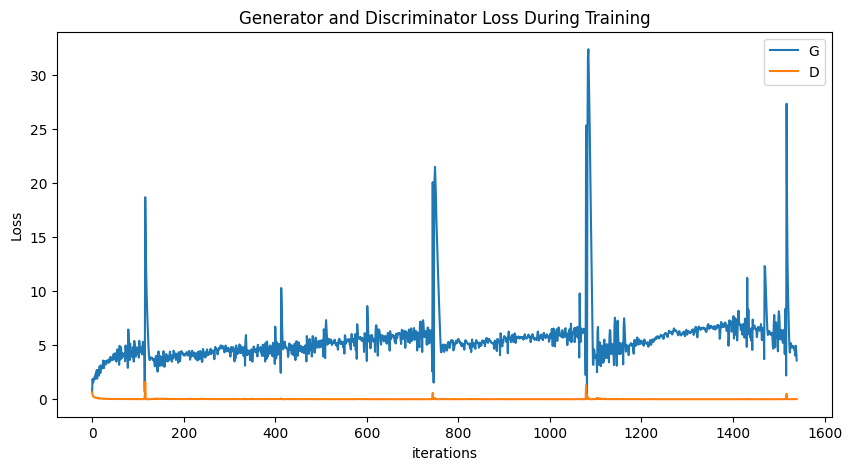

In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image, UnidentifiedImageError
from pycocotools.coco import COCO
from torchvision import datasets, transforms
from tqdm import tqdm
from transformers import BertModel, BertTokenizer


class COCODataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, ann_file, transform=None, max_images=19700):
        self.img_dir = img_dir
        self.coco = COCO(ann_file)
        self.ids = list(self.coco.anns.keys())[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        ann_id = self.ids[idx]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img_path = os.path.join(self.img_dir, path)
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, UnidentifiedImageError):
            return None, None
        if self.transform:
            image = self.transform(image)
        return image, caption


# Define TextEncoder
class TextEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(self.bert.config.hidden_size, embedding_dim)

    def forward(self, text):
        with torch.no_grad():
            encoded_layers = self.bert(text)['last_hidden_state']
        features = self.linear(encoded_layers[:, 0, :])
        return features

# Define Generator
class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, img_size * img_size * 3),
            nn.Tanh()
        )

    def forward(self, text, noise):
        x = torch.cat([text, noise], 1)
        img = self.fc(x)
        img = img.view(img.size(0), 3, img_size, img_size)
        return img

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, img_size, text_dim):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.fc = nn.Linear(256 * 8 * 8 + text_dim, 1)

    def forward(self, img, text):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, text], 1)
        validity = self.fc(x)
        return validity

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

# Hyperparameters
text_dim = 768
noise_dim = 100
img_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
epochs = 5

#save model here
save_dir = "/content/gdrive/MyDrive/dfgan"
os.makedirs(save_dir, exist_ok=True)
save_model_path = os.path.join(save_dir, "dfgan_model.pth")

# Data transformations
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


dataset = COCODataset(
    img_dir='coco_dataset/train2017',
    ann_file='coco_dataset/annotations/captions_train2017.json',
    transform=transform,
    max_images=19700
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)




# Initialize tokenizer and text encoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_encoder = TextEncoder(text_dim)

# Initialize models
generator = Generator(text_dim, noise_dim, img_size)
discriminator = Discriminator(img_size, text_dim)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Initialize lists to track losses
G_losses = []
D_losses = []

# Training loop
for epoch in range(epochs):
    for i, (imgs, captions) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)):
        if imgs is None or captions is None:
            continue

        batch_size = imgs.size(0)

        # Adversarial ground truths
        valid = torch.ones(batch_size, 1, requires_grad=False)
        fake = torch.zeros(batch_size, 1, requires_grad=False)

        # Configure input
        real_imgs = imgs.type(torch.FloatTensor)
        encoded_text = tokenizer(captions, return_tensors='pt', padding=True, truncation=True)['input_ids']

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, noise_dim)
        gen_text = text_encoder(encoded_text)
        gen_imgs = generator(gen_text, z)

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_text), valid)

        g_loss.backward(retain_graph=True)
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, gen_text), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_text), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Save losses for plotting later
        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        tqdm.write(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

# Save the trained model
torch.save({
    'generator_state_dict': generator.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
}, save_model_path)

print("Training finished and model saved.")

# Plot the training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision.utils import make_grid
from transformers import BertModel, BertTokenizer

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define TextEncoder, Generator, and other required classes (as in train_dfgan.py)
class TextEncoder(nn.Module):
    def __init__(self, embedding_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear = nn.Linear(self.bert.config.hidden_size, embedding_dim)

    def forward(self, text):
        with torch.no_grad():
            encoded_layers = self.bert(text)['last_hidden_state']
        features = self.linear(encoded_layers[:, 0, :])
        return features

class Generator(nn.Module):
    def __init__(self, text_dim, noise_dim, img_size):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(text_dim + noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, img_size * img_size * 3),
            nn.Tanh()
        )

    def forward(self, text, noise):
        x = torch.cat([text, noise], 1)
        img = self.fc(x)
        img = img.view(img.size(0), 3, img_size, img_size)
        return img

# Hyperparameters
text_dim = 768
noise_dim = 100
img_size = 64

save_dir = "/content/gdrive/MyDrive/dfgan"
os.makedirs(save_dir, exist_ok=True)
save_model_path = os.path.join(save_dir, "dfgan_model.pth")

# Load the model
checkpoint = torch.load(save_model_path, map_location=device)

# Initialize tokenizer and text encoder
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_encoder = TextEncoder(text_dim).to(device)

# Initialize models
generator = Generator(text_dim, noise_dim, img_size).to(device)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.eval()

def generate_image_from_text(text):
    encoded_text = tokenizer([text], return_tensors='pt', padding=True, truncation=True)['input_ids'].to(device)
    gen_text = text_encoder(encoded_text)
    z = torch.randn(1, noise_dim).to(device)
    gen_img = generator(gen_text, z)
    return gen_img

# Example usage
text_description = "text written"
generated_image = generate_image_from_text(text_description)

# Plot the generated image
plt.imshow(make_grid(generated_image, normalize=True).permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()